Loading the Data

In [60]:
import pandas as pda
import numpy as np
import math

#Loading data from csv
heart_df = pda.read_csv('healthcare-dataset-stroke-data.csv')

#Converting categorical data into intial numerical data to compute correlations.  Leter will apply onehot transformation
heart_df['gender'].replace(['Male', 'Female', 'Other'],[0, 1, 2], inplace=True)
heart_df['ever_married'].replace(['No', 'Yes'],[0, 1], inplace=True)
heart_df['work_type'].replace(['children', 'Govt_job', 'Never_worked', 'Private', 'Self-employed'], [0, 1, 2, 3, 4], inplace=True)
heart_df['Residence_type'].replace(['Urban', 'Rural'],[0, 1], inplace=True)
bmi_avg = heart_df['bmi'].mean()
heart_df['bmi'].fillna(bmi_avg, inplace = True)
heart_df['smoking_status'].replace(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],[0, 1, 2, 3], inplace=True)
#remove id column
headers = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
hs_df = heart_df[headers]

hs_df_stroke = hs_df[hs_df['stroke'] == 1]
rows = hs_df_stroke.shape[0]

rd = np.random.randint(0,rows,size=math.floor(hs_df.shape[0]/5))

hs_df_stroke_added = pda.DataFrame(columns = headers)
#display(hs_df_stroke_added)

for n in rd:
    df = hs_df_stroke.iloc[n:n+1,:]
    hs_df = pda.concat([hs_df, df], axis = 0, ignore_index = True)
    #hs_df_stroke_added = hs_df_stroke_added.append(df, ignore_index = True)
    #display(hs_df_stroke_added)

#hs_df = pda.concat([hs_df1, hs_df_stroke_added], axis = 0, ignore_index = True)
#hs_df = hs_df1.append(hs_df_stroke_added, ignore_index = True)

hs_df










,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,3,0,228.69,36.600000,0,1
1,1,61.0,0,0,1,4,1,202.21,28.893237,1,1
2,0,80.0,0,1,1,3,1,105.92,32.500000,1,1
3,1,49.0,0,0,1,3,0,171.23,34.400000,2,1
4,1,79.0,1,0,1,4,1,174.12,24.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
6127,0,49.0,0,0,0,3,1,104.86,31.900000,2,1
6128,0,57.0,0,0,1,3,1,84.96,36.700000,3,1
6129,1,50.0,0,0,1,3,1,102.16,31.400000,2,1
6130,1,54.0,1,0,1,1,0,180.93,27.700000,1,1


Attribute Correlation 

<Axes: >

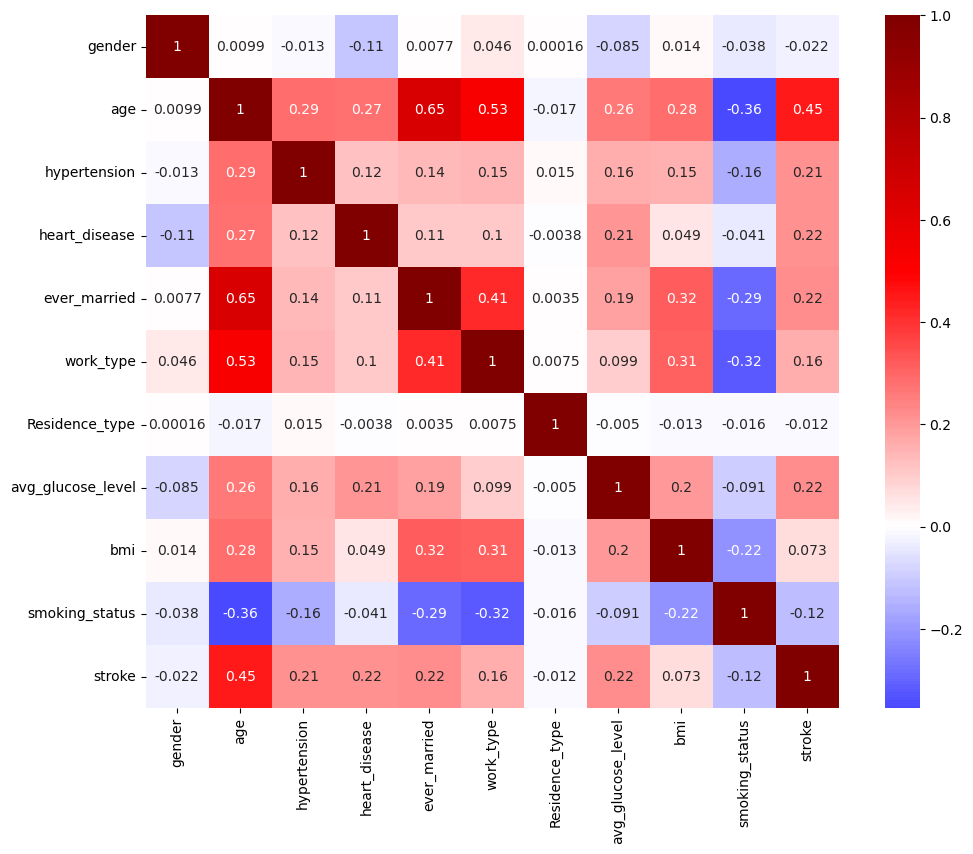

In [61]:
import matplotlib.pyplot as plot
import seaborn as sb

plot.figure(figsize = (12, 9))
corrMatrix = hs_df.corr()
sb.heatmap(corrMatrix, square = True, annot = True, center = 0, cmap = 'seismic')

Help Functions

In [52]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

#attribute normalization functions
def attribute_normalization():
    scaler = MinMaxScaler()
    ohe = OneHotEncoder(sparse_output = False)

    column_transform = make_column_transformer((ohe,['gender']),
                                               (scaler, ['age']), 
                                               (ohe,['hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']),
                                               (scaler, ['avg_glucose_level', 'bmi']),
                                               (ohe,['smoking_status'])
                                              )

    return column_transform


Evaluate NN with Optimal Hyperparameters

In [62]:
X = hs_df.iloc[:,0:10]
y = hs_df.iloc[:,10]

# Data normalization
transformer = attribute_normalization()
XX = transformer.fit_transform(X)


# Split data into train, test and validation
X_trainAll, X_test, y_trainAll, y_test = train_test_split(XX, y, test_size = 0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainAll, y_trainAll, test_size = 0.2)

feature_names = transformer.get_feature_names_out()
X_train_df = pda.DataFrame(X_train, columns = feature_names)
X_valid_df = pda.DataFrame(X_valid, columns = feature_names)
X_test_df  = pda.DataFrame(X_test, columns = feature_names)
y_train_df = pda.DataFrame(y_train, columns = ['stroke'])
y_valid_df = pda.DataFrame(y_valid, columns = ['stroke'])
y_test_df  = pda.DataFrame(y_test, columns = ['stroke'])


y_train_df.dtypes.values





array([dtype('int64')], dtype=object)

In [63]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, InputLayer
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier

X = hs_df.iloc[:,0:10]
y = hs_df.iloc[:,10]

# Data normalization
transformer = attribute_normalization()
XX = transformer.fit_transform(X)

# Split data into train, test and validation
X_trainAll, X_test, y_trainAll, y_test = train_test_split(XX, y, test_size = 0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainAll, y_trainAll, test_size = 0.2)

feature_names = transformer.get_feature_names_out()
X_train_df = pda.DataFrame(X_train, columns = feature_names)
X_valid_df = pda.DataFrame(X_valid, columns = feature_names)
X_test_df  = pda.DataFrame(X_test, columns = feature_names)
y_train_df = pda.DataFrame(y_train, columns = ['stroke'])
y_valid_df = pda.DataFrame(y_valid, columns = ['stroke'])
y_test_df  = pda.DataFrame(y_test, columns = ['stroke'])

# set up NN model
def setup_model(no_hidden = 1, no_neurons = 8, learning_rate = 0.01):
    model = Sequential()
    model.add(keras.Input(shape=(23,)))
    #hidden layers
    for layer in range(0, no_hidden):
        model.add(keras.layers.Dense(units=no_neurons, activation = 'relu', kernel_initializer = 'random_normal',
                                    bias_initializer = 'zeros'))
    #output layer
    model.add(keras.layers.Dense(units=1, activation = 'sigmoid', kernel_initializer = 'random_normal',
                                bias_initializer = 'zeros'))
    #configure the mnodel for training
    model.compile(loss = 'binary_crossentropy', optimizer = 'adamax', metrics = ['Accuracy'])
    return model

# set up early stop
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, mode = 'min', verbose = 1, patience = 50)

# set up pipeline
pipeline = Pipeline([('heart_stroke_nn', KerasClassifier(learning_rate=0.1, no_hidden = 1, no_neurons = 10, 
                                                    model = setup_model, epochs = 100, batch_size = 5, verbose = 1))])

# Set up the search space for the hyperparameters 
params = {"heart_stroke_nn__no_hidden": [2, 3], "heart_stroke_nn__no_neurons": range(9, 15), 
          "heart_stroke_nn__learning_rate": [0.0001, 0.001, 0.01]}

# Randomly searching best hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

search = GridSearchCV(estimator=pipeline, param_grid=params, cv = 5, error_score='raise')
model = search.fit(X_train_df, y_train_df, heart_stroke_nn__validation_data = (X_valid_df, y_valid_df), 
                   heart_stroke_nn__callbacks = [es])

# Get the optimal parameters
print("Best parameters:")
print(model.best_params_)

# Test model
y_pred = model.predict(X_test_df)
y_pred = (y_pred > 0.5)

# Calculate test scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Epoch 1/100
628/628 [==============================] - 1s 1ms/step - loss: 0.5844 - Accuracy: 0.7977 - val_loss: 0.5249 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4844 - Accuracy: 0.7990 - val_loss: 0.5096 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4665 - Accuracy: 0.7990 - val_loss: 0.4889 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4481 - Accuracy: 0.7990 - val_loss: 0.4710 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4337 - Accuracy: 0.7990 - val_loss: 0.4631 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4242 - Accuracy: 0.7990 - val_loss: 0.4557 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4174 - Accuracy: 0.8022 - val_loss: 0.4521 - val_Accuracy: 0.7778

Epoch 58/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3634 - Accuracy: 0.8219 - val_loss: 0.3880 - val_Accuracy: 0.8084
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3630 - Accuracy: 0.8292 - val_loss: 0.3890 - val_Accuracy: 0.8063
Epoch 60/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3625 - Accuracy: 0.8229 - val_loss: 0.3872 - val_Accuracy: 0.8114
Epoch 61/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3628 - Accuracy: 0.8277 - val_loss: 0.3869 - val_Accuracy: 0.8145
Epoch 62/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3621 - Accuracy: 0.8308 - val_loss: 0.3943 - val_Accuracy: 0.8063
Epoch 63/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3625 - Accuracy: 0.8283 - val_loss: 0.3879 - val_Accuracy: 0.8094
Epoch 64/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3623 - Accuracy: 0.8289 - val_loss: 0.3857 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3912 - Accuracy: 0.8069 - val_loss: 0.4317 - val_Accuracy: 0.7788
Epoch 15/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3874 - Accuracy: 0.8136 - val_loss: 0.4333 - val_Accuracy: 0.7808
Epoch 16/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3857 - Accuracy: 0.8098 - val_loss: 0.4213 - val_Accuracy: 0.7910
Epoch 17/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3828 - Accuracy: 0.8127 - val_loss: 0.4152 - val_Accuracy: 0.8012
Epoch 18/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3807 - Accuracy: 0.8191 - val_loss: 0.4133 - val_Accuracy: 0.8033
Epoch 19/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3783 - Accuracy: 0.8203 - val_loss: 0.4123 - val_Accuracy: 0.8063
Epoch 20/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3763 - Accuracy: 0.8222 - val_loss: 0.4082 - val_Accuracy: 0.8094
Epoch

Epoch 71/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3514 - Accuracy: 0.8394 - val_loss: 0.3860 - val_Accuracy: 0.8216
Epoch 72/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3508 - Accuracy: 0.8404 - val_loss: 0.3815 - val_Accuracy: 0.8267
Epoch 73/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3505 - Accuracy: 0.8426 - val_loss: 0.3808 - val_Accuracy: 0.8298
Epoch 74/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3506 - Accuracy: 0.8388 - val_loss: 0.3836 - val_Accuracy: 0.8247
Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3500 - Accuracy: 0.8350 - val_loss: 0.3835 - val_Accuracy: 0.8216
Epoch 76/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3506 - Accuracy: 0.8375 - val_loss: 0.3815 - val_Accuracy: 0.8257
Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3504 - Accuracy: 0.8388 - val_loss: 0.3836 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3659 - Accuracy: 0.8219 - val_loss: 0.3958 - val_Accuracy: 0.8063
Epoch 28/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3654 - Accuracy: 0.8222 - val_loss: 0.3937 - val_Accuracy: 0.8033
Epoch 29/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3647 - Accuracy: 0.8222 - val_loss: 0.3929 - val_Accuracy: 0.8063
Epoch 30/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3640 - Accuracy: 0.8203 - val_loss: 0.3931 - val_Accuracy: 0.8073
Epoch 31/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3631 - Accuracy: 0.8194 - val_loss: 0.3910 - val_Accuracy: 0.8063
Epoch 32/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3622 - Accuracy: 0.8216 - val_loss: 0.3897 - val_Accuracy: 0.8053
Epoch 33/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3617 - Accuracy: 0.8235 - val_loss: 0.3911 - val_Accuracy: 0.8114
Epoch

Epoch 84/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3506 - Accuracy: 0.8327 - val_loss: 0.3801 - val_Accuracy: 0.8206
Epoch 85/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3505 - Accuracy: 0.8302 - val_loss: 0.3789 - val_Accuracy: 0.8206
Epoch 86/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3504 - Accuracy: 0.8280 - val_loss: 0.3791 - val_Accuracy: 0.8236
Epoch 87/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3505 - Accuracy: 0.8305 - val_loss: 0.3823 - val_Accuracy: 0.8175
Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3498 - Accuracy: 0.8318 - val_loss: 0.3783 - val_Accuracy: 0.8236
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3498 - Accuracy: 0.8296 - val_loss: 0.3836 - val_Accuracy: 0.8165
Epoch 90/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3503 - Accuracy: 0.8324 - val_loss: 0.3799 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3650 - Accuracy: 0.8191 - val_loss: 0.3896 - val_Accuracy: 0.8053
Epoch 41/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3643 - Accuracy: 0.8232 - val_loss: 0.3903 - val_Accuracy: 0.8063
Epoch 42/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3631 - Accuracy: 0.8197 - val_loss: 0.3878 - val_Accuracy: 0.8145
Epoch 43/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3631 - Accuracy: 0.8226 - val_loss: 0.3908 - val_Accuracy: 0.8033
Epoch 44/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3626 - Accuracy: 0.8219 - val_loss: 0.3883 - val_Accuracy: 0.8084
Epoch 45/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3609 - Accuracy: 0.8232 - val_loss: 0.3908 - val_Accuracy: 0.8063
Epoch 46/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3620 - Accuracy: 0.8238 - val_loss: 0.3867 - val_Accuracy: 0.8094
Epoch

Epoch 97/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3523 - Accuracy: 0.8340 - val_loss: 0.3809 - val_Accuracy: 0.8247
Epoch 98/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3526 - Accuracy: 0.8350 - val_loss: 0.3847 - val_Accuracy: 0.8186
Epoch 99/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3523 - Accuracy: 0.8318 - val_loss: 0.3879 - val_Accuracy: 0.8226
Epoch 100/100
157/157 [==============================] - 0s 1ms/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5834 - Accuracy: 0.7984 - val_loss: 0.5259 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4883 - Accuracy: 0.7987 - val_loss: 0.5167 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4772 - Accuracy: 0.7987 - val_loss: 0.5041 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - l

628/628 [==============================] - 1s 2ms/step - loss: 0.3641 - Accuracy: 0.8178 - val_loss: 0.3874 - val_Accuracy: 0.8022
Epoch 54/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3642 - Accuracy: 0.8185 - val_loss: 0.3911 - val_Accuracy: 0.8053
Epoch 55/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3635 - Accuracy: 0.8239 - val_loss: 0.3866 - val_Accuracy: 0.8053
Epoch 56/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3638 - Accuracy: 0.8191 - val_loss: 0.3884 - val_Accuracy: 0.8043
Epoch 57/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3629 - Accuracy: 0.8210 - val_loss: 0.3874 - val_Accuracy: 0.8084
Epoch 58/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3630 - Accuracy: 0.8248 - val_loss: 0.3883 - val_Accuracy: 0.8033
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3624 - Accuracy: 0.8232 - val_loss: 0.3888 - val_Accuracy: 0.8053
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.4173 - Accuracy: 0.7990 - val_loss: 0.4533 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4138 - Accuracy: 0.7990 - val_loss: 0.4521 - val_Accuracy: 0.7727
Epoch 11/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4104 - Accuracy: 0.7990 - val_loss: 0.4481 - val_Accuracy: 0.7727
Epoch 12/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4071 - Accuracy: 0.7990 - val_loss: 0.4453 - val_Accuracy: 0.7727
Epoch 13/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4034 - Accuracy: 0.7990 - val_loss: 0.4421 - val_Accuracy: 0.7727
Epoch 14/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4005 - Accuracy: 0.7987 - val_loss: 0.4373 - val_Accuracy: 0.7778
Epoch 15/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3978 - Accuracy: 0.8050 - val_loss: 0.4349 - val_Accuracy: 0.7910
Epoch

Epoch 66/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3562 - Accuracy: 0.8401 - val_loss: 0.3982 - val_Accuracy: 0.8033
Epoch 67/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3563 - Accuracy: 0.8350 - val_loss: 0.3898 - val_Accuracy: 0.8196
Epoch 68/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3560 - Accuracy: 0.8337 - val_loss: 0.3869 - val_Accuracy: 0.8196
Epoch 69/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3559 - Accuracy: 0.8378 - val_loss: 0.3915 - val_Accuracy: 0.8145
Epoch 70/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3563 - Accuracy: 0.8375 - val_loss: 0.3876 - val_Accuracy: 0.8226
Epoch 71/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3562 - Accuracy: 0.8398 - val_loss: 0.3898 - val_Accuracy: 0.8186
Epoch 72/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3561 - Accuracy: 0.8429 - val_loss: 0.3902 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3684 - Accuracy: 0.8216 - val_loss: 0.3936 - val_Accuracy: 0.8104
Epoch 23/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3679 - Accuracy: 0.8206 - val_loss: 0.3946 - val_Accuracy: 0.8012
Epoch 24/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3671 - Accuracy: 0.8219 - val_loss: 0.3940 - val_Accuracy: 0.7971
Epoch 25/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3662 - Accuracy: 0.8235 - val_loss: 0.3911 - val_Accuracy: 0.8124
Epoch 26/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3652 - Accuracy: 0.8194 - val_loss: 0.3915 - val_Accuracy: 0.8053
Epoch 27/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3643 - Accuracy: 0.8213 - val_loss: 0.3950 - val_Accuracy: 0.7992
Epoch 28/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3639 - Accuracy: 0.8245 - val_loss: 0.3918 - val_Accuracy: 0.8002
Epoch

Epoch 79/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3482 - Accuracy: 0.8388 - val_loss: 0.3777 - val_Accuracy: 0.8216
Epoch 80/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3471 - Accuracy: 0.8398 - val_loss: 0.3812 - val_Accuracy: 0.8257
Epoch 81/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3466 - Accuracy: 0.8398 - val_loss: 0.3776 - val_Accuracy: 0.8257
Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3469 - Accuracy: 0.8404 - val_loss: 0.3873 - val_Accuracy: 0.8165
Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3465 - Accuracy: 0.8404 - val_loss: 0.3807 - val_Accuracy: 0.8308
Epoch 84/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3462 - Accuracy: 0.8426 - val_loss: 0.3789 - val_Accuracy: 0.8277
Epoch 85/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3467 - Accuracy: 0.8436 - val_loss: 0.3820 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3649 - Accuracy: 0.8222 - val_loss: 0.3907 - val_Accuracy: 0.8063
Epoch 36/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3647 - Accuracy: 0.8197 - val_loss: 0.3879 - val_Accuracy: 0.8094
Epoch 37/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3645 - Accuracy: 0.8191 - val_loss: 0.3875 - val_Accuracy: 0.8155
Epoch 38/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3634 - Accuracy: 0.8248 - val_loss: 0.3964 - val_Accuracy: 0.7992
Epoch 39/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3650 - Accuracy: 0.8200 - val_loss: 0.3884 - val_Accuracy: 0.8114
Epoch 40/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3636 - Accuracy: 0.8203 - val_loss: 0.3945 - val_Accuracy: 0.8022
Epoch 41/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3634 - Accuracy: 0.8191 - val_loss: 0.3868 - val_Accuracy: 0.8094
Epoch

Epoch 92/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3521 - Accuracy: 0.8308 - val_loss: 0.3789 - val_Accuracy: 0.8175
Epoch 93/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3523 - Accuracy: 0.8312 - val_loss: 0.3850 - val_Accuracy: 0.8124
Epoch 94/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3508 - Accuracy: 0.8299 - val_loss: 0.3829 - val_Accuracy: 0.8145
Epoch 95/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3518 - Accuracy: 0.8296 - val_loss: 0.3775 - val_Accuracy: 0.8175
Epoch 96/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3521 - Accuracy: 0.8312 - val_loss: 0.3781 - val_Accuracy: 0.8145
Epoch 97/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3515 - Accuracy: 0.8331 - val_loss: 0.3767 - val_Accuracy: 0.8186
Epoch 98/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3510 - Accuracy: 0.8296 - val_loss: 0.3768 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3585 - Accuracy: 0.8366 - val_loss: 0.3857 - val_Accuracy: 0.8226
Epoch 49/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3580 - Accuracy: 0.8375 - val_loss: 0.3849 - val_Accuracy: 0.8257
Epoch 50/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3576 - Accuracy: 0.8356 - val_loss: 0.3832 - val_Accuracy: 0.8267
Epoch 51/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3576 - Accuracy: 0.8375 - val_loss: 0.3869 - val_Accuracy: 0.8175
Epoch 52/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3572 - Accuracy: 0.8353 - val_loss: 0.3822 - val_Accuracy: 0.8267
Epoch 53/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3573 - Accuracy: 0.8378 - val_loss: 0.3830 - val_Accuracy: 0.8328
Epoch 54/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3567 - Accuracy: 0.8394 - val_loss: 0.3855 - val_Accuracy: 0.8257
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4398 - Accuracy: 0.7987 - val_loss: 0.4667 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4292 - Accuracy: 0.7987 - val_loss: 0.4636 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4216 - Accuracy: 0.7987 - val_loss: 0.4539 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4167 - Accuracy: 0.7987 - val_loss: 0.4506 - val_Accuracy: 0.7727
Epoch 8/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4116 - Accuracy: 0.7987 - val_loss: 0.4484 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4078 - Accuracy: 0.7984 - val_loss: 0.4435 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4038 - Accuracy: 0.7987 - val_loss: 0.4384 - val_Accuracy: 0.7870
Epoch 11/1

628/628 [==============================] - 1s 1ms/step - loss: 0.3542 - Accuracy: 0.8369 - val_loss: 0.3843 - val_Accuracy: 0.8216
Epoch 62/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3535 - Accuracy: 0.8344 - val_loss: 0.3810 - val_Accuracy: 0.8196
Epoch 63/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3538 - Accuracy: 0.8357 - val_loss: 0.3884 - val_Accuracy: 0.8186
Epoch 64/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3525 - Accuracy: 0.8366 - val_loss: 0.3810 - val_Accuracy: 0.8206
Epoch 65/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3530 - Accuracy: 0.8354 - val_loss: 0.3809 - val_Accuracy: 0.8226
Epoch 66/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3520 - Accuracy: 0.8395 - val_loss: 0.3797 - val_Accuracy: 0.8247
Epoch 67/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3526 - Accuracy: 0.8366 - val_loss: 0.3821 - val_Accuracy: 0.8206
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.3858 - Accuracy: 0.8140 - val_loss: 0.4289 - val_Accuracy: 0.7890
Epoch 18/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3835 - Accuracy: 0.8143 - val_loss: 0.4197 - val_Accuracy: 0.7951
Epoch 19/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3811 - Accuracy: 0.8146 - val_loss: 0.4179 - val_Accuracy: 0.7941
Epoch 20/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3786 - Accuracy: 0.8171 - val_loss: 0.4175 - val_Accuracy: 0.7961
Epoch 21/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3767 - Accuracy: 0.8165 - val_loss: 0.4119 - val_Accuracy: 0.8012
Epoch 22/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3750 - Accuracy: 0.8187 - val_loss: 0.4083 - val_Accuracy: 0.8012
Epoch 23/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3732 - Accuracy: 0.8178 - val_loss: 0.4070 - val_Accuracy: 0.8033
Epoch

Epoch 74/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3471 - Accuracy: 0.8417 - val_loss: 0.3795 - val_Accuracy: 0.8298
Epoch 75/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3465 - Accuracy: 0.8417 - val_loss: 0.3792 - val_Accuracy: 0.8349
Epoch 76/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3460 - Accuracy: 0.8414 - val_loss: 0.3779 - val_Accuracy: 0.8328
Epoch 77/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3460 - Accuracy: 0.8414 - val_loss: 0.3790 - val_Accuracy: 0.8338
Epoch 78/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3457 - Accuracy: 0.8436 - val_loss: 0.3804 - val_Accuracy: 0.8277
Epoch 79/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3457 - Accuracy: 0.8439 - val_loss: 0.3773 - val_Accuracy: 0.8328
Epoch 80/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3449 - Accuracy: 0.8426 - val_loss: 0.3798 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3692 - Accuracy: 0.8200 - val_loss: 0.3966 - val_Accuracy: 0.8084
Epoch 31/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3685 - Accuracy: 0.8200 - val_loss: 0.4026 - val_Accuracy: 0.7961
Epoch 32/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3690 - Accuracy: 0.8241 - val_loss: 0.3958 - val_Accuracy: 0.8053
Epoch 33/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3685 - Accuracy: 0.8191 - val_loss: 0.3945 - val_Accuracy: 0.8084
Epoch 34/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3673 - Accuracy: 0.8219 - val_loss: 0.4009 - val_Accuracy: 0.7941
Epoch 35/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3676 - Accuracy: 0.8194 - val_loss: 0.3929 - val_Accuracy: 0.8053
Epoch 36/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3679 - Accuracy: 0.8229 - val_loss: 0.3917 - val_Accuracy: 0.8094
Epoch

Epoch 87/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3547 - Accuracy: 0.8337 - val_loss: 0.3840 - val_Accuracy: 0.8114
Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3548 - Accuracy: 0.8283 - val_loss: 0.3840 - val_Accuracy: 0.8094
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3547 - Accuracy: 0.8318 - val_loss: 0.3825 - val_Accuracy: 0.8104
Epoch 90/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3541 - Accuracy: 0.8315 - val_loss: 0.3806 - val_Accuracy: 0.8206
Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3541 - Accuracy: 0.8299 - val_loss: 0.3850 - val_Accuracy: 0.8073
Epoch 92/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3541 - Accuracy: 0.8286 - val_loss: 0.3816 - val_Accuracy: 0.8145
Epoch 93/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3536 - Accuracy: 0.8347 - val_loss: 0.3822 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3633 - Accuracy: 0.8232 - val_loss: 0.3906 - val_Accuracy: 0.8094
Epoch 44/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3629 - Accuracy: 0.8248 - val_loss: 0.3846 - val_Accuracy: 0.8226
Epoch 45/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3634 - Accuracy: 0.8213 - val_loss: 0.3897 - val_Accuracy: 0.8063
Epoch 46/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3623 - Accuracy: 0.8241 - val_loss: 0.3863 - val_Accuracy: 0.8043
Epoch 47/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3628 - Accuracy: 0.8206 - val_loss: 0.3868 - val_Accuracy: 0.8063
Epoch 48/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3615 - Accuracy: 0.8270 - val_loss: 0.3840 - val_Accuracy: 0.8124
Epoch 49/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3620 - Accuracy: 0.8257 - val_loss: 0.3919 - val_Accuracy: 0.8033
Epoch

Epoch 100/100
157/157 [==============================] - 0s 847us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5866 - Accuracy: 0.7961 - val_loss: 0.5233 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4836 - Accuracy: 0.7990 - val_loss: 0.5064 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4660 - Accuracy: 0.7990 - val_loss: 0.4887 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4502 - Accuracy: 0.7990 - val_loss: 0.4725 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4376 - Accuracy: 0.7990 - val_loss: 0.4624 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4284 - Accuracy: 0.7990 - val_loss: 0.4550 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 1ms/step - lo

628/628 [==============================] - 1s 1ms/step - loss: 0.3589 - Accuracy: 0.8261 - val_loss: 0.3864 - val_Accuracy: 0.8104
Epoch 57/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3597 - Accuracy: 0.8248 - val_loss: 0.3826 - val_Accuracy: 0.8124
Epoch 58/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3592 - Accuracy: 0.8261 - val_loss: 0.3877 - val_Accuracy: 0.8104
Epoch 59/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3590 - Accuracy: 0.8283 - val_loss: 0.3829 - val_Accuracy: 0.8104
Epoch 60/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3592 - Accuracy: 0.8248 - val_loss: 0.3817 - val_Accuracy: 0.8165
Epoch 61/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3583 - Accuracy: 0.8264 - val_loss: 0.3816 - val_Accuracy: 0.8104
Epoch 62/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3585 - Accuracy: 0.8261 - val_loss: 0.3817 - val_Accuracy: 0.8145
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.3967 - Accuracy: 0.7975 - val_loss: 0.4345 - val_Accuracy: 0.7859
Epoch 13/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3938 - Accuracy: 0.8003 - val_loss: 0.4287 - val_Accuracy: 0.7819
Epoch 14/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3921 - Accuracy: 0.8057 - val_loss: 0.4262 - val_Accuracy: 0.7890
Epoch 15/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3885 - Accuracy: 0.8057 - val_loss: 0.4317 - val_Accuracy: 0.7829
Epoch 16/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3876 - Accuracy: 0.8076 - val_loss: 0.4199 - val_Accuracy: 0.7910
Epoch 17/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3855 - Accuracy: 0.8086 - val_loss: 0.4171 - val_Accuracy: 0.7931
Epoch 18/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3835 - Accuracy: 0.8118 - val_loss: 0.4192 - val_Accuracy: 0.7931
Epoch

Epoch 69/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3554 - Accuracy: 0.8363 - val_loss: 0.3861 - val_Accuracy: 0.8196
Epoch 70/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3558 - Accuracy: 0.8344 - val_loss: 0.3850 - val_Accuracy: 0.8186
Epoch 71/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3556 - Accuracy: 0.8338 - val_loss: 0.3852 - val_Accuracy: 0.8145
Epoch 72/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3552 - Accuracy: 0.8334 - val_loss: 0.3851 - val_Accuracy: 0.8216
Epoch 73/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3545 - Accuracy: 0.8385 - val_loss: 0.3862 - val_Accuracy: 0.8196
Epoch 74/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3545 - Accuracy: 0.8325 - val_loss: 0.3856 - val_Accuracy: 0.8216
Epoch 75/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3541 - Accuracy: 0.8299 - val_loss: 0.3889 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3694 - Accuracy: 0.8175 - val_loss: 0.4046 - val_Accuracy: 0.7941
Epoch 26/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3685 - Accuracy: 0.8206 - val_loss: 0.3973 - val_Accuracy: 0.8043
Epoch 27/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3674 - Accuracy: 0.8206 - val_loss: 0.3971 - val_Accuracy: 0.8022
Epoch 28/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3673 - Accuracy: 0.8213 - val_loss: 0.3970 - val_Accuracy: 0.7992
Epoch 29/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3669 - Accuracy: 0.8181 - val_loss: 0.3944 - val_Accuracy: 0.8053
Epoch 30/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3665 - Accuracy: 0.8206 - val_loss: 0.3976 - val_Accuracy: 0.8012
Epoch 31/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3661 - Accuracy: 0.8213 - val_loss: 0.3943 - val_Accuracy: 0.8063
Epoch

Epoch 82/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3584 - Accuracy: 0.8331 - val_loss: 0.3832 - val_Accuracy: 0.8247
Epoch 83/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3579 - Accuracy: 0.8331 - val_loss: 0.3869 - val_Accuracy: 0.8206
Epoch 84/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3575 - Accuracy: 0.8350 - val_loss: 0.3834 - val_Accuracy: 0.8206
Epoch 85/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3577 - Accuracy: 0.8286 - val_loss: 0.3824 - val_Accuracy: 0.8236
Epoch 86/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3566 - Accuracy: 0.8340 - val_loss: 0.3815 - val_Accuracy: 0.8206
Epoch 87/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3576 - Accuracy: 0.8299 - val_loss: 0.3812 - val_Accuracy: 0.8226
Epoch 88/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3567 - Accuracy: 0.8353 - val_loss: 0.3810 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3586 - Accuracy: 0.8337 - val_loss: 0.3863 - val_Accuracy: 0.8135
Epoch 39/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3579 - Accuracy: 0.8350 - val_loss: 0.3887 - val_Accuracy: 0.8073
Epoch 40/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3569 - Accuracy: 0.8327 - val_loss: 0.3864 - val_Accuracy: 0.8175
Epoch 41/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3572 - Accuracy: 0.8312 - val_loss: 0.3852 - val_Accuracy: 0.8196
Epoch 42/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3565 - Accuracy: 0.8343 - val_loss: 0.3828 - val_Accuracy: 0.8196
Epoch 43/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3563 - Accuracy: 0.8312 - val_loss: 0.3851 - val_Accuracy: 0.8247
Epoch 44/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3549 - Accuracy: 0.8356 - val_loss: 0.3866 - val_Accuracy: 0.8206
Epoch

Epoch 95/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3360 - Accuracy: 0.8490 - val_loss: 0.3763 - val_Accuracy: 0.8226
Epoch 96/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3360 - Accuracy: 0.8455 - val_loss: 0.3750 - val_Accuracy: 0.8257
Epoch 97/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3346 - Accuracy: 0.8493 - val_loss: 0.3920 - val_Accuracy: 0.8094
Epoch 98/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3359 - Accuracy: 0.8471 - val_loss: 0.3762 - val_Accuracy: 0.8216
Epoch 99/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3353 - Accuracy: 0.8449 - val_loss: 0.3750 - val_Accuracy: 0.8226
Epoch 100/100
157/157 [==============================] - 0s 902us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5528 - Accuracy: 0.7983 - val_loss: 0.5164 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 1ms/step

628/628 [==============================] - 1s 1ms/step - loss: 0.3591 - Accuracy: 0.8241 - val_loss: 0.3834 - val_Accuracy: 0.8084
Epoch 52/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3580 - Accuracy: 0.8216 - val_loss: 0.3844 - val_Accuracy: 0.8063
Epoch 53/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3572 - Accuracy: 0.8248 - val_loss: 0.3910 - val_Accuracy: 0.8094
Epoch 54/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3575 - Accuracy: 0.8238 - val_loss: 0.3825 - val_Accuracy: 0.8084
Epoch 55/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3570 - Accuracy: 0.8280 - val_loss: 0.3820 - val_Accuracy: 0.8175
Epoch 56/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3571 - Accuracy: 0.8267 - val_loss: 0.3830 - val_Accuracy: 0.8084
Epoch 57/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3570 - Accuracy: 0.8277 - val_loss: 0.3891 - val_Accuracy: 0.8104
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.4105 - Accuracy: 0.7990 - val_loss: 0.4393 - val_Accuracy: 0.7727
Epoch 8/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4052 - Accuracy: 0.7990 - val_loss: 0.4389 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4006 - Accuracy: 0.7990 - val_loss: 0.4306 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3955 - Accuracy: 0.7990 - val_loss: 0.4261 - val_Accuracy: 0.7727
Epoch 11/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3921 - Accuracy: 0.7990 - val_loss: 0.4208 - val_Accuracy: 0.7727
Epoch 12/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3888 - Accuracy: 0.7990 - val_loss: 0.4173 - val_Accuracy: 0.7727
Epoch 13/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3858 - Accuracy: 0.7990 - val_loss: 0.4151 - val_Accuracy: 0.7727
Epoch 1

Epoch 64/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3611 - Accuracy: 0.8229 - val_loss: 0.3792 - val_Accuracy: 0.8145
Epoch 65/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3607 - Accuracy: 0.8245 - val_loss: 0.3798 - val_Accuracy: 0.8298
Epoch 66/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3609 - Accuracy: 0.8238 - val_loss: 0.3784 - val_Accuracy: 0.8186
Epoch 67/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3603 - Accuracy: 0.8248 - val_loss: 0.3782 - val_Accuracy: 0.8094
Epoch 68/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3602 - Accuracy: 0.8261 - val_loss: 0.3809 - val_Accuracy: 0.8114
Epoch 69/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3601 - Accuracy: 0.8200 - val_loss: 0.3772 - val_Accuracy: 0.8216
Epoch 70/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3601 - Accuracy: 0.8219 - val_loss: 0.3775 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3773 - Accuracy: 0.8191 - val_loss: 0.4111 - val_Accuracy: 0.8022
Epoch 21/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3759 - Accuracy: 0.8166 - val_loss: 0.4079 - val_Accuracy: 0.7951
Epoch 22/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3741 - Accuracy: 0.8201 - val_loss: 0.4081 - val_Accuracy: 0.8094
Epoch 23/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3729 - Accuracy: 0.8188 - val_loss: 0.4052 - val_Accuracy: 0.8094
Epoch 24/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3719 - Accuracy: 0.8201 - val_loss: 0.4039 - val_Accuracy: 0.8094
Epoch 25/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3707 - Accuracy: 0.8223 - val_loss: 0.4014 - val_Accuracy: 0.8094
Epoch 26/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3697 - Accuracy: 0.8220 - val_loss: 0.3990 - val_Accuracy: 0.8114
Epoch

Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3485 - Accuracy: 0.8395 - val_loss: 0.3809 - val_Accuracy: 0.8206
Epoch 78/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3481 - Accuracy: 0.8385 - val_loss: 0.3789 - val_Accuracy: 0.8236
Epoch 79/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3478 - Accuracy: 0.8385 - val_loss: 0.3811 - val_Accuracy: 0.8196
Epoch 80/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3476 - Accuracy: 0.8392 - val_loss: 0.3796 - val_Accuracy: 0.8196
Epoch 81/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3475 - Accuracy: 0.8354 - val_loss: 0.3784 - val_Accuracy: 0.8226
Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3472 - Accuracy: 0.8366 - val_loss: 0.3774 - val_Accuracy: 0.8257
Epoch 83/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3467 - Accuracy: 0.8379 - val_loss: 0.3780 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3621 - Accuracy: 0.8280 - val_loss: 0.3872 - val_Accuracy: 0.8267
Epoch 34/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3618 - Accuracy: 0.8292 - val_loss: 0.3902 - val_Accuracy: 0.8053
Epoch 35/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3606 - Accuracy: 0.8334 - val_loss: 0.3876 - val_Accuracy: 0.8155
Epoch 36/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3618 - Accuracy: 0.8315 - val_loss: 0.3930 - val_Accuracy: 0.8002
Epoch 37/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3607 - Accuracy: 0.8340 - val_loss: 0.3857 - val_Accuracy: 0.8257
Epoch 38/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3604 - Accuracy: 0.8308 - val_loss: 0.3853 - val_Accuracy: 0.8257
Epoch 39/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3601 - Accuracy: 0.8347 - val_loss: 0.3843 - val_Accuracy: 0.8277
Epoch

Epoch 90/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3506 - Accuracy: 0.8404 - val_loss: 0.3788 - val_Accuracy: 0.8257
Epoch 91/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3503 - Accuracy: 0.8410 - val_loss: 0.3769 - val_Accuracy: 0.8277
Epoch 92/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3505 - Accuracy: 0.8385 - val_loss: 0.3839 - val_Accuracy: 0.8186
Epoch 93/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3511 - Accuracy: 0.8378 - val_loss: 0.3792 - val_Accuracy: 0.8287
Epoch 94/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3508 - Accuracy: 0.8401 - val_loss: 0.3765 - val_Accuracy: 0.8287
Epoch 95/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3508 - Accuracy: 0.8410 - val_loss: 0.3838 - val_Accuracy: 0.8226
Epoch 96/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3502 - Accuracy: 0.8372 - val_loss: 0.3789 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3603 - Accuracy: 0.8327 - val_loss: 0.3879 - val_Accuracy: 0.8165
Epoch 47/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3598 - Accuracy: 0.8343 - val_loss: 0.3862 - val_Accuracy: 0.8206
Epoch 48/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3604 - Accuracy: 0.8334 - val_loss: 0.3876 - val_Accuracy: 0.8165
Epoch 49/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3595 - Accuracy: 0.8327 - val_loss: 0.3860 - val_Accuracy: 0.8196
Epoch 50/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3597 - Accuracy: 0.8334 - val_loss: 0.3855 - val_Accuracy: 0.8196
Epoch 51/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3592 - Accuracy: 0.8334 - val_loss: 0.3873 - val_Accuracy: 0.8186
Epoch 52/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3594 - Accuracy: 0.8334 - val_loss: 0.3866 - val_Accuracy: 0.8196
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.4688 - Accuracy: 0.7990 - val_loss: 0.4889 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4472 - Accuracy: 0.7990 - val_loss: 0.4687 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4300 - Accuracy: 0.7990 - val_loss: 0.4571 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4189 - Accuracy: 0.7990 - val_loss: 0.4489 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4119 - Accuracy: 0.7990 - val_loss: 0.4440 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4065 - Accuracy: 0.7996 - val_loss: 0.4397 - val_Accuracy: 0.7859
Epoch 8/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4007 - Accuracy: 0.8076 - val_loss: 0.4379 - val_Accuracy: 0.7829
Epoch 9/100

628/628 [==============================] - 1s 1ms/step - loss: 0.3520 - Accuracy: 0.8318 - val_loss: 0.3784 - val_Accuracy: 0.8287
Epoch 60/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3510 - Accuracy: 0.8308 - val_loss: 0.3778 - val_Accuracy: 0.8287
Epoch 61/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3511 - Accuracy: 0.8312 - val_loss: 0.3823 - val_Accuracy: 0.8186
Epoch 62/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3509 - Accuracy: 0.8318 - val_loss: 0.3844 - val_Accuracy: 0.8135
Epoch 63/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3500 - Accuracy: 0.8327 - val_loss: 0.4006 - val_Accuracy: 0.7982
Epoch 64/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3512 - Accuracy: 0.8337 - val_loss: 0.3781 - val_Accuracy: 0.8257
Epoch 65/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3503 - Accuracy: 0.8308 - val_loss: 0.3778 - val_Accuracy: 0.8287
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3858 - Accuracy: 0.8117 - val_loss: 0.4127 - val_Accuracy: 0.7971
Epoch 16/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3816 - Accuracy: 0.8152 - val_loss: 0.4194 - val_Accuracy: 0.7961
Epoch 17/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3807 - Accuracy: 0.8149 - val_loss: 0.4065 - val_Accuracy: 0.8033
Epoch 18/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3775 - Accuracy: 0.8168 - val_loss: 0.4050 - val_Accuracy: 0.8063
Epoch 19/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3755 - Accuracy: 0.8143 - val_loss: 0.3993 - val_Accuracy: 0.7992
Epoch 20/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3725 - Accuracy: 0.8191 - val_loss: 0.3967 - val_Accuracy: 0.8124
Epoch 21/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3707 - Accuracy: 0.8203 - val_loss: 0.3965 - val_Accuracy: 0.8063
Epoch

Epoch 72/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3498 - Accuracy: 0.8350 - val_loss: 0.3812 - val_Accuracy: 0.8226
Epoch 73/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3496 - Accuracy: 0.8350 - val_loss: 0.3757 - val_Accuracy: 0.8379
Epoch 74/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3492 - Accuracy: 0.8388 - val_loss: 0.3774 - val_Accuracy: 0.8257
Epoch 75/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3490 - Accuracy: 0.8334 - val_loss: 0.3773 - val_Accuracy: 0.8308
Epoch 76/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3486 - Accuracy: 0.8347 - val_loss: 0.3758 - val_Accuracy: 0.8328
Epoch 77/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3483 - Accuracy: 0.8388 - val_loss: 0.3755 - val_Accuracy: 0.8328
Epoch 78/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3487 - Accuracy: 0.8401 - val_loss: 0.3750 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3664 - Accuracy: 0.8175 - val_loss: 0.3955 - val_Accuracy: 0.8002
Epoch 29/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3658 - Accuracy: 0.8210 - val_loss: 0.3911 - val_Accuracy: 0.8124
Epoch 30/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3655 - Accuracy: 0.8245 - val_loss: 0.3985 - val_Accuracy: 0.8084
Epoch 31/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3645 - Accuracy: 0.8207 - val_loss: 0.4000 - val_Accuracy: 0.8094
Epoch 32/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3646 - Accuracy: 0.8223 - val_loss: 0.3918 - val_Accuracy: 0.8114
Epoch 33/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3636 - Accuracy: 0.8229 - val_loss: 0.3927 - val_Accuracy: 0.8114
Epoch 34/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3639 - Accuracy: 0.8277 - val_loss: 0.3984 - val_Accuracy: 0.8084
Epoch

Epoch 85/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3501 - Accuracy: 0.8341 - val_loss: 0.3886 - val_Accuracy: 0.8145
Epoch 86/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3502 - Accuracy: 0.8376 - val_loss: 0.3821 - val_Accuracy: 0.8308
Epoch 87/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3500 - Accuracy: 0.8382 - val_loss: 0.3821 - val_Accuracy: 0.8257
Epoch 88/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3501 - Accuracy: 0.8338 - val_loss: 0.3824 - val_Accuracy: 0.8236
Epoch 89/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3491 - Accuracy: 0.8376 - val_loss: 0.3818 - val_Accuracy: 0.8338
Epoch 90/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3496 - Accuracy: 0.8369 - val_loss: 0.3818 - val_Accuracy: 0.8257
Epoch 91/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3484 - Accuracy: 0.8369 - val_loss: 0.3825 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3570 - Accuracy: 0.8359 - val_loss: 0.3869 - val_Accuracy: 0.8165
Epoch 42/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3566 - Accuracy: 0.8340 - val_loss: 0.3823 - val_Accuracy: 0.8216
Epoch 43/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3559 - Accuracy: 0.8369 - val_loss: 0.3835 - val_Accuracy: 0.8124
Epoch 44/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3558 - Accuracy: 0.8375 - val_loss: 0.3837 - val_Accuracy: 0.8155
Epoch 45/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3561 - Accuracy: 0.8324 - val_loss: 0.3811 - val_Accuracy: 0.8196
Epoch 46/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3563 - Accuracy: 0.8334 - val_loss: 0.3818 - val_Accuracy: 0.8186
Epoch 47/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3557 - Accuracy: 0.8337 - val_loss: 0.3797 - val_Accuracy: 0.8226
Epoch

Epoch 98/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3435 - Accuracy: 0.8439 - val_loss: 0.3777 - val_Accuracy: 0.8165
Epoch 99/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3434 - Accuracy: 0.8442 - val_loss: 0.3752 - val_Accuracy: 0.8247
Epoch 100/100
157/157 [==============================] - 0s 893us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5509 - Accuracy: 0.7990 - val_loss: 0.5191 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4787 - Accuracy: 0.7990 - val_loss: 0.5019 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4595 - Accuracy: 0.7990 - val_loss: 0.4816 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4431 - Accuracy: 0.7990 - val_loss: 0.4646 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 1ms/step - 

628/628 [==============================] - 1s 2ms/step - loss: 0.3545 - Accuracy: 0.8337 - val_loss: 0.3888 - val_Accuracy: 0.8155
Epoch 55/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3555 - Accuracy: 0.8350 - val_loss: 0.3828 - val_Accuracy: 0.8226
Epoch 56/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3552 - Accuracy: 0.8378 - val_loss: 0.3824 - val_Accuracy: 0.8226
Epoch 57/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3550 - Accuracy: 0.8321 - val_loss: 0.3852 - val_Accuracy: 0.8186
Epoch 58/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3545 - Accuracy: 0.8359 - val_loss: 0.3829 - val_Accuracy: 0.8196
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3553 - Accuracy: 0.8308 - val_loss: 0.3833 - val_Accuracy: 0.8236
Epoch 60/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3541 - Accuracy: 0.8324 - val_loss: 0.3858 - val_Accuracy: 0.8226
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.3949 - Accuracy: 0.7996 - val_loss: 0.4289 - val_Accuracy: 0.7839
Epoch 11/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3922 - Accuracy: 0.8012 - val_loss: 0.4241 - val_Accuracy: 0.7859
Epoch 12/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3879 - Accuracy: 0.8054 - val_loss: 0.4192 - val_Accuracy: 0.7890
Epoch 13/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3852 - Accuracy: 0.8073 - val_loss: 0.4172 - val_Accuracy: 0.7910
Epoch 14/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3826 - Accuracy: 0.8082 - val_loss: 0.4143 - val_Accuracy: 0.7971
Epoch 15/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3798 - Accuracy: 0.8117 - val_loss: 0.4110 - val_Accuracy: 0.7982
Epoch 16/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3779 - Accuracy: 0.8101 - val_loss: 0.4099 - val_Accuracy: 0.7982
Epoch

Epoch 67/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3470 - Accuracy: 0.8334 - val_loss: 0.3848 - val_Accuracy: 0.8043
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3474 - Accuracy: 0.8347 - val_loss: 0.3777 - val_Accuracy: 0.8236
Epoch 69/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3475 - Accuracy: 0.8318 - val_loss: 0.3775 - val_Accuracy: 0.8196
Epoch 70/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3467 - Accuracy: 0.8363 - val_loss: 0.3794 - val_Accuracy: 0.8135
Epoch 71/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3466 - Accuracy: 0.8334 - val_loss: 0.3776 - val_Accuracy: 0.8216
Epoch 72/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3460 - Accuracy: 0.8347 - val_loss: 0.3790 - val_Accuracy: 0.8063
Epoch 73/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3459 - Accuracy: 0.8327 - val_loss: 0.3777 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3667 - Accuracy: 0.8184 - val_loss: 0.3926 - val_Accuracy: 0.8114
Epoch 24/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3651 - Accuracy: 0.8210 - val_loss: 0.3918 - val_Accuracy: 0.8124
Epoch 25/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3642 - Accuracy: 0.8229 - val_loss: 0.3898 - val_Accuracy: 0.8145
Epoch 26/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3634 - Accuracy: 0.8251 - val_loss: 0.3891 - val_Accuracy: 0.8145
Epoch 27/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3625 - Accuracy: 0.8229 - val_loss: 0.3905 - val_Accuracy: 0.8084
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3623 - Accuracy: 0.8248 - val_loss: 0.3875 - val_Accuracy: 0.8145
Epoch 29/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3614 - Accuracy: 0.8257 - val_loss: 0.3872 - val_Accuracy: 0.8165
Epoch

Epoch 80/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3461 - Accuracy: 0.8436 - val_loss: 0.3786 - val_Accuracy: 0.8257
Epoch 81/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3459 - Accuracy: 0.8398 - val_loss: 0.3769 - val_Accuracy: 0.8247
Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3449 - Accuracy: 0.8433 - val_loss: 0.3738 - val_Accuracy: 0.8308
Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3456 - Accuracy: 0.8439 - val_loss: 0.3762 - val_Accuracy: 0.8287
Epoch 84/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3452 - Accuracy: 0.8449 - val_loss: 0.3750 - val_Accuracy: 0.8308
Epoch 85/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3454 - Accuracy: 0.8436 - val_loss: 0.3724 - val_Accuracy: 0.8318
Epoch 86/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3446 - Accuracy: 0.8407 - val_loss: 0.3732 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3590 - Accuracy: 0.8318 - val_loss: 0.3857 - val_Accuracy: 0.8236
Epoch 37/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3585 - Accuracy: 0.8318 - val_loss: 0.3873 - val_Accuracy: 0.8277
Epoch 38/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3591 - Accuracy: 0.8322 - val_loss: 0.3854 - val_Accuracy: 0.8236
Epoch 39/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3586 - Accuracy: 0.8347 - val_loss: 0.3867 - val_Accuracy: 0.8247
Epoch 40/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3577 - Accuracy: 0.8325 - val_loss: 0.3837 - val_Accuracy: 0.8226
Epoch 41/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3578 - Accuracy: 0.8293 - val_loss: 0.3860 - val_Accuracy: 0.8247
Epoch 42/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3571 - Accuracy: 0.8334 - val_loss: 0.3891 - val_Accuracy: 0.8236
Epoch

Epoch 93/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3380 - Accuracy: 0.8357 - val_loss: 0.3727 - val_Accuracy: 0.8298
Epoch 94/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3375 - Accuracy: 0.8408 - val_loss: 0.3740 - val_Accuracy: 0.8277
Epoch 95/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3381 - Accuracy: 0.8430 - val_loss: 0.3731 - val_Accuracy: 0.8277
Epoch 96/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3364 - Accuracy: 0.8443 - val_loss: 0.3745 - val_Accuracy: 0.8236
Epoch 97/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3370 - Accuracy: 0.8398 - val_loss: 0.3723 - val_Accuracy: 0.8277
Epoch 98/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3360 - Accuracy: 0.8408 - val_loss: 0.3821 - val_Accuracy: 0.8053
Epoch 99/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3370 - Accuracy: 0.8395 - val_loss: 0.3727 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3654 - Accuracy: 0.8238 - val_loss: 0.3874 - val_Accuracy: 0.8114
Epoch 50/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3639 - Accuracy: 0.8203 - val_loss: 0.4038 - val_Accuracy: 0.7971
Epoch 51/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3647 - Accuracy: 0.8200 - val_loss: 0.3863 - val_Accuracy: 0.8206
Epoch 52/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3641 - Accuracy: 0.8213 - val_loss: 0.3937 - val_Accuracy: 0.7951
Epoch 53/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3650 - Accuracy: 0.8203 - val_loss: 0.3910 - val_Accuracy: 0.8053
Epoch 54/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3643 - Accuracy: 0.8270 - val_loss: 0.3859 - val_Accuracy: 0.8165
Epoch 55/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3645 - Accuracy: 0.8229 - val_loss: 0.3927 - val_Accuracy: 0.7971
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4404 - Accuracy: 0.7990 - val_loss: 0.4667 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4305 - Accuracy: 0.7990 - val_loss: 0.4618 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4235 - Accuracy: 0.7990 - val_loss: 0.4553 - val_Accuracy: 0.7727
Epoch 8/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4178 - Accuracy: 0.7990 - val_loss: 0.4525 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4128 - Accuracy: 0.7990 - val_loss: 0.4467 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4092 - Accuracy: 0.7990 - val_loss: 0.4480 - val_Accuracy: 0.7727
Epoch 11/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4058 - Accuracy: 0.7990 - val_loss: 0.4408 - val_Accuracy: 0.7727
Epoch 12/

628/628 [==============================] - 1s 1ms/step - loss: 0.3643 - Accuracy: 0.8219 - val_loss: 0.3844 - val_Accuracy: 0.8186
Epoch 63/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3640 - Accuracy: 0.8232 - val_loss: 0.3833 - val_Accuracy: 0.8196
Epoch 64/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3640 - Accuracy: 0.8270 - val_loss: 0.3868 - val_Accuracy: 0.8084
Epoch 65/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3641 - Accuracy: 0.8238 - val_loss: 0.3857 - val_Accuracy: 0.8073
Epoch 66/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3633 - Accuracy: 0.8226 - val_loss: 0.3869 - val_Accuracy: 0.8094
Epoch 67/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3638 - Accuracy: 0.8241 - val_loss: 0.3844 - val_Accuracy: 0.8124
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3634 - Accuracy: 0.8191 - val_loss: 0.3838 - val_Accuracy: 0.8186
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3842 - Accuracy: 0.8054 - val_loss: 0.4180 - val_Accuracy: 0.7971
Epoch 19/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3823 - Accuracy: 0.8092 - val_loss: 0.4144 - val_Accuracy: 0.7931
Epoch 20/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3805 - Accuracy: 0.8114 - val_loss: 0.4156 - val_Accuracy: 0.7982
Epoch 21/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3789 - Accuracy: 0.8101 - val_loss: 0.4108 - val_Accuracy: 0.7951
Epoch 22/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3780 - Accuracy: 0.8146 - val_loss: 0.4108 - val_Accuracy: 0.7982
Epoch 23/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3760 - Accuracy: 0.8127 - val_loss: 0.4066 - val_Accuracy: 0.7971
Epoch 24/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3748 - Accuracy: 0.8133 - val_loss: 0.4061 - val_Accuracy: 0.8012
Epoch

Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3559 - Accuracy: 0.8264 - val_loss: 0.3798 - val_Accuracy: 0.8145
Epoch 76/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3554 - Accuracy: 0.8280 - val_loss: 0.3819 - val_Accuracy: 0.8104
Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3556 - Accuracy: 0.8245 - val_loss: 0.3790 - val_Accuracy: 0.8165
Epoch 78/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3543 - Accuracy: 0.8261 - val_loss: 0.3778 - val_Accuracy: 0.8186
Epoch 79/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3545 - Accuracy: 0.8277 - val_loss: 0.3776 - val_Accuracy: 0.8206
Epoch 80/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3542 - Accuracy: 0.8273 - val_loss: 0.3788 - val_Accuracy: 0.8206
Epoch 81/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3538 - Accuracy: 0.8251 - val_loss: 0.3866 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3676 - Accuracy: 0.8197 - val_loss: 0.3948 - val_Accuracy: 0.8022
Epoch 32/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3669 - Accuracy: 0.8203 - val_loss: 0.3996 - val_Accuracy: 0.8022
Epoch 33/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3664 - Accuracy: 0.8184 - val_loss: 0.3918 - val_Accuracy: 0.8063
Epoch 34/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3658 - Accuracy: 0.8200 - val_loss: 0.3916 - val_Accuracy: 0.8063
Epoch 35/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3659 - Accuracy: 0.8194 - val_loss: 0.3912 - val_Accuracy: 0.8094
Epoch 36/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3648 - Accuracy: 0.8222 - val_loss: 0.3976 - val_Accuracy: 0.8063
Epoch 37/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3651 - Accuracy: 0.8210 - val_loss: 0.3880 - val_Accuracy: 0.8094
Epoch

Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3526 - Accuracy: 0.8372 - val_loss: 0.3805 - val_Accuracy: 0.8196
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3532 - Accuracy: 0.8321 - val_loss: 0.3783 - val_Accuracy: 0.8226
Epoch 90/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3518 - Accuracy: 0.8382 - val_loss: 0.3798 - val_Accuracy: 0.8226
Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3527 - Accuracy: 0.8378 - val_loss: 0.3814 - val_Accuracy: 0.8216
Epoch 92/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3521 - Accuracy: 0.8378 - val_loss: 0.3793 - val_Accuracy: 0.8236
Epoch 93/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3511 - Accuracy: 0.8356 - val_loss: 0.3786 - val_Accuracy: 0.8206
Epoch 94/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3519 - Accuracy: 0.8378 - val_loss: 0.3801 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3624 - Accuracy: 0.8331 - val_loss: 0.3926 - val_Accuracy: 0.8186
Epoch 45/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3625 - Accuracy: 0.8338 - val_loss: 0.3934 - val_Accuracy: 0.8175
Epoch 46/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3617 - Accuracy: 0.8354 - val_loss: 0.3953 - val_Accuracy: 0.8124
Epoch 47/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3617 - Accuracy: 0.8344 - val_loss: 0.3920 - val_Accuracy: 0.8236
Epoch 48/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3617 - Accuracy: 0.8350 - val_loss: 0.3922 - val_Accuracy: 0.8175
Epoch 49/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3607 - Accuracy: 0.8331 - val_loss: 0.3909 - val_Accuracy: 0.8236
Epoch 50/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3602 - Accuracy: 0.8401 - val_loss: 0.3980 - val_Accuracy: 0.8053
Epoch

157/157 [==============================] - 0s 900us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5596 - Accuracy: 0.7990 - val_loss: 0.5225 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4812 - Accuracy: 0.7990 - val_loss: 0.5091 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4640 - Accuracy: 0.7990 - val_loss: 0.4896 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4480 - Accuracy: 0.7990 - val_loss: 0.4763 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4365 - Accuracy: 0.7990 - val_loss: 0.4677 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4274 - Accuracy: 0.7990 - val_loss: 0.4611 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4210 - A

628/628 [==============================] - 1s 2ms/step - loss: 0.3540 - Accuracy: 0.8455 - val_loss: 0.3849 - val_Accuracy: 0.8359
Epoch 58/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3537 - Accuracy: 0.8426 - val_loss: 0.3839 - val_Accuracy: 0.8338
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3530 - Accuracy: 0.8420 - val_loss: 0.3867 - val_Accuracy: 0.8318
Epoch 60/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3530 - Accuracy: 0.8436 - val_loss: 0.3921 - val_Accuracy: 0.8145
Epoch 61/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3526 - Accuracy: 0.8461 - val_loss: 0.3836 - val_Accuracy: 0.8359
Epoch 62/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3519 - Accuracy: 0.8429 - val_loss: 0.3839 - val_Accuracy: 0.8338
Epoch 63/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3516 - Accuracy: 0.8407 - val_loss: 0.3862 - val_Accuracy: 0.8318
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4057 - Accuracy: 0.7990 - val_loss: 0.4434 - val_Accuracy: 0.7727
Epoch 14/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4019 - Accuracy: 0.7990 - val_loss: 0.4441 - val_Accuracy: 0.7727
Epoch 15/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3993 - Accuracy: 0.7990 - val_loss: 0.4361 - val_Accuracy: 0.7727
Epoch 16/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3967 - Accuracy: 0.7990 - val_loss: 0.4359 - val_Accuracy: 0.7727
Epoch 17/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3942 - Accuracy: 0.7983 - val_loss: 0.4320 - val_Accuracy: 0.7696
Epoch 18/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3920 - Accuracy: 0.8038 - val_loss: 0.4303 - val_Accuracy: 0.7931
Epoch 19/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3896 - Accuracy: 0.8063 - val_loss: 0.4272 - val_Accuracy: 0.7910
Epoch

Epoch 70/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3572 - Accuracy: 0.8273 - val_loss: 0.3904 - val_Accuracy: 0.8135
Epoch 71/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3573 - Accuracy: 0.8331 - val_loss: 0.3883 - val_Accuracy: 0.8145
Epoch 72/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3568 - Accuracy: 0.8378 - val_loss: 0.3905 - val_Accuracy: 0.8135
Epoch 73/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3561 - Accuracy: 0.8331 - val_loss: 0.3960 - val_Accuracy: 0.8022
Epoch 74/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3556 - Accuracy: 0.8318 - val_loss: 0.3865 - val_Accuracy: 0.8216
Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3565 - Accuracy: 0.8305 - val_loss: 0.3870 - val_Accuracy: 0.8155
Epoch 76/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3562 - Accuracy: 0.8343 - val_loss: 0.3909 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3675 - Accuracy: 0.8222 - val_loss: 0.4040 - val_Accuracy: 0.8043
Epoch 27/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3661 - Accuracy: 0.8267 - val_loss: 0.3978 - val_Accuracy: 0.8053
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3647 - Accuracy: 0.8226 - val_loss: 0.3987 - val_Accuracy: 0.8043
Epoch 29/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3638 - Accuracy: 0.8257 - val_loss: 0.3936 - val_Accuracy: 0.8145
Epoch 30/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3623 - Accuracy: 0.8331 - val_loss: 0.3965 - val_Accuracy: 0.8043
Epoch 31/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3616 - Accuracy: 0.8289 - val_loss: 0.3931 - val_Accuracy: 0.8094
Epoch 32/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3610 - Accuracy: 0.8289 - val_loss: 0.3924 - val_Accuracy: 0.8063
Epoch

Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3411 - Accuracy: 0.8378 - val_loss: 0.3839 - val_Accuracy: 0.8145
Epoch 84/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3408 - Accuracy: 0.8378 - val_loss: 0.3832 - val_Accuracy: 0.8257
Epoch 85/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3407 - Accuracy: 0.8363 - val_loss: 0.3847 - val_Accuracy: 0.8175
Epoch 86/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3406 - Accuracy: 0.8391 - val_loss: 0.3824 - val_Accuracy: 0.8226
Epoch 87/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3400 - Accuracy: 0.8388 - val_loss: 0.3812 - val_Accuracy: 0.8226
Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3395 - Accuracy: 0.8394 - val_loss: 0.3823 - val_Accuracy: 0.8196
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3391 - Accuracy: 0.8417 - val_loss: 0.3804 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3630 - Accuracy: 0.8270 - val_loss: 0.3854 - val_Accuracy: 0.8114
Epoch 40/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3620 - Accuracy: 0.8312 - val_loss: 0.3959 - val_Accuracy: 0.7961
Epoch 41/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3626 - Accuracy: 0.8235 - val_loss: 0.3845 - val_Accuracy: 0.8196
Epoch 42/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3624 - Accuracy: 0.8248 - val_loss: 0.3833 - val_Accuracy: 0.8124
Epoch 43/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3610 - Accuracy: 0.8251 - val_loss: 0.3878 - val_Accuracy: 0.8073
Epoch 44/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3617 - Accuracy: 0.8226 - val_loss: 0.3844 - val_Accuracy: 0.8186
Epoch 45/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3610 - Accuracy: 0.8235 - val_loss: 0.3833 - val_Accuracy: 0.8135
Epoch

Epoch 96/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3486 - Accuracy: 0.8407 - val_loss: 0.3769 - val_Accuracy: 0.8216
Epoch 97/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3480 - Accuracy: 0.8385 - val_loss: 0.3771 - val_Accuracy: 0.8206
Epoch 98/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3481 - Accuracy: 0.8391 - val_loss: 0.3802 - val_Accuracy: 0.8226
Epoch 99/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3478 - Accuracy: 0.8369 - val_loss: 0.3779 - val_Accuracy: 0.8226
Epoch 100/100
157/157 [==============================] - 0s 943us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5541 - Accuracy: 0.7975 - val_loss: 0.5215 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4810 - Accuracy: 0.7987 - val_loss: 0.5055 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step 

628/628 [==============================] - 1s 2ms/step - loss: 0.3517 - Accuracy: 0.8331 - val_loss: 0.3824 - val_Accuracy: 0.8236
Epoch 53/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3514 - Accuracy: 0.8306 - val_loss: 0.3827 - val_Accuracy: 0.8226
Epoch 54/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3515 - Accuracy: 0.8328 - val_loss: 0.3839 - val_Accuracy: 0.8196
Epoch 55/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3509 - Accuracy: 0.8309 - val_loss: 0.3827 - val_Accuracy: 0.8247
Epoch 56/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3509 - Accuracy: 0.8299 - val_loss: 0.3832 - val_Accuracy: 0.8186
Epoch 57/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3504 - Accuracy: 0.8309 - val_loss: 0.3808 - val_Accuracy: 0.8257
Epoch 58/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3501 - Accuracy: 0.8338 - val_loss: 0.3838 - val_Accuracy: 0.8175
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3993 - Accuracy: 0.7990 - val_loss: 0.4344 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3955 - Accuracy: 0.7990 - val_loss: 0.4323 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3925 - Accuracy: 0.7990 - val_loss: 0.4261 - val_Accuracy: 0.7727
Epoch 11/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3895 - Accuracy: 0.7990 - val_loss: 0.4246 - val_Accuracy: 0.7727
Epoch 12/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3861 - Accuracy: 0.7990 - val_loss: 0.4210 - val_Accuracy: 0.7727
Epoch 13/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3830 - Accuracy: 0.7990 - val_loss: 0.4147 - val_Accuracy: 0.7727
Epoch 14/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3811 - Accuracy: 0.7990 - val_loss: 0.4118 - val_Accuracy: 0.7727
Epoch 

Epoch 65/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3610 - Accuracy: 0.8324 - val_loss: 0.3812 - val_Accuracy: 0.8267
Epoch 66/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3618 - Accuracy: 0.8312 - val_loss: 0.3825 - val_Accuracy: 0.8236
Epoch 67/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3606 - Accuracy: 0.8315 - val_loss: 0.3898 - val_Accuracy: 0.8084
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3607 - Accuracy: 0.8327 - val_loss: 0.3797 - val_Accuracy: 0.8267
Epoch 69/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3607 - Accuracy: 0.8280 - val_loss: 0.3801 - val_Accuracy: 0.8287
Epoch 70/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3603 - Accuracy: 0.8327 - val_loss: 0.3835 - val_Accuracy: 0.8257
Epoch 71/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3606 - Accuracy: 0.8296 - val_loss: 0.3844 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3686 - Accuracy: 0.8232 - val_loss: 0.3956 - val_Accuracy: 0.8114
Epoch 22/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3674 - Accuracy: 0.8251 - val_loss: 0.3957 - val_Accuracy: 0.8104
Epoch 23/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3661 - Accuracy: 0.8254 - val_loss: 0.3926 - val_Accuracy: 0.8155
Epoch 24/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3659 - Accuracy: 0.8273 - val_loss: 0.3912 - val_Accuracy: 0.8155
Epoch 25/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3645 - Accuracy: 0.8280 - val_loss: 0.3902 - val_Accuracy: 0.8175
Epoch 26/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3644 - Accuracy: 0.8232 - val_loss: 0.3913 - val_Accuracy: 0.8124
Epoch 27/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3637 - Accuracy: 0.8292 - val_loss: 0.3892 - val_Accuracy: 0.8175
Epoch

Epoch 78/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3486 - Accuracy: 0.8375 - val_loss: 0.3782 - val_Accuracy: 0.8236
Epoch 79/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3486 - Accuracy: 0.8378 - val_loss: 0.3795 - val_Accuracy: 0.8186
Epoch 80/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3490 - Accuracy: 0.8350 - val_loss: 0.3791 - val_Accuracy: 0.8155
Epoch 81/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3487 - Accuracy: 0.8366 - val_loss: 0.3821 - val_Accuracy: 0.8196
Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3480 - Accuracy: 0.8388 - val_loss: 0.3772 - val_Accuracy: 0.8236
Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3462 - Accuracy: 0.8398 - val_loss: 0.3776 - val_Accuracy: 0.8287
Epoch 84/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3475 - Accuracy: 0.8366 - val_loss: 0.3777 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3581 - Accuracy: 0.8305 - val_loss: 0.3849 - val_Accuracy: 0.8267
Epoch 35/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3573 - Accuracy: 0.8296 - val_loss: 0.3896 - val_Accuracy: 0.8155
Epoch 36/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3567 - Accuracy: 0.8296 - val_loss: 0.3879 - val_Accuracy: 0.8165
Epoch 37/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3562 - Accuracy: 0.8318 - val_loss: 0.3851 - val_Accuracy: 0.8186
Epoch 38/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3557 - Accuracy: 0.8321 - val_loss: 0.3827 - val_Accuracy: 0.8257
Epoch 39/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3552 - Accuracy: 0.8324 - val_loss: 0.3833 - val_Accuracy: 0.8196
Epoch 40/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3539 - Accuracy: 0.8321 - val_loss: 0.3881 - val_Accuracy: 0.8124
Epoch

Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3365 - Accuracy: 0.8426 - val_loss: 0.3718 - val_Accuracy: 0.8216
Epoch 92/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3359 - Accuracy: 0.8404 - val_loss: 0.3664 - val_Accuracy: 0.8430
Epoch 93/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3361 - Accuracy: 0.8391 - val_loss: 0.3666 - val_Accuracy: 0.8369
Epoch 94/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3353 - Accuracy: 0.8404 - val_loss: 0.3665 - val_Accuracy: 0.8318
Epoch 95/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3350 - Accuracy: 0.8420 - val_loss: 0.3660 - val_Accuracy: 0.8298
Epoch 96/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3350 - Accuracy: 0.8436 - val_loss: 0.3660 - val_Accuracy: 0.8298
Epoch 97/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3346 - Accuracy: 0.8420 - val_loss: 0.3677 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3578 - Accuracy: 0.8312 - val_loss: 0.3861 - val_Accuracy: 0.8196
Epoch 48/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3573 - Accuracy: 0.8273 - val_loss: 0.3863 - val_Accuracy: 0.8206
Epoch 49/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3574 - Accuracy: 0.8308 - val_loss: 0.3848 - val_Accuracy: 0.8145
Epoch 50/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3572 - Accuracy: 0.8308 - val_loss: 0.3856 - val_Accuracy: 0.8186
Epoch 51/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3573 - Accuracy: 0.8321 - val_loss: 0.3846 - val_Accuracy: 0.8226
Epoch 52/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3565 - Accuracy: 0.8334 - val_loss: 0.3876 - val_Accuracy: 0.8155
Epoch 53/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3565 - Accuracy: 0.8312 - val_loss: 0.3837 - val_Accuracy: 0.8226
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4596 - Accuracy: 0.7987 - val_loss: 0.4834 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4433 - Accuracy: 0.7987 - val_loss: 0.4689 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4307 - Accuracy: 0.7987 - val_loss: 0.4595 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4223 - Accuracy: 0.7987 - val_loss: 0.4547 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4161 - Accuracy: 0.7987 - val_loss: 0.4518 - val_Accuracy: 0.7727
Epoch 8/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4104 - Accuracy: 0.7987 - val_loss: 0.4463 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4067 - Accuracy: 0.7987 - val_loss: 0.4425 - val_Accuracy: 0.7727
Epoch 10/10

628/628 [==============================] - 1s 2ms/step - loss: 0.3465 - Accuracy: 0.8379 - val_loss: 0.3772 - val_Accuracy: 0.8175
Epoch 61/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3466 - Accuracy: 0.8325 - val_loss: 0.3785 - val_Accuracy: 0.8155
Epoch 62/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3458 - Accuracy: 0.8341 - val_loss: 0.3780 - val_Accuracy: 0.8175
Epoch 63/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3458 - Accuracy: 0.8312 - val_loss: 0.3754 - val_Accuracy: 0.8277
Epoch 64/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3450 - Accuracy: 0.8379 - val_loss: 0.3804 - val_Accuracy: 0.8165
Epoch 65/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3453 - Accuracy: 0.8325 - val_loss: 0.3795 - val_Accuracy: 0.8124
Epoch 66/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3449 - Accuracy: 0.8331 - val_loss: 0.3786 - val_Accuracy: 0.8196
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3751 - Accuracy: 0.8181 - val_loss: 0.4039 - val_Accuracy: 0.8022
Epoch 17/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3738 - Accuracy: 0.8114 - val_loss: 0.4075 - val_Accuracy: 0.7992
Epoch 18/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3725 - Accuracy: 0.8181 - val_loss: 0.3996 - val_Accuracy: 0.8196
Epoch 19/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3706 - Accuracy: 0.8213 - val_loss: 0.4073 - val_Accuracy: 0.7982
Epoch 20/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3698 - Accuracy: 0.8181 - val_loss: 0.4009 - val_Accuracy: 0.8012
Epoch 21/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3687 - Accuracy: 0.8238 - val_loss: 0.3951 - val_Accuracy: 0.8145
Epoch 22/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3687 - Accuracy: 0.8226 - val_loss: 0.3968 - val_Accuracy: 0.8094
Epoch

Epoch 73/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3504 - Accuracy: 0.8414 - val_loss: 0.3772 - val_Accuracy: 0.8287
Epoch 74/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3501 - Accuracy: 0.8388 - val_loss: 0.3761 - val_Accuracy: 0.8338
Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3492 - Accuracy: 0.8404 - val_loss: 0.3732 - val_Accuracy: 0.8400
Epoch 76/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3484 - Accuracy: 0.8407 - val_loss: 0.3712 - val_Accuracy: 0.8410
Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3489 - Accuracy: 0.8452 - val_loss: 0.3797 - val_Accuracy: 0.8267
Epoch 78/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3478 - Accuracy: 0.8442 - val_loss: 0.3784 - val_Accuracy: 0.8267
Epoch 79/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3474 - Accuracy: 0.8445 - val_loss: 0.3790 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3649 - Accuracy: 0.8210 - val_loss: 0.3923 - val_Accuracy: 0.8104
Epoch 30/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3661 - Accuracy: 0.8264 - val_loss: 0.3909 - val_Accuracy: 0.8104
Epoch 31/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3654 - Accuracy: 0.8238 - val_loss: 0.3902 - val_Accuracy: 0.8124
Epoch 32/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3653 - Accuracy: 0.8238 - val_loss: 0.3893 - val_Accuracy: 0.8155
Epoch 33/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3646 - Accuracy: 0.8273 - val_loss: 0.3878 - val_Accuracy: 0.8257
Epoch 34/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3638 - Accuracy: 0.8216 - val_loss: 0.3901 - val_Accuracy: 0.8022
Epoch 35/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3647 - Accuracy: 0.8200 - val_loss: 0.3910 - val_Accuracy: 0.8084
Epoch

Epoch 86/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3495 - Accuracy: 0.8398 - val_loss: 0.3853 - val_Accuracy: 0.8104
Epoch 87/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3496 - Accuracy: 0.8410 - val_loss: 0.3857 - val_Accuracy: 0.8094
Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3488 - Accuracy: 0.8385 - val_loss: 0.3856 - val_Accuracy: 0.8033
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3483 - Accuracy: 0.8324 - val_loss: 0.3852 - val_Accuracy: 0.8145
Epoch 90/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3487 - Accuracy: 0.8350 - val_loss: 0.3774 - val_Accuracy: 0.8267
Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3484 - Accuracy: 0.8363 - val_loss: 0.3769 - val_Accuracy: 0.8287
Epoch 92/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3478 - Accuracy: 0.8385 - val_loss: 0.3840 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3595 - Accuracy: 0.8226 - val_loss: 0.3820 - val_Accuracy: 0.8155
Epoch 43/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3599 - Accuracy: 0.8219 - val_loss: 0.3816 - val_Accuracy: 0.8165
Epoch 44/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3595 - Accuracy: 0.8213 - val_loss: 0.3823 - val_Accuracy: 0.8175
Epoch 45/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3596 - Accuracy: 0.8203 - val_loss: 0.3818 - val_Accuracy: 0.8186
Epoch 46/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3590 - Accuracy: 0.8241 - val_loss: 0.3815 - val_Accuracy: 0.8165
Epoch 47/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3594 - Accuracy: 0.8251 - val_loss: 0.3806 - val_Accuracy: 0.8196
Epoch 48/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3594 - Accuracy: 0.8178 - val_loss: 0.3812 - val_Accuracy: 0.8196
Epoch

Epoch 99/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3481 - Accuracy: 0.8347 - val_loss: 0.3870 - val_Accuracy: 0.8114
Epoch 100/100
157/157 [==============================] - 0s 895us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5616 - Accuracy: 0.7974 - val_loss: 0.5245 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4811 - Accuracy: 0.7990 - val_loss: 0.5071 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4647 - Accuracy: 0.7990 - val_loss: 0.4876 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4485 - Accuracy: 0.7990 - val_loss: 0.4729 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4345 - Accuracy: 0.7990 - val_loss: 0.4623 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 2ms/step - l

628/628 [==============================] - 1s 2ms/step - loss: 0.3446 - Accuracy: 0.8407 - val_loss: 0.3695 - val_Accuracy: 0.8359
Epoch 56/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3456 - Accuracy: 0.8394 - val_loss: 0.3703 - val_Accuracy: 0.8318
Epoch 57/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3442 - Accuracy: 0.8366 - val_loss: 0.3732 - val_Accuracy: 0.8287
Epoch 58/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3436 - Accuracy: 0.8366 - val_loss: 0.3689 - val_Accuracy: 0.8369
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3441 - Accuracy: 0.8391 - val_loss: 0.3714 - val_Accuracy: 0.8298
Epoch 60/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3433 - Accuracy: 0.8385 - val_loss: 0.3686 - val_Accuracy: 0.8267
Epoch 61/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3432 - Accuracy: 0.8356 - val_loss: 0.3683 - val_Accuracy: 0.8328
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4001 - Accuracy: 0.7987 - val_loss: 0.4361 - val_Accuracy: 0.7727
Epoch 12/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3964 - Accuracy: 0.7987 - val_loss: 0.4336 - val_Accuracy: 0.7727
Epoch 13/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3939 - Accuracy: 0.7987 - val_loss: 0.4320 - val_Accuracy: 0.7727
Epoch 14/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3910 - Accuracy: 0.7987 - val_loss: 0.4286 - val_Accuracy: 0.7727
Epoch 15/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3886 - Accuracy: 0.7987 - val_loss: 0.4243 - val_Accuracy: 0.7727
Epoch 16/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3858 - Accuracy: 0.8035 - val_loss: 0.4246 - val_Accuracy: 0.7931
Epoch 17/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3835 - Accuracy: 0.8064 - val_loss: 0.4164 - val_Accuracy: 0.7910
Epoch

Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3460 - Accuracy: 0.8430 - val_loss: 0.3795 - val_Accuracy: 0.8226
Epoch 69/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3448 - Accuracy: 0.8395 - val_loss: 0.3794 - val_Accuracy: 0.8236
Epoch 70/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3454 - Accuracy: 0.8417 - val_loss: 0.3800 - val_Accuracy: 0.8236
Epoch 71/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3437 - Accuracy: 0.8417 - val_loss: 0.3786 - val_Accuracy: 0.8267
Epoch 72/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3442 - Accuracy: 0.8420 - val_loss: 0.3796 - val_Accuracy: 0.8247
Epoch 73/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3434 - Accuracy: 0.8417 - val_loss: 0.3806 - val_Accuracy: 0.8247
Epoch 74/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3428 - Accuracy: 0.8446 - val_loss: 0.3785 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3670 - Accuracy: 0.8235 - val_loss: 0.3960 - val_Accuracy: 0.8022
Epoch 25/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3664 - Accuracy: 0.8187 - val_loss: 0.3912 - val_Accuracy: 0.8226
Epoch 26/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3655 - Accuracy: 0.8219 - val_loss: 0.3905 - val_Accuracy: 0.8175
Epoch 27/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3655 - Accuracy: 0.8213 - val_loss: 0.3908 - val_Accuracy: 0.8135
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3646 - Accuracy: 0.8264 - val_loss: 0.4021 - val_Accuracy: 0.7982
Epoch 29/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3646 - Accuracy: 0.8203 - val_loss: 0.3884 - val_Accuracy: 0.8155
Epoch 30/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3631 - Accuracy: 0.8222 - val_loss: 0.3892 - val_Accuracy: 0.8135
Epoch

Epoch 81/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3488 - Accuracy: 0.8363 - val_loss: 0.3771 - val_Accuracy: 0.8247
Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3493 - Accuracy: 0.8350 - val_loss: 0.3796 - val_Accuracy: 0.8196
Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3494 - Accuracy: 0.8356 - val_loss: 0.3822 - val_Accuracy: 0.8094
Epoch 84/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3492 - Accuracy: 0.8359 - val_loss: 0.3784 - val_Accuracy: 0.8257
Epoch 85/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3485 - Accuracy: 0.8353 - val_loss: 0.3774 - val_Accuracy: 0.8236
Epoch 86/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3484 - Accuracy: 0.8388 - val_loss: 0.3777 - val_Accuracy: 0.8277
Epoch 87/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3483 - Accuracy: 0.8350 - val_loss: 0.3759 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3531 - Accuracy: 0.8353 - val_loss: 0.3824 - val_Accuracy: 0.8226
Epoch 38/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3536 - Accuracy: 0.8356 - val_loss: 0.3826 - val_Accuracy: 0.8287
Epoch 39/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3524 - Accuracy: 0.8372 - val_loss: 0.3834 - val_Accuracy: 0.8257
Epoch 40/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3521 - Accuracy: 0.8398 - val_loss: 0.3837 - val_Accuracy: 0.8236
Epoch 41/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3513 - Accuracy: 0.8356 - val_loss: 0.3856 - val_Accuracy: 0.8236
Epoch 42/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3509 - Accuracy: 0.8334 - val_loss: 0.3810 - val_Accuracy: 0.8287
Epoch 43/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3504 - Accuracy: 0.8369 - val_loss: 0.3841 - val_Accuracy: 0.8236
Epoch

Epoch 94/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3314 - Accuracy: 0.8544 - val_loss: 0.3854 - val_Accuracy: 0.8104
Epoch 95/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3325 - Accuracy: 0.8519 - val_loss: 0.3766 - val_Accuracy: 0.8226
Epoch 96/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3322 - Accuracy: 0.8525 - val_loss: 0.3740 - val_Accuracy: 0.8277
Epoch 97/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3308 - Accuracy: 0.8531 - val_loss: 0.3775 - val_Accuracy: 0.8175
Epoch 98/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3310 - Accuracy: 0.8554 - val_loss: 0.3754 - val_Accuracy: 0.8349
Epoch 99/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3308 - Accuracy: 0.8538 - val_loss: 0.3781 - val_Accuracy: 0.8206
Epoch 100/100
157/157 [==============================] - 0s 923us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/ste

628/628 [==============================] - 1s 2ms/step - loss: 0.3422 - Accuracy: 0.8433 - val_loss: 0.3833 - val_Accuracy: 0.8175
Epoch 51/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3419 - Accuracy: 0.8385 - val_loss: 0.3761 - val_Accuracy: 0.8206
Epoch 52/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3421 - Accuracy: 0.8442 - val_loss: 0.3745 - val_Accuracy: 0.8196
Epoch 53/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3414 - Accuracy: 0.8423 - val_loss: 0.3722 - val_Accuracy: 0.8287
Epoch 54/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3403 - Accuracy: 0.8423 - val_loss: 0.3717 - val_Accuracy: 0.8318
Epoch 55/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3405 - Accuracy: 0.8449 - val_loss: 0.3747 - val_Accuracy: 0.8226
Epoch 56/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3392 - Accuracy: 0.8461 - val_loss: 0.3749 - val_Accuracy: 0.8216
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4196 - Accuracy: 0.7990 - val_loss: 0.4550 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4141 - Accuracy: 0.7990 - val_loss: 0.4449 - val_Accuracy: 0.7727
Epoch 8/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4088 - Accuracy: 0.7990 - val_loss: 0.4410 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4030 - Accuracy: 0.7990 - val_loss: 0.4417 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3989 - Accuracy: 0.7990 - val_loss: 0.4320 - val_Accuracy: 0.7727
Epoch 11/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3951 - Accuracy: 0.7990 - val_loss: 0.4268 - val_Accuracy: 0.7727
Epoch 12/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3912 - Accuracy: 0.7990 - val_loss: 0.4255 - val_Accuracy: 0.7727
Epoch 13

628/628 [==============================] - 1s 2ms/step - loss: 0.3529 - Accuracy: 0.8398 - val_loss: 0.3807 - val_Accuracy: 0.8226
Epoch 64/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3525 - Accuracy: 0.8394 - val_loss: 0.3792 - val_Accuracy: 0.8186
Epoch 65/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3533 - Accuracy: 0.8378 - val_loss: 0.3779 - val_Accuracy: 0.8267
Epoch 66/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3528 - Accuracy: 0.8394 - val_loss: 0.3785 - val_Accuracy: 0.8267
Epoch 67/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3515 - Accuracy: 0.8394 - val_loss: 0.3804 - val_Accuracy: 0.8257
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3513 - Accuracy: 0.8414 - val_loss: 0.3786 - val_Accuracy: 0.8247
Epoch 69/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3511 - Accuracy: 0.8401 - val_loss: 0.3771 - val_Accuracy: 0.8226
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3722 - Accuracy: 0.8156 - val_loss: 0.4050 - val_Accuracy: 0.8012
Epoch 20/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3705 - Accuracy: 0.8166 - val_loss: 0.4018 - val_Accuracy: 0.8033
Epoch 21/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3703 - Accuracy: 0.8162 - val_loss: 0.3984 - val_Accuracy: 0.8002
Epoch 22/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3690 - Accuracy: 0.8201 - val_loss: 0.3982 - val_Accuracy: 0.8033
Epoch 23/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3680 - Accuracy: 0.8191 - val_loss: 0.3952 - val_Accuracy: 0.7992
Epoch 24/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3671 - Accuracy: 0.8201 - val_loss: 0.3993 - val_Accuracy: 0.8022
Epoch 25/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3655 - Accuracy: 0.8207 - val_loss: 0.4001 - val_Accuracy: 0.8073
Epoch

Epoch 76/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3439 - Accuracy: 0.8369 - val_loss: 0.3820 - val_Accuracy: 0.8236
Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3430 - Accuracy: 0.8389 - val_loss: 0.3767 - val_Accuracy: 0.8267
Epoch 78/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3431 - Accuracy: 0.8408 - val_loss: 0.3758 - val_Accuracy: 0.8287
Epoch 79/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3438 - Accuracy: 0.8376 - val_loss: 0.3771 - val_Accuracy: 0.8298
Epoch 80/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3420 - Accuracy: 0.8369 - val_loss: 0.3771 - val_Accuracy: 0.8287
Epoch 81/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3425 - Accuracy: 0.8395 - val_loss: 0.3763 - val_Accuracy: 0.8287
Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3425 - Accuracy: 0.8414 - val_loss: 0.3755 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3580 - Accuracy: 0.8324 - val_loss: 0.3864 - val_Accuracy: 0.8216
Epoch 33/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3567 - Accuracy: 0.8363 - val_loss: 0.3888 - val_Accuracy: 0.8155
Epoch 34/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3566 - Accuracy: 0.8305 - val_loss: 0.3856 - val_Accuracy: 0.8277
Epoch 35/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3562 - Accuracy: 0.8366 - val_loss: 0.3851 - val_Accuracy: 0.8287
Epoch 36/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3555 - Accuracy: 0.8334 - val_loss: 0.3946 - val_Accuracy: 0.8114
Epoch 37/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3557 - Accuracy: 0.8324 - val_loss: 0.3938 - val_Accuracy: 0.8104
Epoch 38/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3556 - Accuracy: 0.8315 - val_loss: 0.3868 - val_Accuracy: 0.8135
Epoch

Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3387 - Accuracy: 0.8493 - val_loss: 0.3759 - val_Accuracy: 0.8349
Epoch 90/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3390 - Accuracy: 0.8522 - val_loss: 0.3750 - val_Accuracy: 0.8349
Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3378 - Accuracy: 0.8500 - val_loss: 0.3721 - val_Accuracy: 0.8298
Epoch 92/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3366 - Accuracy: 0.8506 - val_loss: 0.3796 - val_Accuracy: 0.8308
Epoch 93/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3370 - Accuracy: 0.8535 - val_loss: 0.3744 - val_Accuracy: 0.8328
Epoch 94/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3375 - Accuracy: 0.8515 - val_loss: 0.3762 - val_Accuracy: 0.8379
Epoch 95/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3371 - Accuracy: 0.8474 - val_loss: 0.3708 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3538 - Accuracy: 0.8404 - val_loss: 0.3814 - val_Accuracy: 0.8216
Epoch 46/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3527 - Accuracy: 0.8369 - val_loss: 0.3857 - val_Accuracy: 0.8165
Epoch 47/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3536 - Accuracy: 0.8369 - val_loss: 0.3871 - val_Accuracy: 0.8196
Epoch 48/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3524 - Accuracy: 0.8401 - val_loss: 0.3822 - val_Accuracy: 0.8206
Epoch 49/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3512 - Accuracy: 0.8420 - val_loss: 0.3821 - val_Accuracy: 0.8155
Epoch 50/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3509 - Accuracy: 0.8433 - val_loss: 0.3829 - val_Accuracy: 0.8226
Epoch 51/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3508 - Accuracy: 0.8420 - val_loss: 0.3809 - val_Accuracy: 0.8206
Epoch

628/628 [==============================] - 2s 2ms/step - loss: 0.5426 - Accuracy: 0.7987 - val_loss: 0.5163 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4702 - Accuracy: 0.7990 - val_loss: 0.4895 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4452 - Accuracy: 0.7990 - val_loss: 0.4686 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4271 - Accuracy: 0.7990 - val_loss: 0.4554 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4161 - Accuracy: 0.7990 - val_loss: 0.4491 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4092 - Accuracy: 0.7990 - val_loss: 0.4443 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4040 - Accuracy: 0.7990 - val_loss: 0.4385 - val_Accuracy: 0.7727
Epoch 8/100

628/628 [==============================] - 1s 2ms/step - loss: 0.3511 - Accuracy: 0.8280 - val_loss: 0.3757 - val_Accuracy: 0.8287
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3511 - Accuracy: 0.8315 - val_loss: 0.3773 - val_Accuracy: 0.8328
Epoch 60/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3506 - Accuracy: 0.8286 - val_loss: 0.3791 - val_Accuracy: 0.8236
Epoch 61/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3503 - Accuracy: 0.8270 - val_loss: 0.3754 - val_Accuracy: 0.8318
Epoch 62/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3508 - Accuracy: 0.8331 - val_loss: 0.3783 - val_Accuracy: 0.8247
Epoch 63/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3506 - Accuracy: 0.8289 - val_loss: 0.3756 - val_Accuracy: 0.8318
Epoch 64/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3498 - Accuracy: 0.8273 - val_loss: 0.3742 - val_Accuracy: 0.8287
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3809 - Accuracy: 0.8101 - val_loss: 0.4091 - val_Accuracy: 0.7961
Epoch 15/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3788 - Accuracy: 0.8127 - val_loss: 0.4053 - val_Accuracy: 0.7951
Epoch 16/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3759 - Accuracy: 0.8120 - val_loss: 0.4149 - val_Accuracy: 0.7982
Epoch 17/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3750 - Accuracy: 0.8111 - val_loss: 0.3989 - val_Accuracy: 0.7992
Epoch 18/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3729 - Accuracy: 0.8133 - val_loss: 0.3970 - val_Accuracy: 0.8053
Epoch 19/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3715 - Accuracy: 0.8149 - val_loss: 0.3950 - val_Accuracy: 0.8073
Epoch 20/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3696 - Accuracy: 0.8175 - val_loss: 0.4033 - val_Accuracy: 0.7992
Epoch

Epoch 71/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3534 - Accuracy: 0.8337 - val_loss: 0.3903 - val_Accuracy: 0.8114
Epoch 72/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3528 - Accuracy: 0.8404 - val_loss: 0.3848 - val_Accuracy: 0.8196
Epoch 73/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3527 - Accuracy: 0.8331 - val_loss: 0.3888 - val_Accuracy: 0.8145
Epoch 74/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3530 - Accuracy: 0.8334 - val_loss: 0.3844 - val_Accuracy: 0.8094
Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3524 - Accuracy: 0.8385 - val_loss: 0.3899 - val_Accuracy: 0.8124
Epoch 76/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3516 - Accuracy: 0.8327 - val_loss: 0.3839 - val_Accuracy: 0.8175
Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3521 - Accuracy: 0.8363 - val_loss: 0.3854 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3652 - Accuracy: 0.8175 - val_loss: 0.3906 - val_Accuracy: 0.8155
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3654 - Accuracy: 0.8159 - val_loss: 0.3917 - val_Accuracy: 0.8043
Epoch 29/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3638 - Accuracy: 0.8143 - val_loss: 0.3938 - val_Accuracy: 0.8216
Epoch 30/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3636 - Accuracy: 0.8178 - val_loss: 0.3937 - val_Accuracy: 0.8002
Epoch 31/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3630 - Accuracy: 0.8169 - val_loss: 0.3896 - val_Accuracy: 0.8104
Epoch 32/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3625 - Accuracy: 0.8175 - val_loss: 0.3888 - val_Accuracy: 0.8155
Epoch 33/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3606 - Accuracy: 0.8210 - val_loss: 0.3969 - val_Accuracy: 0.8063
Epoch

Epoch 84/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3440 - Accuracy: 0.8322 - val_loss: 0.3777 - val_Accuracy: 0.8267
Epoch 85/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3445 - Accuracy: 0.8363 - val_loss: 0.3764 - val_Accuracy: 0.8277
Epoch 86/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3440 - Accuracy: 0.8376 - val_loss: 0.3752 - val_Accuracy: 0.8277
Epoch 87/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3444 - Accuracy: 0.8392 - val_loss: 0.3754 - val_Accuracy: 0.8247
Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3439 - Accuracy: 0.8334 - val_loss: 0.3763 - val_Accuracy: 0.8247
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3451 - Accuracy: 0.8344 - val_loss: 0.3752 - val_Accuracy: 0.8236
Epoch 90/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3441 - Accuracy: 0.8341 - val_loss: 0.3777 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3610 - Accuracy: 0.8302 - val_loss: 0.3918 - val_Accuracy: 0.8206
Epoch 41/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3602 - Accuracy: 0.8363 - val_loss: 0.3963 - val_Accuracy: 0.8063
Epoch 42/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3603 - Accuracy: 0.8327 - val_loss: 0.3904 - val_Accuracy: 0.8257
Epoch 43/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3601 - Accuracy: 0.8334 - val_loss: 0.3890 - val_Accuracy: 0.8267
Epoch 44/100
628/628 [==============================] - 2s 3ms/step - loss: 0.3597 - Accuracy: 0.8366 - val_loss: 0.3883 - val_Accuracy: 0.8267
Epoch 45/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3594 - Accuracy: 0.8340 - val_loss: 0.3883 - val_Accuracy: 0.8277
Epoch 46/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3589 - Accuracy: 0.8372 - val_loss: 0.3892 - val_Accuracy: 0.8226
Epoch

Epoch 97/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3478 - Accuracy: 0.8414 - val_loss: 0.3758 - val_Accuracy: 0.8196
Epoch 98/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3474 - Accuracy: 0.8423 - val_loss: 0.3834 - val_Accuracy: 0.8155
Epoch 99/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3474 - Accuracy: 0.8407 - val_loss: 0.3803 - val_Accuracy: 0.8155
Epoch 100/100
157/157 [==============================] - 0s 1ms/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5554 - Accuracy: 0.7983 - val_loss: 0.5194 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4769 - Accuracy: 0.7990 - val_loss: 0.5033 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4592 - Accuracy: 0.7990 - val_loss: 0.4865 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - l

628/628 [==============================] - 1s 2ms/step - loss: 0.3588 - Accuracy: 0.8359 - val_loss: 0.3875 - val_Accuracy: 0.8236
Epoch 54/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3579 - Accuracy: 0.8372 - val_loss: 0.3868 - val_Accuracy: 0.8247
Epoch 55/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3584 - Accuracy: 0.8363 - val_loss: 0.3867 - val_Accuracy: 0.8236
Epoch 56/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3576 - Accuracy: 0.8372 - val_loss: 0.3864 - val_Accuracy: 0.8236
Epoch 57/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3571 - Accuracy: 0.8340 - val_loss: 0.3899 - val_Accuracy: 0.8165
Epoch 58/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3572 - Accuracy: 0.8378 - val_loss: 0.3861 - val_Accuracy: 0.8236
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3565 - Accuracy: 0.8353 - val_loss: 0.3884 - val_Accuracy: 0.8206
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4051 - Accuracy: 0.7990 - val_loss: 0.4428 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4015 - Accuracy: 0.7990 - val_loss: 0.4400 - val_Accuracy: 0.7727
Epoch 11/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3975 - Accuracy: 0.7990 - val_loss: 0.4360 - val_Accuracy: 0.7727
Epoch 12/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3943 - Accuracy: 0.7990 - val_loss: 0.4333 - val_Accuracy: 0.7727
Epoch 13/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3916 - Accuracy: 0.7990 - val_loss: 0.4287 - val_Accuracy: 0.7727
Epoch 14/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3889 - Accuracy: 0.7990 - val_loss: 0.4250 - val_Accuracy: 0.7727
Epoch 15/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3863 - Accuracy: 0.7990 - val_loss: 0.4207 - val_Accuracy: 0.7727
Epoch

Epoch 66/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3507 - Accuracy: 0.8347 - val_loss: 0.3820 - val_Accuracy: 0.8247
Epoch 67/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3509 - Accuracy: 0.8334 - val_loss: 0.3808 - val_Accuracy: 0.8257
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3501 - Accuracy: 0.8321 - val_loss: 0.3782 - val_Accuracy: 0.8328
Epoch 69/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3508 - Accuracy: 0.8353 - val_loss: 0.3788 - val_Accuracy: 0.8257
Epoch 70/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3494 - Accuracy: 0.8404 - val_loss: 0.3804 - val_Accuracy: 0.8236
Epoch 71/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3495 - Accuracy: 0.8378 - val_loss: 0.3800 - val_Accuracy: 0.8236
Epoch 72/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3493 - Accuracy: 0.8388 - val_loss: 0.3812 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3728 - Accuracy: 0.8191 - val_loss: 0.4015 - val_Accuracy: 0.8033
Epoch 23/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3707 - Accuracy: 0.8213 - val_loss: 0.4016 - val_Accuracy: 0.8094
Epoch 24/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3695 - Accuracy: 0.8210 - val_loss: 0.3967 - val_Accuracy: 0.8063
Epoch 25/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3680 - Accuracy: 0.8210 - val_loss: 0.3946 - val_Accuracy: 0.8033
Epoch 26/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3666 - Accuracy: 0.8229 - val_loss: 0.3938 - val_Accuracy: 0.8063
Epoch 27/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3657 - Accuracy: 0.8235 - val_loss: 0.3925 - val_Accuracy: 0.8053
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3645 - Accuracy: 0.8232 - val_loss: 0.3965 - val_Accuracy: 0.8063
Epoch

Epoch 79/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3513 - Accuracy: 0.8398 - val_loss: 0.3811 - val_Accuracy: 0.8236
Epoch 80/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3509 - Accuracy: 0.8414 - val_loss: 0.3805 - val_Accuracy: 0.8216
Epoch 81/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3507 - Accuracy: 0.8366 - val_loss: 0.3803 - val_Accuracy: 0.8236
Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3501 - Accuracy: 0.8398 - val_loss: 0.3817 - val_Accuracy: 0.8267
Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3506 - Accuracy: 0.8388 - val_loss: 0.3800 - val_Accuracy: 0.8267
Epoch 84/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3501 - Accuracy: 0.8375 - val_loss: 0.3813 - val_Accuracy: 0.8267
Epoch 85/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3502 - Accuracy: 0.8401 - val_loss: 0.3816 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3735 - Accuracy: 0.8124 - val_loss: 0.4005 - val_Accuracy: 0.8094
Epoch 36/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3731 - Accuracy: 0.8140 - val_loss: 0.3993 - val_Accuracy: 0.8063
Epoch 37/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3721 - Accuracy: 0.8124 - val_loss: 0.4011 - val_Accuracy: 0.8033
Epoch 38/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3720 - Accuracy: 0.8156 - val_loss: 0.3977 - val_Accuracy: 0.8063
Epoch 39/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3712 - Accuracy: 0.8137 - val_loss: 0.4048 - val_Accuracy: 0.8022
Epoch 40/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3710 - Accuracy: 0.8159 - val_loss: 0.3958 - val_Accuracy: 0.8114
Epoch 41/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3700 - Accuracy: 0.8150 - val_loss: 0.3995 - val_Accuracy: 0.8002
Epoch

Epoch 92/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3612 - Accuracy: 0.8232 - val_loss: 0.3850 - val_Accuracy: 0.8145
Epoch 93/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3609 - Accuracy: 0.8245 - val_loss: 0.3852 - val_Accuracy: 0.8094
Epoch 94/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3608 - Accuracy: 0.8204 - val_loss: 0.3845 - val_Accuracy: 0.8094
Epoch 95/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3603 - Accuracy: 0.8213 - val_loss: 0.3863 - val_Accuracy: 0.8104
Epoch 96/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3601 - Accuracy: 0.8207 - val_loss: 0.3865 - val_Accuracy: 0.8104
Epoch 97/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3600 - Accuracy: 0.8194 - val_loss: 0.3845 - val_Accuracy: 0.8063
Epoch 98/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3597 - Accuracy: 0.8213 - val_loss: 0.3877 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3549 - Accuracy: 0.8372 - val_loss: 0.3831 - val_Accuracy: 0.8277
Epoch 49/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3542 - Accuracy: 0.8363 - val_loss: 0.3844 - val_Accuracy: 0.8298
Epoch 50/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3539 - Accuracy: 0.8433 - val_loss: 0.3823 - val_Accuracy: 0.8257
Epoch 51/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3540 - Accuracy: 0.8401 - val_loss: 0.3837 - val_Accuracy: 0.8257
Epoch 52/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3532 - Accuracy: 0.8375 - val_loss: 0.3851 - val_Accuracy: 0.8247
Epoch 53/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3527 - Accuracy: 0.8391 - val_loss: 0.3810 - val_Accuracy: 0.8277
Epoch 54/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3527 - Accuracy: 0.8398 - val_loss: 0.3802 - val_Accuracy: 0.8277
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4408 - Accuracy: 0.7990 - val_loss: 0.4658 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4287 - Accuracy: 0.7990 - val_loss: 0.4551 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4206 - Accuracy: 0.7990 - val_loss: 0.4517 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4142 - Accuracy: 0.7990 - val_loss: 0.4450 - val_Accuracy: 0.7727
Epoch 8/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4085 - Accuracy: 0.7990 - val_loss: 0.4418 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4040 - Accuracy: 0.7990 - val_loss: 0.4383 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4000 - Accuracy: 0.7990 - val_loss: 0.4338 - val_Accuracy: 0.7727
Epoch 11/1

628/628 [==============================] - 1s 2ms/step - loss: 0.3570 - Accuracy: 0.8318 - val_loss: 0.3824 - val_Accuracy: 0.8216
Epoch 62/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3567 - Accuracy: 0.8308 - val_loss: 0.3906 - val_Accuracy: 0.8012
Epoch 63/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3567 - Accuracy: 0.8305 - val_loss: 0.3834 - val_Accuracy: 0.8206
Epoch 64/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3562 - Accuracy: 0.8277 - val_loss: 0.3818 - val_Accuracy: 0.8247
Epoch 65/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3564 - Accuracy: 0.8321 - val_loss: 0.3862 - val_Accuracy: 0.8022
Epoch 66/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3563 - Accuracy: 0.8308 - val_loss: 0.3843 - val_Accuracy: 0.8084
Epoch 67/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3550 - Accuracy: 0.8343 - val_loss: 0.3819 - val_Accuracy: 0.8226
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3806 - Accuracy: 0.8092 - val_loss: 0.4135 - val_Accuracy: 0.7941
Epoch 18/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3790 - Accuracy: 0.8117 - val_loss: 0.4107 - val_Accuracy: 0.7982
Epoch 19/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3767 - Accuracy: 0.8171 - val_loss: 0.4114 - val_Accuracy: 0.8022
Epoch 20/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3754 - Accuracy: 0.8146 - val_loss: 0.4086 - val_Accuracy: 0.8002
Epoch 21/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3731 - Accuracy: 0.8171 - val_loss: 0.4045 - val_Accuracy: 0.8022
Epoch 22/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3718 - Accuracy: 0.8120 - val_loss: 0.4023 - val_Accuracy: 0.8033
Epoch 23/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3699 - Accuracy: 0.8165 - val_loss: 0.3988 - val_Accuracy: 0.8033
Epoch

Epoch 74/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3532 - Accuracy: 0.8308 - val_loss: 0.3833 - val_Accuracy: 0.8186
Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3533 - Accuracy: 0.8289 - val_loss: 0.3824 - val_Accuracy: 0.8186
Epoch 76/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3533 - Accuracy: 0.8286 - val_loss: 0.3845 - val_Accuracy: 0.8145
Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3531 - Accuracy: 0.8264 - val_loss: 0.3847 - val_Accuracy: 0.8124
Epoch 78/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3525 - Accuracy: 0.8289 - val_loss: 0.3858 - val_Accuracy: 0.8135
Epoch 79/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3523 - Accuracy: 0.8321 - val_loss: 0.3814 - val_Accuracy: 0.8196
Epoch 80/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3522 - Accuracy: 0.8292 - val_loss: 0.3933 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3705 - Accuracy: 0.8171 - val_loss: 0.3972 - val_Accuracy: 0.8002
Epoch 31/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3693 - Accuracy: 0.8194 - val_loss: 0.4015 - val_Accuracy: 0.8002
Epoch 32/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3693 - Accuracy: 0.8187 - val_loss: 0.3951 - val_Accuracy: 0.8033
Epoch 33/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3683 - Accuracy: 0.8187 - val_loss: 0.3929 - val_Accuracy: 0.8114
Epoch 34/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3673 - Accuracy: 0.8206 - val_loss: 0.3926 - val_Accuracy: 0.8063
Epoch 35/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3670 - Accuracy: 0.8197 - val_loss: 0.3909 - val_Accuracy: 0.8073
Epoch 36/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3665 - Accuracy: 0.8187 - val_loss: 0.3907 - val_Accuracy: 0.8033
Epoch

Epoch 87/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3522 - Accuracy: 0.8378 - val_loss: 0.3794 - val_Accuracy: 0.8216
Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3522 - Accuracy: 0.8401 - val_loss: 0.3800 - val_Accuracy: 0.8257
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3511 - Accuracy: 0.8375 - val_loss: 0.3794 - val_Accuracy: 0.8287
Epoch 90/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3513 - Accuracy: 0.8382 - val_loss: 0.3791 - val_Accuracy: 0.8257
Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3513 - Accuracy: 0.8366 - val_loss: 0.3789 - val_Accuracy: 0.8267
Epoch 92/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3504 - Accuracy: 0.8404 - val_loss: 0.3802 - val_Accuracy: 0.8236
Epoch 93/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3509 - Accuracy: 0.8353 - val_loss: 0.3792 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3607 - Accuracy: 0.8290 - val_loss: 0.3968 - val_Accuracy: 0.8135
Epoch 44/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3605 - Accuracy: 0.8309 - val_loss: 0.3932 - val_Accuracy: 0.8186
Epoch 45/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3602 - Accuracy: 0.8309 - val_loss: 0.3870 - val_Accuracy: 0.8175
Epoch 46/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3594 - Accuracy: 0.8341 - val_loss: 0.3871 - val_Accuracy: 0.8196
Epoch 47/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3596 - Accuracy: 0.8303 - val_loss: 0.3871 - val_Accuracy: 0.8186
Epoch 48/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3590 - Accuracy: 0.8299 - val_loss: 0.3881 - val_Accuracy: 0.8247
Epoch 49/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3588 - Accuracy: 0.8325 - val_loss: 0.3850 - val_Accuracy: 0.8165
Epoch

Epoch 100/100
157/157 [==============================] - 0s 1ms/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5496 - Accuracy: 0.7980 - val_loss: 0.5195 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4743 - Accuracy: 0.7990 - val_loss: 0.4964 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4515 - Accuracy: 0.7990 - val_loss: 0.4727 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4342 - Accuracy: 0.7990 - val_loss: 0.4621 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4228 - Accuracy: 0.7990 - val_loss: 0.4534 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4153 - Accuracy: 0.7990 - val_loss: 0.4483 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 2ms/step - loss

628/628 [==============================] - 1s 2ms/step - loss: 0.3523 - Accuracy: 0.8302 - val_loss: 0.3793 - val_Accuracy: 0.8206
Epoch 57/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3520 - Accuracy: 0.8337 - val_loss: 0.3793 - val_Accuracy: 0.8247
Epoch 58/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3513 - Accuracy: 0.8356 - val_loss: 0.3818 - val_Accuracy: 0.8226
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3510 - Accuracy: 0.8353 - val_loss: 0.3827 - val_Accuracy: 0.8145
Epoch 60/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3510 - Accuracy: 0.8353 - val_loss: 0.3810 - val_Accuracy: 0.8186
Epoch 61/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3511 - Accuracy: 0.8363 - val_loss: 0.3809 - val_Accuracy: 0.8216
Epoch 62/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3504 - Accuracy: 0.8337 - val_loss: 0.3794 - val_Accuracy: 0.8267
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3967 - Accuracy: 0.7990 - val_loss: 0.4316 - val_Accuracy: 0.7727
Epoch 13/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3936 - Accuracy: 0.7987 - val_loss: 0.4310 - val_Accuracy: 0.7727
Epoch 14/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3902 - Accuracy: 0.8012 - val_loss: 0.4285 - val_Accuracy: 0.7829
Epoch 15/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3880 - Accuracy: 0.8054 - val_loss: 0.4213 - val_Accuracy: 0.7910
Epoch 16/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3850 - Accuracy: 0.8092 - val_loss: 0.4189 - val_Accuracy: 0.7971
Epoch 17/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3827 - Accuracy: 0.8085 - val_loss: 0.4179 - val_Accuracy: 0.7982
Epoch 18/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3805 - Accuracy: 0.8130 - val_loss: 0.4140 - val_Accuracy: 0.8022
Epoch

Epoch 69/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3534 - Accuracy: 0.8359 - val_loss: 0.3802 - val_Accuracy: 0.8165
Epoch 70/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3526 - Accuracy: 0.8363 - val_loss: 0.3872 - val_Accuracy: 0.8145
Epoch 71/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3530 - Accuracy: 0.8375 - val_loss: 0.3814 - val_Accuracy: 0.8186
Epoch 72/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3523 - Accuracy: 0.8353 - val_loss: 0.3773 - val_Accuracy: 0.8257
Epoch 73/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3523 - Accuracy: 0.8404 - val_loss: 0.3775 - val_Accuracy: 0.8175
Epoch 74/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3511 - Accuracy: 0.8363 - val_loss: 0.3878 - val_Accuracy: 0.8145
Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3517 - Accuracy: 0.8372 - val_loss: 0.3821 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3664 - Accuracy: 0.8216 - val_loss: 0.4008 - val_Accuracy: 0.7992
Epoch 26/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3649 - Accuracy: 0.8191 - val_loss: 0.3957 - val_Accuracy: 0.8033
Epoch 27/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3635 - Accuracy: 0.8206 - val_loss: 0.3945 - val_Accuracy: 0.8043
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3627 - Accuracy: 0.8254 - val_loss: 0.3926 - val_Accuracy: 0.8002
Epoch 29/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3614 - Accuracy: 0.8245 - val_loss: 0.3971 - val_Accuracy: 0.8094
Epoch 30/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3601 - Accuracy: 0.8203 - val_loss: 0.3897 - val_Accuracy: 0.8022
Epoch 31/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3598 - Accuracy: 0.8245 - val_loss: 0.3914 - val_Accuracy: 0.8022
Epoch

Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3413 - Accuracy: 0.8388 - val_loss: 0.3841 - val_Accuracy: 0.8135
Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3426 - Accuracy: 0.8385 - val_loss: 0.3798 - val_Accuracy: 0.8155
Epoch 84/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3417 - Accuracy: 0.8372 - val_loss: 0.3757 - val_Accuracy: 0.8236
Epoch 85/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3408 - Accuracy: 0.8426 - val_loss: 0.3757 - val_Accuracy: 0.8226
Epoch 86/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3405 - Accuracy: 0.8410 - val_loss: 0.3763 - val_Accuracy: 0.8216
Epoch 87/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3405 - Accuracy: 0.8385 - val_loss: 0.3796 - val_Accuracy: 0.8145
Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3397 - Accuracy: 0.8378 - val_loss: 0.3763 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3568 - Accuracy: 0.8337 - val_loss: 0.3919 - val_Accuracy: 0.8145
Epoch 39/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3577 - Accuracy: 0.8334 - val_loss: 0.3843 - val_Accuracy: 0.8165
Epoch 40/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3568 - Accuracy: 0.8359 - val_loss: 0.3863 - val_Accuracy: 0.8216
Epoch 41/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3570 - Accuracy: 0.8318 - val_loss: 0.3842 - val_Accuracy: 0.8247
Epoch 42/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3568 - Accuracy: 0.8327 - val_loss: 0.3851 - val_Accuracy: 0.8267
Epoch 43/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3569 - Accuracy: 0.8321 - val_loss: 0.3844 - val_Accuracy: 0.8175
Epoch 44/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3563 - Accuracy: 0.8340 - val_loss: 0.3846 - val_Accuracy: 0.8236
Epoch

Epoch 95/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3478 - Accuracy: 0.8433 - val_loss: 0.3752 - val_Accuracy: 0.8308
Epoch 96/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3476 - Accuracy: 0.8407 - val_loss: 0.3748 - val_Accuracy: 0.8287
Epoch 97/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3471 - Accuracy: 0.8420 - val_loss: 0.3746 - val_Accuracy: 0.8308
Epoch 98/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3468 - Accuracy: 0.8442 - val_loss: 0.3791 - val_Accuracy: 0.8287
Epoch 99/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3472 - Accuracy: 0.8433 - val_loss: 0.3778 - val_Accuracy: 0.8298
Epoch 100/100
157/157 [==============================] - 0s 1ms/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5644 - Accuracy: 0.7984 - val_loss: 0.5204 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 2ms/step -

628/628 [==============================] - 1s 2ms/step - loss: 0.3650 - Accuracy: 0.8182 - val_loss: 0.3852 - val_Accuracy: 0.8084
Epoch 52/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3642 - Accuracy: 0.8150 - val_loss: 0.3893 - val_Accuracy: 0.8053
Epoch 53/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3637 - Accuracy: 0.8182 - val_loss: 0.3856 - val_Accuracy: 0.8094
Epoch 54/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3631 - Accuracy: 0.8169 - val_loss: 0.3844 - val_Accuracy: 0.8124
Epoch 55/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3623 - Accuracy: 0.8182 - val_loss: 0.3846 - val_Accuracy: 0.8094
Epoch 56/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3614 - Accuracy: 0.8188 - val_loss: 0.3854 - val_Accuracy: 0.8114
Epoch 57/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3611 - Accuracy: 0.8194 - val_loss: 0.3826 - val_Accuracy: 0.8145
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4135 - Accuracy: 0.7990 - val_loss: 0.4484 - val_Accuracy: 0.7727
Epoch 8/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4085 - Accuracy: 0.7990 - val_loss: 0.4433 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4045 - Accuracy: 0.7990 - val_loss: 0.4416 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4003 - Accuracy: 0.7990 - val_loss: 0.4387 - val_Accuracy: 0.7727
Epoch 11/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3971 - Accuracy: 0.7990 - val_loss: 0.4323 - val_Accuracy: 0.7727
Epoch 12/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3940 - Accuracy: 0.7990 - val_loss: 0.4305 - val_Accuracy: 0.7727
Epoch 13/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3903 - Accuracy: 0.7990 - val_loss: 0.4288 - val_Accuracy: 0.7727
Epoch 1

Epoch 64/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3472 - Accuracy: 0.8452 - val_loss: 0.3804 - val_Accuracy: 0.8236
Epoch 65/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3466 - Accuracy: 0.8442 - val_loss: 0.3820 - val_Accuracy: 0.8236
Epoch 66/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3467 - Accuracy: 0.8439 - val_loss: 0.3777 - val_Accuracy: 0.8277
Epoch 67/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3449 - Accuracy: 0.8461 - val_loss: 0.3889 - val_Accuracy: 0.8155
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3451 - Accuracy: 0.8455 - val_loss: 0.3782 - val_Accuracy: 0.8298
Epoch 69/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3449 - Accuracy: 0.8468 - val_loss: 0.3793 - val_Accuracy: 0.8247
Epoch 70/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3441 - Accuracy: 0.8436 - val_loss: 0.3826 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3747 - Accuracy: 0.8130 - val_loss: 0.4019 - val_Accuracy: 0.8043
Epoch 21/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3735 - Accuracy: 0.8149 - val_loss: 0.3996 - val_Accuracy: 0.8073
Epoch 22/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3729 - Accuracy: 0.8140 - val_loss: 0.3983 - val_Accuracy: 0.8084
Epoch 23/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3720 - Accuracy: 0.8210 - val_loss: 0.3998 - val_Accuracy: 0.7982
Epoch 24/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3702 - Accuracy: 0.8184 - val_loss: 0.3949 - val_Accuracy: 0.8073
Epoch 25/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3701 - Accuracy: 0.8194 - val_loss: 0.3932 - val_Accuracy: 0.8043
Epoch 26/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3689 - Accuracy: 0.8191 - val_loss: 0.3922 - val_Accuracy: 0.8063
Epoch

Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3548 - Accuracy: 0.8261 - val_loss: 0.3770 - val_Accuracy: 0.8338
Epoch 78/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3545 - Accuracy: 0.8340 - val_loss: 0.3756 - val_Accuracy: 0.8328
Epoch 79/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3538 - Accuracy: 0.8308 - val_loss: 0.3750 - val_Accuracy: 0.8318
Epoch 80/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3534 - Accuracy: 0.8315 - val_loss: 0.3769 - val_Accuracy: 0.8298
Epoch 81/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3534 - Accuracy: 0.8308 - val_loss: 0.3753 - val_Accuracy: 0.8318
Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3529 - Accuracy: 0.8318 - val_loss: 0.3743 - val_Accuracy: 0.8318
Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3528 - Accuracy: 0.8347 - val_loss: 0.3761 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3630 - Accuracy: 0.8124 - val_loss: 0.3864 - val_Accuracy: 0.8053
Epoch 34/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3622 - Accuracy: 0.8124 - val_loss: 0.3871 - val_Accuracy: 0.8002
Epoch 35/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3621 - Accuracy: 0.8146 - val_loss: 0.3926 - val_Accuracy: 0.8043
Epoch 36/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3620 - Accuracy: 0.8159 - val_loss: 0.3863 - val_Accuracy: 0.8053
Epoch 37/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3623 - Accuracy: 0.8152 - val_loss: 0.3833 - val_Accuracy: 0.8114
Epoch 38/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3612 - Accuracy: 0.8143 - val_loss: 0.3832 - val_Accuracy: 0.8084
Epoch 39/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3614 - Accuracy: 0.8130 - val_loss: 0.3866 - val_Accuracy: 0.8033
Epoch

Epoch 90/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3500 - Accuracy: 0.8280 - val_loss: 0.3756 - val_Accuracy: 0.8186
Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3497 - Accuracy: 0.8296 - val_loss: 0.3736 - val_Accuracy: 0.8287
Epoch 92/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3494 - Accuracy: 0.8302 - val_loss: 0.3750 - val_Accuracy: 0.8226
Epoch 93/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3488 - Accuracy: 0.8331 - val_loss: 0.3735 - val_Accuracy: 0.8298
Epoch 94/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3481 - Accuracy: 0.8343 - val_loss: 0.3758 - val_Accuracy: 0.8236
Epoch 95/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3483 - Accuracy: 0.8315 - val_loss: 0.3741 - val_Accuracy: 0.8298
Epoch 96/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3486 - Accuracy: 0.8312 - val_loss: 0.3745 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3584 - Accuracy: 0.8257 - val_loss: 0.3916 - val_Accuracy: 0.8124
Epoch 47/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3593 - Accuracy: 0.8277 - val_loss: 0.3847 - val_Accuracy: 0.8186
Epoch 48/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3581 - Accuracy: 0.8270 - val_loss: 0.3873 - val_Accuracy: 0.8175
Epoch 49/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3586 - Accuracy: 0.8296 - val_loss: 0.3830 - val_Accuracy: 0.8186
Epoch 50/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3560 - Accuracy: 0.8347 - val_loss: 0.3946 - val_Accuracy: 0.8114
Epoch 51/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3575 - Accuracy: 0.8289 - val_loss: 0.3871 - val_Accuracy: 0.8145
Epoch 52/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3567 - Accuracy: 0.8292 - val_loss: 0.3876 - val_Accuracy: 0.8165
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4726 - Accuracy: 0.7987 - val_loss: 0.4934 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4528 - Accuracy: 0.7987 - val_loss: 0.4740 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4365 - Accuracy: 0.7987 - val_loss: 0.4605 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4252 - Accuracy: 0.7987 - val_loss: 0.4578 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4179 - Accuracy: 0.7997 - val_loss: 0.4500 - val_Accuracy: 0.7768
Epoch 7/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4123 - Accuracy: 0.8003 - val_loss: 0.4447 - val_Accuracy: 0.7931
Epoch 8/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4077 - Accuracy: 0.8025 - val_loss: 0.4419 - val_Accuracy: 0.7910
Epoch 9/100

628/628 [==============================] - 1s 2ms/step - loss: 0.3577 - Accuracy: 0.8303 - val_loss: 0.3870 - val_Accuracy: 0.8124
Epoch 60/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3575 - Accuracy: 0.8309 - val_loss: 0.3858 - val_Accuracy: 0.8145
Epoch 61/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3565 - Accuracy: 0.8312 - val_loss: 0.3842 - val_Accuracy: 0.8186
Epoch 62/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3565 - Accuracy: 0.8318 - val_loss: 0.3874 - val_Accuracy: 0.8094
Epoch 63/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3567 - Accuracy: 0.8293 - val_loss: 0.3850 - val_Accuracy: 0.8155
Epoch 64/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3563 - Accuracy: 0.8303 - val_loss: 0.3856 - val_Accuracy: 0.8114
Epoch 65/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3561 - Accuracy: 0.8293 - val_loss: 0.3868 - val_Accuracy: 0.8114
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3843 - Accuracy: 0.8060 - val_loss: 0.4183 - val_Accuracy: 0.7961
Epoch 16/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3818 - Accuracy: 0.8098 - val_loss: 0.4148 - val_Accuracy: 0.8002
Epoch 17/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3795 - Accuracy: 0.8089 - val_loss: 0.4122 - val_Accuracy: 0.7971
Epoch 18/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3770 - Accuracy: 0.8120 - val_loss: 0.4118 - val_Accuracy: 0.7961
Epoch 19/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3747 - Accuracy: 0.8124 - val_loss: 0.4053 - val_Accuracy: 0.8002
Epoch 20/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3746 - Accuracy: 0.8143 - val_loss: 0.4030 - val_Accuracy: 0.8033
Epoch 21/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3720 - Accuracy: 0.8178 - val_loss: 0.4007 - val_Accuracy: 0.8063
Epoch

Epoch 72/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3527 - Accuracy: 0.8292 - val_loss: 0.3866 - val_Accuracy: 0.8063
Epoch 73/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3522 - Accuracy: 0.8308 - val_loss: 0.3838 - val_Accuracy: 0.8216
Epoch 74/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3518 - Accuracy: 0.8280 - val_loss: 0.3839 - val_Accuracy: 0.8114
Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3522 - Accuracy: 0.8312 - val_loss: 0.3821 - val_Accuracy: 0.8175
Epoch 76/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3511 - Accuracy: 0.8299 - val_loss: 0.3828 - val_Accuracy: 0.8186
Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3508 - Accuracy: 0.8286 - val_loss: 0.3844 - val_Accuracy: 0.8175
Epoch 78/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3514 - Accuracy: 0.8331 - val_loss: 0.3844 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3645 - Accuracy: 0.8232 - val_loss: 0.3935 - val_Accuracy: 0.7961
Epoch 29/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3647 - Accuracy: 0.8226 - val_loss: 0.3873 - val_Accuracy: 0.8155
Epoch 30/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3637 - Accuracy: 0.8267 - val_loss: 0.3907 - val_Accuracy: 0.8043
Epoch 31/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3629 - Accuracy: 0.8235 - val_loss: 0.3960 - val_Accuracy: 0.8002
Epoch 32/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3627 - Accuracy: 0.8235 - val_loss: 0.3879 - val_Accuracy: 0.8124
Epoch 33/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3624 - Accuracy: 0.8267 - val_loss: 0.3848 - val_Accuracy: 0.8216
Epoch 34/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3630 - Accuracy: 0.8267 - val_loss: 0.3851 - val_Accuracy: 0.8186
Epoch

Epoch 85/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3477 - Accuracy: 0.8324 - val_loss: 0.3725 - val_Accuracy: 0.8216
Epoch 86/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3482 - Accuracy: 0.8366 - val_loss: 0.3745 - val_Accuracy: 0.8145
Epoch 87/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3482 - Accuracy: 0.8356 - val_loss: 0.3736 - val_Accuracy: 0.8196
Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3473 - Accuracy: 0.8366 - val_loss: 0.3810 - val_Accuracy: 0.8155
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3473 - Accuracy: 0.8359 - val_loss: 0.3835 - val_Accuracy: 0.8145
Epoch 90/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3473 - Accuracy: 0.8366 - val_loss: 0.3748 - val_Accuracy: 0.8186
Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3467 - Accuracy: 0.8350 - val_loss: 0.3771 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3600 - Accuracy: 0.8232 - val_loss: 0.3851 - val_Accuracy: 0.8124
Epoch 42/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3599 - Accuracy: 0.8254 - val_loss: 0.3856 - val_Accuracy: 0.8135
Epoch 43/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3592 - Accuracy: 0.8283 - val_loss: 0.3887 - val_Accuracy: 0.8104
Epoch 44/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3593 - Accuracy: 0.8235 - val_loss: 0.3861 - val_Accuracy: 0.8104
Epoch 45/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3588 - Accuracy: 0.8248 - val_loss: 0.3870 - val_Accuracy: 0.8124
Epoch 46/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3581 - Accuracy: 0.8251 - val_loss: 0.3860 - val_Accuracy: 0.8145
Epoch 47/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3578 - Accuracy: 0.8261 - val_loss: 0.3831 - val_Accuracy: 0.8145
Epoch

Epoch 98/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3451 - Accuracy: 0.8277 - val_loss: 0.3769 - val_Accuracy: 0.8267
Epoch 99/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3445 - Accuracy: 0.8331 - val_loss: 0.3765 - val_Accuracy: 0.8318
Epoch 100/100
157/157 [==============================] - 0s 1ms/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5447 - Accuracy: 0.7990 - val_loss: 0.5168 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4742 - Accuracy: 0.7990 - val_loss: 0.4985 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4543 - Accuracy: 0.7990 - val_loss: 0.4733 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4376 - Accuracy: 0.7990 - val_loss: 0.4615 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 2ms/step - lo

628/628 [==============================] - 1s 2ms/step - loss: 0.3560 - Accuracy: 0.8318 - val_loss: 0.3814 - val_Accuracy: 0.8206
Epoch 55/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3554 - Accuracy: 0.8308 - val_loss: 0.3801 - val_Accuracy: 0.8216
Epoch 56/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3550 - Accuracy: 0.8324 - val_loss: 0.3816 - val_Accuracy: 0.8247
Epoch 57/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3555 - Accuracy: 0.8321 - val_loss: 0.3826 - val_Accuracy: 0.8236
Epoch 58/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3547 - Accuracy: 0.8312 - val_loss: 0.3816 - val_Accuracy: 0.8257
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3540 - Accuracy: 0.8299 - val_loss: 0.3789 - val_Accuracy: 0.8226
Epoch 60/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3538 - Accuracy: 0.8353 - val_loss: 0.3801 - val_Accuracy: 0.8257
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3963 - Accuracy: 0.7990 - val_loss: 0.4331 - val_Accuracy: 0.7778
Epoch 11/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3926 - Accuracy: 0.7997 - val_loss: 0.4270 - val_Accuracy: 0.7859
Epoch 12/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3904 - Accuracy: 0.8070 - val_loss: 0.4239 - val_Accuracy: 0.7890
Epoch 13/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3873 - Accuracy: 0.8032 - val_loss: 0.4198 - val_Accuracy: 0.7900
Epoch 14/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3845 - Accuracy: 0.8076 - val_loss: 0.4233 - val_Accuracy: 0.7890
Epoch 15/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3827 - Accuracy: 0.8061 - val_loss: 0.4176 - val_Accuracy: 0.7920
Epoch 16/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3805 - Accuracy: 0.8111 - val_loss: 0.4133 - val_Accuracy: 0.7982
Epoch

Epoch 67/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3474 - Accuracy: 0.8303 - val_loss: 0.3840 - val_Accuracy: 0.8155
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3461 - Accuracy: 0.8328 - val_loss: 0.3874 - val_Accuracy: 0.8063
Epoch 69/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3469 - Accuracy: 0.8296 - val_loss: 0.3828 - val_Accuracy: 0.8135
Epoch 70/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3465 - Accuracy: 0.8287 - val_loss: 0.3798 - val_Accuracy: 0.8186
Epoch 71/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3457 - Accuracy: 0.8290 - val_loss: 0.3804 - val_Accuracy: 0.8236
Epoch 72/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3448 - Accuracy: 0.8306 - val_loss: 0.3809 - val_Accuracy: 0.8206
Epoch 73/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3453 - Accuracy: 0.8309 - val_loss: 0.3851 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3704 - Accuracy: 0.8187 - val_loss: 0.3986 - val_Accuracy: 0.8094
Epoch 24/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3699 - Accuracy: 0.8178 - val_loss: 0.4035 - val_Accuracy: 0.7961
Epoch 25/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3693 - Accuracy: 0.8187 - val_loss: 0.3960 - val_Accuracy: 0.8094
Epoch 26/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3674 - Accuracy: 0.8187 - val_loss: 0.4008 - val_Accuracy: 0.7961
Epoch 27/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3678 - Accuracy: 0.8216 - val_loss: 0.3969 - val_Accuracy: 0.8033
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3667 - Accuracy: 0.8219 - val_loss: 0.3985 - val_Accuracy: 0.7951
Epoch 29/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3658 - Accuracy: 0.8216 - val_loss: 0.3927 - val_Accuracy: 0.8155
Epoch

Epoch 80/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3567 - Accuracy: 0.8321 - val_loss: 0.3926 - val_Accuracy: 0.8114
Epoch 81/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3577 - Accuracy: 0.8327 - val_loss: 0.3888 - val_Accuracy: 0.8206
Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3566 - Accuracy: 0.8334 - val_loss: 0.3921 - val_Accuracy: 0.8104
Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3567 - Accuracy: 0.8353 - val_loss: 0.3857 - val_Accuracy: 0.8277
Epoch 84/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3570 - Accuracy: 0.8366 - val_loss: 0.3866 - val_Accuracy: 0.8226
Epoch 85/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3568 - Accuracy: 0.8385 - val_loss: 0.3871 - val_Accuracy: 0.8247
Epoch 86/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3564 - Accuracy: 0.8375 - val_loss: 0.3858 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3597 - Accuracy: 0.8315 - val_loss: 0.3879 - val_Accuracy: 0.8124
Epoch 37/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3587 - Accuracy: 0.8302 - val_loss: 0.3869 - val_Accuracy: 0.8186
Epoch 38/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3582 - Accuracy: 0.8359 - val_loss: 0.3908 - val_Accuracy: 0.8033
Epoch 39/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3576 - Accuracy: 0.8321 - val_loss: 0.3871 - val_Accuracy: 0.8135
Epoch 40/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3570 - Accuracy: 0.8343 - val_loss: 0.3897 - val_Accuracy: 0.8053
Epoch 41/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3571 - Accuracy: 0.8359 - val_loss: 0.3873 - val_Accuracy: 0.8124
Epoch 42/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3568 - Accuracy: 0.8340 - val_loss: 0.3890 - val_Accuracy: 0.8145
Epoch

Epoch 93/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3425 - Accuracy: 0.8394 - val_loss: 0.3748 - val_Accuracy: 0.8196
Epoch 94/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3414 - Accuracy: 0.8394 - val_loss: 0.3768 - val_Accuracy: 0.8165
Epoch 95/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3419 - Accuracy: 0.8410 - val_loss: 0.3790 - val_Accuracy: 0.8196
Epoch 96/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3420 - Accuracy: 0.8363 - val_loss: 0.3767 - val_Accuracy: 0.8165
Epoch 97/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3414 - Accuracy: 0.8404 - val_loss: 0.3809 - val_Accuracy: 0.8165
Epoch 98/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3412 - Accuracy: 0.8414 - val_loss: 0.3773 - val_Accuracy: 0.8175
Epoch 99/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3407 - Accuracy: 0.8372 - val_loss: 0.3759 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3490 - Accuracy: 0.8283 - val_loss: 0.3770 - val_Accuracy: 0.8226
Epoch 50/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3484 - Accuracy: 0.8350 - val_loss: 0.3798 - val_Accuracy: 0.8216
Epoch 51/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3486 - Accuracy: 0.8289 - val_loss: 0.3749 - val_Accuracy: 0.8308
Epoch 52/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3485 - Accuracy: 0.8299 - val_loss: 0.3793 - val_Accuracy: 0.8236
Epoch 53/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3479 - Accuracy: 0.8296 - val_loss: 0.3770 - val_Accuracy: 0.8216
Epoch 54/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3474 - Accuracy: 0.8350 - val_loss: 0.3761 - val_Accuracy: 0.8257
Epoch 55/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3467 - Accuracy: 0.8334 - val_loss: 0.3764 - val_Accuracy: 0.8247
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.4287 - Accuracy: 0.7983 - val_loss: 0.4540 - val_Accuracy: 0.7788
Epoch 6/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4210 - Accuracy: 0.8025 - val_loss: 0.4466 - val_Accuracy: 0.7961
Epoch 7/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4154 - Accuracy: 0.8031 - val_loss: 0.4463 - val_Accuracy: 0.7839
Epoch 8/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4104 - Accuracy: 0.8031 - val_loss: 0.4385 - val_Accuracy: 0.7920
Epoch 9/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4055 - Accuracy: 0.7999 - val_loss: 0.4347 - val_Accuracy: 0.7941
Epoch 10/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4010 - Accuracy: 0.8025 - val_loss: 0.4290 - val_Accuracy: 0.7890
Epoch 11/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3970 - Accuracy: 0.8060 - val_loss: 0.4254 - val_Accuracy: 0.7900
Epoch 12/

628/628 [==============================] - 1s 2ms/step - loss: 0.3540 - Accuracy: 0.8302 - val_loss: 0.3803 - val_Accuracy: 0.8257
Epoch 63/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3542 - Accuracy: 0.8315 - val_loss: 0.3782 - val_Accuracy: 0.8257
Epoch 64/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3533 - Accuracy: 0.8372 - val_loss: 0.3804 - val_Accuracy: 0.8257
Epoch 65/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3531 - Accuracy: 0.8363 - val_loss: 0.3818 - val_Accuracy: 0.8206
Epoch 66/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3536 - Accuracy: 0.8359 - val_loss: 0.3797 - val_Accuracy: 0.8216
Epoch 67/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3530 - Accuracy: 0.8337 - val_loss: 0.3794 - val_Accuracy: 0.8247
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3529 - Accuracy: 0.8359 - val_loss: 0.3775 - val_Accuracy: 0.8257
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3761 - Accuracy: 0.8153 - val_loss: 0.4037 - val_Accuracy: 0.8063
Epoch 19/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3744 - Accuracy: 0.8162 - val_loss: 0.4026 - val_Accuracy: 0.8022
Epoch 20/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3721 - Accuracy: 0.8178 - val_loss: 0.3997 - val_Accuracy: 0.8063
Epoch 21/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3710 - Accuracy: 0.8194 - val_loss: 0.3982 - val_Accuracy: 0.8094
Epoch 22/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3698 - Accuracy: 0.8162 - val_loss: 0.3981 - val_Accuracy: 0.8033
Epoch 23/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3683 - Accuracy: 0.8182 - val_loss: 0.3955 - val_Accuracy: 0.8084
Epoch 24/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3673 - Accuracy: 0.8213 - val_loss: 0.3940 - val_Accuracy: 0.8094
Epoch

Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3462 - Accuracy: 0.8379 - val_loss: 0.3804 - val_Accuracy: 0.8165
Epoch 76/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3458 - Accuracy: 0.8392 - val_loss: 0.3791 - val_Accuracy: 0.8216
Epoch 77/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3453 - Accuracy: 0.8363 - val_loss: 0.3804 - val_Accuracy: 0.8216
Epoch 78/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3448 - Accuracy: 0.8404 - val_loss: 0.3866 - val_Accuracy: 0.8114
Epoch 79/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3456 - Accuracy: 0.8408 - val_loss: 0.3824 - val_Accuracy: 0.8124
Epoch 80/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3453 - Accuracy: 0.8408 - val_loss: 0.3780 - val_Accuracy: 0.8226
Epoch 81/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3451 - Accuracy: 0.8414 - val_loss: 0.3775 - val_Accuracy:

628/628 [==============================] - 2s 2ms/step - loss: 0.3697 - Accuracy: 0.8187 - val_loss: 0.3980 - val_Accuracy: 0.8033
Epoch 32/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3688 - Accuracy: 0.8171 - val_loss: 0.4011 - val_Accuracy: 0.8022
Epoch 33/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3678 - Accuracy: 0.8200 - val_loss: 0.3952 - val_Accuracy: 0.8165
Epoch 34/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3676 - Accuracy: 0.8210 - val_loss: 0.3973 - val_Accuracy: 0.8033
Epoch 35/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3679 - Accuracy: 0.8184 - val_loss: 0.3949 - val_Accuracy: 0.8094
Epoch 36/100
628/628 [==============================] - 2s 3ms/step - loss: 0.3673 - Accuracy: 0.8219 - val_loss: 0.3963 - val_Accuracy: 0.8043
Epoch 37/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3669 - Accuracy: 0.8194 - val_loss: 0.4007 - val_Accuracy: 0.7951
Epoch

Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3541 - Accuracy: 0.8382 - val_loss: 0.3803 - val_Accuracy: 0.8206
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3548 - Accuracy: 0.8366 - val_loss: 0.3847 - val_Accuracy: 0.8155
Epoch 90/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3544 - Accuracy: 0.8356 - val_loss: 0.3810 - val_Accuracy: 0.8206
Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3539 - Accuracy: 0.8369 - val_loss: 0.3855 - val_Accuracy: 0.8135
Epoch 92/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3547 - Accuracy: 0.8343 - val_loss: 0.3797 - val_Accuracy: 0.8257
Epoch 93/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3530 - Accuracy: 0.8369 - val_loss: 0.3821 - val_Accuracy: 0.8124
Epoch 94/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3534 - Accuracy: 0.8343 - val_loss: 0.3802 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3712 - Accuracy: 0.8197 - val_loss: 0.3987 - val_Accuracy: 0.8084
Epoch 45/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3711 - Accuracy: 0.8184 - val_loss: 0.4008 - val_Accuracy: 0.7992
Epoch 46/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3707 - Accuracy: 0.8178 - val_loss: 0.4000 - val_Accuracy: 0.7992
Epoch 47/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3706 - Accuracy: 0.8197 - val_loss: 0.3986 - val_Accuracy: 0.8002
Epoch 48/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3703 - Accuracy: 0.8191 - val_loss: 0.4035 - val_Accuracy: 0.8002
Epoch 49/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3703 - Accuracy: 0.8187 - val_loss: 0.3961 - val_Accuracy: 0.8022
Epoch 50/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3691 - Accuracy: 0.8187 - val_loss: 0.3993 - val_Accuracy: 0.7971
Epoch

157/157 [==============================] - 0s 1ms/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5620 - Accuracy: 0.7987 - val_loss: 0.5254 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4823 - Accuracy: 0.7990 - val_loss: 0.5067 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4650 - Accuracy: 0.7990 - val_loss: 0.4900 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4477 - Accuracy: 0.7990 - val_loss: 0.4741 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4345 - Accuracy: 0.7990 - val_loss: 0.4629 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4236 - Accuracy: 0.7990 - val_loss: 0.4571 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4166 - Acc

628/628 [==============================] - 1s 2ms/step - loss: 0.3567 - Accuracy: 0.8324 - val_loss: 0.3840 - val_Accuracy: 0.8226
Epoch 58/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3568 - Accuracy: 0.8327 - val_loss: 0.3843 - val_Accuracy: 0.8267
Epoch 59/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3567 - Accuracy: 0.8312 - val_loss: 0.3855 - val_Accuracy: 0.8257
Epoch 60/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3559 - Accuracy: 0.8312 - val_loss: 0.3834 - val_Accuracy: 0.8257
Epoch 61/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3549 - Accuracy: 0.8334 - val_loss: 0.3947 - val_Accuracy: 0.8104
Epoch 62/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3555 - Accuracy: 0.8334 - val_loss: 0.3838 - val_Accuracy: 0.8308
Epoch 63/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3547 - Accuracy: 0.8315 - val_loss: 0.3851 - val_Accuracy: 0.8216
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4017 - Accuracy: 0.7990 - val_loss: 0.4329 - val_Accuracy: 0.7727
Epoch 14/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3976 - Accuracy: 0.7990 - val_loss: 0.4288 - val_Accuracy: 0.7727
Epoch 15/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3941 - Accuracy: 0.7990 - val_loss: 0.4256 - val_Accuracy: 0.7727
Epoch 16/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3910 - Accuracy: 0.7990 - val_loss: 0.4246 - val_Accuracy: 0.7727
Epoch 17/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3880 - Accuracy: 0.7996 - val_loss: 0.4237 - val_Accuracy: 0.7727
Epoch 18/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3854 - Accuracy: 0.8085 - val_loss: 0.4177 - val_Accuracy: 0.7910
Epoch 19/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3830 - Accuracy: 0.8136 - val_loss: 0.4190 - val_Accuracy: 0.7920
Epoch

Epoch 70/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3508 - Accuracy: 0.8305 - val_loss: 0.3828 - val_Accuracy: 0.8135
Epoch 71/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3505 - Accuracy: 0.8305 - val_loss: 0.3832 - val_Accuracy: 0.8104
Epoch 72/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3508 - Accuracy: 0.8296 - val_loss: 0.3835 - val_Accuracy: 0.8124
Epoch 73/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3504 - Accuracy: 0.8283 - val_loss: 0.3838 - val_Accuracy: 0.8104
Epoch 74/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3497 - Accuracy: 0.8331 - val_loss: 0.3829 - val_Accuracy: 0.8175
Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3499 - Accuracy: 0.8318 - val_loss: 0.3819 - val_Accuracy: 0.8186
Epoch 76/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3496 - Accuracy: 0.8324 - val_loss: 0.3815 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3719 - Accuracy: 0.8185 - val_loss: 0.4061 - val_Accuracy: 0.8012
Epoch 27/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3708 - Accuracy: 0.8185 - val_loss: 0.4032 - val_Accuracy: 0.8053
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3696 - Accuracy: 0.8188 - val_loss: 0.3995 - val_Accuracy: 0.8043
Epoch 29/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3692 - Accuracy: 0.8229 - val_loss: 0.3984 - val_Accuracy: 0.8073
Epoch 30/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3682 - Accuracy: 0.8226 - val_loss: 0.3980 - val_Accuracy: 0.8124
Epoch 31/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3674 - Accuracy: 0.8261 - val_loss: 0.3954 - val_Accuracy: 0.8094
Epoch 32/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3668 - Accuracy: 0.8210 - val_loss: 0.3951 - val_Accuracy: 0.8094
Epoch

Epoch 83/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3503 - Accuracy: 0.8401 - val_loss: 0.3793 - val_Accuracy: 0.8277
Epoch 84/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3503 - Accuracy: 0.8392 - val_loss: 0.3795 - val_Accuracy: 0.8257
Epoch 85/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3499 - Accuracy: 0.8366 - val_loss: 0.3806 - val_Accuracy: 0.8247
Epoch 86/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3501 - Accuracy: 0.8360 - val_loss: 0.3785 - val_Accuracy: 0.8247
Epoch 87/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3494 - Accuracy: 0.8408 - val_loss: 0.3771 - val_Accuracy: 0.8298
Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3489 - Accuracy: 0.8363 - val_loss: 0.3875 - val_Accuracy: 0.8196
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3493 - Accuracy: 0.8366 - val_loss: 0.3767 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3558 - Accuracy: 0.8356 - val_loss: 0.3886 - val_Accuracy: 0.8196
Epoch 40/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3561 - Accuracy: 0.8359 - val_loss: 0.3850 - val_Accuracy: 0.8308
Epoch 41/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3555 - Accuracy: 0.8391 - val_loss: 0.3864 - val_Accuracy: 0.8328
Epoch 42/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3552 - Accuracy: 0.8356 - val_loss: 0.3856 - val_Accuracy: 0.8379
Epoch 43/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3550 - Accuracy: 0.8382 - val_loss: 0.3890 - val_Accuracy: 0.8236
Epoch 44/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3543 - Accuracy: 0.8350 - val_loss: 0.3882 - val_Accuracy: 0.8247
Epoch 45/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3549 - Accuracy: 0.8359 - val_loss: 0.3837 - val_Accuracy: 0.8328
Epoch

Epoch 96/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3404 - Accuracy: 0.8445 - val_loss: 0.3822 - val_Accuracy: 0.8114
Epoch 97/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3399 - Accuracy: 0.8474 - val_loss: 0.3737 - val_Accuracy: 0.8247
Epoch 98/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3399 - Accuracy: 0.8420 - val_loss: 0.3730 - val_Accuracy: 0.8267
Epoch 99/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3389 - Accuracy: 0.8464 - val_loss: 0.3767 - val_Accuracy: 0.8267
Epoch 100/100
157/157 [==============================] - 0s 1ms/step
Epoch 1/100
628/628 [==============================] - 2s 3ms/step - loss: 0.5829 - Accuracy: 0.7974 - val_loss: 0.5272 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4866 - Accuracy: 0.7990 - val_loss: 0.5140 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 2s 2ms/step - 

628/628 [==============================] - 1s 1ms/step - loss: 0.3652 - Accuracy: 0.8248 - val_loss: 0.3884 - val_Accuracy: 0.8104
Epoch 53/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3650 - Accuracy: 0.8229 - val_loss: 0.3863 - val_Accuracy: 0.8124
Epoch 54/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3646 - Accuracy: 0.8261 - val_loss: 0.3869 - val_Accuracy: 0.8094
Epoch 55/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3644 - Accuracy: 0.8286 - val_loss: 0.3890 - val_Accuracy: 0.8094
Epoch 56/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3643 - Accuracy: 0.8273 - val_loss: 0.3888 - val_Accuracy: 0.8104
Epoch 57/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3639 - Accuracy: 0.8238 - val_loss: 0.3872 - val_Accuracy: 0.8145
Epoch 58/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3638 - Accuracy: 0.8267 - val_loss: 0.3872 - val_Accuracy: 0.8145
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4060 - Accuracy: 0.7990 - val_loss: 0.4422 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4010 - Accuracy: 0.7990 - val_loss: 0.4373 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3973 - Accuracy: 0.7990 - val_loss: 0.4320 - val_Accuracy: 0.7727
Epoch 11/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3938 - Accuracy: 0.7990 - val_loss: 0.4278 - val_Accuracy: 0.7727
Epoch 12/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3903 - Accuracy: 0.7990 - val_loss: 0.4247 - val_Accuracy: 0.7727
Epoch 13/100
628/628 [==============================] - 2s 3ms/step - loss: 0.3872 - Accuracy: 0.7990 - val_loss: 0.4231 - val_Accuracy: 0.7727
Epoch 14/100
628/628 [==============================] - 2s 3ms/step - loss: 0.3846 - Accuracy: 0.7990 - val_loss: 0.4206 - val_Accuracy: 0.7727
Epoch 

Epoch 65/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3502 - Accuracy: 0.8331 - val_loss: 0.3816 - val_Accuracy: 0.8186
Epoch 66/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3502 - Accuracy: 0.8337 - val_loss: 0.3800 - val_Accuracy: 0.8206
Epoch 67/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3499 - Accuracy: 0.8264 - val_loss: 0.3805 - val_Accuracy: 0.8186
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3490 - Accuracy: 0.8312 - val_loss: 0.3799 - val_Accuracy: 0.8206
Epoch 69/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3489 - Accuracy: 0.8305 - val_loss: 0.3785 - val_Accuracy: 0.8236
Epoch 70/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3484 - Accuracy: 0.8324 - val_loss: 0.3788 - val_Accuracy: 0.8236
Epoch 71/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3489 - Accuracy: 0.8292 - val_loss: 0.3790 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3698 - Accuracy: 0.8168 - val_loss: 0.3975 - val_Accuracy: 0.7992
Epoch 22/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3692 - Accuracy: 0.8181 - val_loss: 0.3937 - val_Accuracy: 0.8053
Epoch 23/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3678 - Accuracy: 0.8184 - val_loss: 0.3921 - val_Accuracy: 0.8073
Epoch 24/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3666 - Accuracy: 0.8140 - val_loss: 0.3949 - val_Accuracy: 0.8196
Epoch 25/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3679 - Accuracy: 0.8216 - val_loss: 0.3943 - val_Accuracy: 0.8022
Epoch 26/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3672 - Accuracy: 0.8155 - val_loss: 0.3886 - val_Accuracy: 0.8196
Epoch 27/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3673 - Accuracy: 0.8194 - val_loss: 0.3885 - val_Accuracy: 0.8104
Epoch

Epoch 78/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3524 - Accuracy: 0.8366 - val_loss: 0.3813 - val_Accuracy: 0.8298
Epoch 79/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3524 - Accuracy: 0.8372 - val_loss: 0.3797 - val_Accuracy: 0.8308
Epoch 80/100
628/628 [==============================] - 2s 3ms/step - loss: 0.3522 - Accuracy: 0.8372 - val_loss: 0.3796 - val_Accuracy: 0.8308
Epoch 81/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3527 - Accuracy: 0.8378 - val_loss: 0.3792 - val_Accuracy: 0.8196
Epoch 82/100
628/628 [==============================] - 2s 3ms/step - loss: 0.3516 - Accuracy: 0.8369 - val_loss: 0.3803 - val_Accuracy: 0.8196
Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3522 - Accuracy: 0.8372 - val_loss: 0.3783 - val_Accuracy: 0.8257
Epoch 84/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3515 - Accuracy: 0.8404 - val_loss: 0.3794 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3671 - Accuracy: 0.8166 - val_loss: 0.3941 - val_Accuracy: 0.8135
Epoch 35/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3673 - Accuracy: 0.8188 - val_loss: 0.3948 - val_Accuracy: 0.8033
Epoch 36/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3663 - Accuracy: 0.8210 - val_loss: 0.3926 - val_Accuracy: 0.8104
Epoch 37/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3661 - Accuracy: 0.8217 - val_loss: 0.3923 - val_Accuracy: 0.8114
Epoch 38/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3655 - Accuracy: 0.8229 - val_loss: 0.3918 - val_Accuracy: 0.8124
Epoch 39/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3652 - Accuracy: 0.8197 - val_loss: 0.3930 - val_Accuracy: 0.8094
Epoch 40/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3648 - Accuracy: 0.8223 - val_loss: 0.3908 - val_Accuracy: 0.8135
Epoch

Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3531 - Accuracy: 0.8309 - val_loss: 0.3782 - val_Accuracy: 0.8328
Epoch 92/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3527 - Accuracy: 0.8338 - val_loss: 0.3837 - val_Accuracy: 0.8196
Epoch 93/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3524 - Accuracy: 0.8296 - val_loss: 0.3786 - val_Accuracy: 0.8257
Epoch 94/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3523 - Accuracy: 0.8318 - val_loss: 0.3781 - val_Accuracy: 0.8318
Epoch 95/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3518 - Accuracy: 0.8354 - val_loss: 0.3783 - val_Accuracy: 0.8277
Epoch 96/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3523 - Accuracy: 0.8347 - val_loss: 0.3788 - val_Accuracy: 0.8287
Epoch 97/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3520 - Accuracy: 0.8296 - val_loss: 0.3816 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3612 - Accuracy: 0.8308 - val_loss: 0.3883 - val_Accuracy: 0.8196
Epoch 48/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3602 - Accuracy: 0.8308 - val_loss: 0.3911 - val_Accuracy: 0.8073
Epoch 49/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3597 - Accuracy: 0.8331 - val_loss: 0.3888 - val_Accuracy: 0.8186
Epoch 50/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3590 - Accuracy: 0.8388 - val_loss: 0.3864 - val_Accuracy: 0.8318
Epoch 51/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3578 - Accuracy: 0.8385 - val_loss: 0.3924 - val_Accuracy: 0.8155
Epoch 52/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3571 - Accuracy: 0.8356 - val_loss: 0.3866 - val_Accuracy: 0.8267
Epoch 53/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3578 - Accuracy: 0.8366 - val_loss: 0.3851 - val_Accuracy: 0.8308
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4665 - Accuracy: 0.7990 - val_loss: 0.4933 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4470 - Accuracy: 0.7990 - val_loss: 0.4679 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4321 - Accuracy: 0.7990 - val_loss: 0.4575 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4222 - Accuracy: 0.7990 - val_loss: 0.4536 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4150 - Accuracy: 0.7990 - val_loss: 0.4456 - val_Accuracy: 0.7727
Epoch 8/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4096 - Accuracy: 0.7990 - val_loss: 0.4445 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4049 - Accuracy: 0.7990 - val_loss: 0.4381 - val_Accuracy: 0.7727
Epoch 10/10

628/628 [==============================] - 1s 2ms/step - loss: 0.3556 - Accuracy: 0.8245 - val_loss: 0.3838 - val_Accuracy: 0.8216
Epoch 61/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3547 - Accuracy: 0.8292 - val_loss: 0.3811 - val_Accuracy: 0.8186
Epoch 62/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3550 - Accuracy: 0.8292 - val_loss: 0.3899 - val_Accuracy: 0.8053
Epoch 63/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3545 - Accuracy: 0.8241 - val_loss: 0.3871 - val_Accuracy: 0.8114
Epoch 64/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3550 - Accuracy: 0.8292 - val_loss: 0.3788 - val_Accuracy: 0.8196
Epoch 65/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3562 - Accuracy: 0.8241 - val_loss: 0.3833 - val_Accuracy: 0.8165
Epoch 66/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3539 - Accuracy: 0.8264 - val_loss: 0.3839 - val_Accuracy: 0.8165
Epoch

628/628 [==============================] - 2s 3ms/step - loss: 0.3775 - Accuracy: 0.8031 - val_loss: 0.4139 - val_Accuracy: 0.7727
Epoch 17/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3766 - Accuracy: 0.8104 - val_loss: 0.4088 - val_Accuracy: 0.7941
Epoch 18/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3747 - Accuracy: 0.8114 - val_loss: 0.4136 - val_Accuracy: 0.7910
Epoch 19/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3737 - Accuracy: 0.8082 - val_loss: 0.4032 - val_Accuracy: 0.8022
Epoch 20/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3725 - Accuracy: 0.8149 - val_loss: 0.4015 - val_Accuracy: 0.8084
Epoch 21/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3721 - Accuracy: 0.8143 - val_loss: 0.4000 - val_Accuracy: 0.8012
Epoch 22/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3701 - Accuracy: 0.8136 - val_loss: 0.4052 - val_Accuracy: 0.8002
Epoch

Epoch 73/100
628/628 [==============================] - 2s 3ms/step - loss: 0.3489 - Accuracy: 0.8347 - val_loss: 0.3799 - val_Accuracy: 0.8236
Epoch 74/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3490 - Accuracy: 0.8343 - val_loss: 0.3805 - val_Accuracy: 0.8196
Epoch 75/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3492 - Accuracy: 0.8347 - val_loss: 0.3825 - val_Accuracy: 0.8165
Epoch 76/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3480 - Accuracy: 0.8347 - val_loss: 0.3792 - val_Accuracy: 0.8287
Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3485 - Accuracy: 0.8350 - val_loss: 0.3826 - val_Accuracy: 0.8186
Epoch 78/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3473 - Accuracy: 0.8366 - val_loss: 0.3793 - val_Accuracy: 0.8196
Epoch 79/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3469 - Accuracy: 0.8404 - val_loss: 0.3839 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3661 - Accuracy: 0.8155 - val_loss: 0.3961 - val_Accuracy: 0.8022
Epoch 30/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3657 - Accuracy: 0.8162 - val_loss: 0.3906 - val_Accuracy: 0.8012
Epoch 31/100
628/628 [==============================] - 2s 3ms/step - loss: 0.3659 - Accuracy: 0.8222 - val_loss: 0.3903 - val_Accuracy: 0.8053
Epoch 32/100
628/628 [==============================] - 2s 3ms/step - loss: 0.3650 - Accuracy: 0.8184 - val_loss: 0.3877 - val_Accuracy: 0.8155
Epoch 33/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3650 - Accuracy: 0.8187 - val_loss: 0.3912 - val_Accuracy: 0.8073
Epoch 34/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3647 - Accuracy: 0.8194 - val_loss: 0.3903 - val_Accuracy: 0.8073
Epoch 35/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3637 - Accuracy: 0.8232 - val_loss: 0.3867 - val_Accuracy: 0.8114
Epoch

Epoch 86/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3523 - Accuracy: 0.8372 - val_loss: 0.3804 - val_Accuracy: 0.8155
Epoch 87/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3528 - Accuracy: 0.8391 - val_loss: 0.3797 - val_Accuracy: 0.8124
Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3528 - Accuracy: 0.8356 - val_loss: 0.3791 - val_Accuracy: 0.8226
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3517 - Accuracy: 0.8423 - val_loss: 0.3802 - val_Accuracy: 0.8277
Epoch 90/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3518 - Accuracy: 0.8388 - val_loss: 0.3806 - val_Accuracy: 0.8338
Epoch 91/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3522 - Accuracy: 0.8353 - val_loss: 0.3781 - val_Accuracy: 0.8247
Epoch 92/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3518 - Accuracy: 0.8407 - val_loss: 0.3784 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3668 - Accuracy: 0.8207 - val_loss: 0.3931 - val_Accuracy: 0.8114
Epoch 43/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3668 - Accuracy: 0.8229 - val_loss: 0.3889 - val_Accuracy: 0.8145
Epoch 44/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3668 - Accuracy: 0.8188 - val_loss: 0.3890 - val_Accuracy: 0.8135
Epoch 45/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3668 - Accuracy: 0.8242 - val_loss: 0.3872 - val_Accuracy: 0.8175
Epoch 46/100
628/628 [==============================] - 2s 3ms/step - loss: 0.3667 - Accuracy: 0.8229 - val_loss: 0.3874 - val_Accuracy: 0.8135
Epoch 47/100
628/628 [==============================] - 2s 3ms/step - loss: 0.3657 - Accuracy: 0.8217 - val_loss: 0.3864 - val_Accuracy: 0.8165
Epoch 48/100
628/628 [==============================] - 2s 3ms/step - loss: 0.3652 - Accuracy: 0.8201 - val_loss: 0.3867 - val_Accuracy: 0.8165
Epoch

Epoch 99/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3517 - Accuracy: 0.8312 - val_loss: 0.3828 - val_Accuracy: 0.8155
Epoch 100/100
157/157 [==============================] - 0s 1ms/step
Epoch 1/100
628/628 [==============================] - 3s 3ms/step - loss: 0.5579 - Accuracy: 0.7987 - val_loss: 0.5246 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 2s 2ms/step - loss: 0.4802 - Accuracy: 0.7990 - val_loss: 0.5031 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4596 - Accuracy: 0.7990 - val_loss: 0.4831 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 2s 2ms/step - loss: 0.4389 - Accuracy: 0.7990 - val_loss: 0.4653 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4248 - Accuracy: 0.7990 - val_loss: 0.4573 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 2ms/step - los

628/628 [==============================] - 1s 2ms/step - loss: 0.3577 - Accuracy: 0.8334 - val_loss: 0.3895 - val_Accuracy: 0.8124
Epoch 56/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3575 - Accuracy: 0.8318 - val_loss: 0.3855 - val_Accuracy: 0.8216
Epoch 57/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3583 - Accuracy: 0.8359 - val_loss: 0.3872 - val_Accuracy: 0.8135
Epoch 58/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3571 - Accuracy: 0.8334 - val_loss: 0.3913 - val_Accuracy: 0.8124
Epoch 59/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3567 - Accuracy: 0.8356 - val_loss: 0.3846 - val_Accuracy: 0.8216
Epoch 60/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3567 - Accuracy: 0.8350 - val_loss: 0.3911 - val_Accuracy: 0.8073
Epoch 61/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3565 - Accuracy: 0.8350 - val_loss: 0.3871 - val_Accuracy: 0.8104
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3938 - Accuracy: 0.7990 - val_loss: 0.4270 - val_Accuracy: 0.7727
Epoch 12/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3899 - Accuracy: 0.7990 - val_loss: 0.4248 - val_Accuracy: 0.7727
Epoch 13/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3869 - Accuracy: 0.8015 - val_loss: 0.4220 - val_Accuracy: 0.7880
Epoch 14/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3834 - Accuracy: 0.8047 - val_loss: 0.4244 - val_Accuracy: 0.7900
Epoch 15/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3813 - Accuracy: 0.8095 - val_loss: 0.4124 - val_Accuracy: 0.7961
Epoch 16/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3793 - Accuracy: 0.8130 - val_loss: 0.4129 - val_Accuracy: 0.7951
Epoch 17/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3773 - Accuracy: 0.8165 - val_loss: 0.4081 - val_Accuracy: 0.7992
Epoch

Epoch 68/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3563 - Accuracy: 0.8372 - val_loss: 0.3807 - val_Accuracy: 0.8308
Epoch 69/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3555 - Accuracy: 0.8372 - val_loss: 0.3794 - val_Accuracy: 0.8308
Epoch 70/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3554 - Accuracy: 0.8378 - val_loss: 0.3797 - val_Accuracy: 0.8298
Epoch 71/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3556 - Accuracy: 0.8366 - val_loss: 0.3816 - val_Accuracy: 0.8277
Epoch 72/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3553 - Accuracy: 0.8324 - val_loss: 0.3880 - val_Accuracy: 0.8094
Epoch 73/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3555 - Accuracy: 0.8378 - val_loss: 0.3780 - val_Accuracy: 0.8318
Epoch 74/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3547 - Accuracy: 0.8382 - val_loss: 0.3837 - val_Accuracy:

628/628 [==============================] - 2s 2ms/step - loss: 0.3656 - Accuracy: 0.8184 - val_loss: 0.3940 - val_Accuracy: 0.8124
Epoch 25/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3654 - Accuracy: 0.8200 - val_loss: 0.3943 - val_Accuracy: 0.8165
Epoch 26/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3651 - Accuracy: 0.8241 - val_loss: 0.3937 - val_Accuracy: 0.8094
Epoch 27/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3643 - Accuracy: 0.8213 - val_loss: 0.3948 - val_Accuracy: 0.8063
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3629 - Accuracy: 0.8248 - val_loss: 0.3922 - val_Accuracy: 0.8135
Epoch 29/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3628 - Accuracy: 0.8235 - val_loss: 0.3920 - val_Accuracy: 0.8175
Epoch 30/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3623 - Accuracy: 0.8232 - val_loss: 0.3939 - val_Accuracy: 0.8084
Epoch

Epoch 81/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3402 - Accuracy: 0.8442 - val_loss: 0.3703 - val_Accuracy: 0.8338
Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3405 - Accuracy: 0.8394 - val_loss: 0.3739 - val_Accuracy: 0.8338
Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3395 - Accuracy: 0.8455 - val_loss: 0.3706 - val_Accuracy: 0.8298
Epoch 84/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3397 - Accuracy: 0.8391 - val_loss: 0.3708 - val_Accuracy: 0.8318
Epoch 85/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3398 - Accuracy: 0.8414 - val_loss: 0.3720 - val_Accuracy: 0.8308
Epoch 86/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3396 - Accuracy: 0.8429 - val_loss: 0.3809 - val_Accuracy: 0.8298
Epoch 87/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3394 - Accuracy: 0.8445 - val_loss: 0.3703 - val_Accuracy:

628/628 [==============================] - 2s 2ms/step - loss: 0.3513 - Accuracy: 0.8417 - val_loss: 0.3829 - val_Accuracy: 0.8287
Epoch 38/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3501 - Accuracy: 0.8394 - val_loss: 0.3811 - val_Accuracy: 0.8328
Epoch 39/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3507 - Accuracy: 0.8372 - val_loss: 0.3822 - val_Accuracy: 0.8328
Epoch 40/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3499 - Accuracy: 0.8410 - val_loss: 0.3786 - val_Accuracy: 0.8349
Epoch 41/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3491 - Accuracy: 0.8414 - val_loss: 0.3791 - val_Accuracy: 0.8349
Epoch 42/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3495 - Accuracy: 0.8426 - val_loss: 0.3803 - val_Accuracy: 0.8257
Epoch 43/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3486 - Accuracy: 0.8449 - val_loss: 0.3781 - val_Accuracy: 0.8318
Epoch

Epoch 94/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3292 - Accuracy: 0.8544 - val_loss: 0.3658 - val_Accuracy: 0.8298
Epoch 95/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3287 - Accuracy: 0.8535 - val_loss: 0.3616 - val_Accuracy: 0.8318
Epoch 96/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3282 - Accuracy: 0.8525 - val_loss: 0.3668 - val_Accuracy: 0.8308
Epoch 97/100
628/628 [==============================] - 2s 2ms/step - loss: 0.3278 - Accuracy: 0.8531 - val_loss: 0.3626 - val_Accuracy: 0.8318
Epoch 98/100
628/628 [==============================] - 2780s 4s/step - loss: 0.3277 - Accuracy: 0.8528 - val_loss: 0.3607 - val_Accuracy: 0.8308
Epoch 99/100
628/628 [==============================] - 2s 4ms/step - loss: 0.3265 - Accuracy: 0.8557 - val_loss: 0.3640 - val_Accuracy: 0.8308
Epoch 100/100
157/157 [==============================] - 0s 1ms/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/ste

628/628 [==============================] - 1s 1ms/step - loss: 0.3535 - Accuracy: 0.8373 - val_loss: 0.3801 - val_Accuracy: 0.8236
Epoch 51/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3536 - Accuracy: 0.8366 - val_loss: 0.3792 - val_Accuracy: 0.8165
Epoch 52/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3528 - Accuracy: 0.8366 - val_loss: 0.3812 - val_Accuracy: 0.8226
Epoch 53/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3529 - Accuracy: 0.8354 - val_loss: 0.3819 - val_Accuracy: 0.8206
Epoch 54/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3518 - Accuracy: 0.8331 - val_loss: 0.3798 - val_Accuracy: 0.8206
Epoch 55/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3522 - Accuracy: 0.8331 - val_loss: 0.3820 - val_Accuracy: 0.8247
Epoch 56/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3507 - Accuracy: 0.8389 - val_loss: 0.3835 - val_Accuracy: 0.8247
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.4094 - Accuracy: 0.7990 - val_loss: 0.4460 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4038 - Accuracy: 0.7990 - val_loss: 0.4419 - val_Accuracy: 0.7727
Epoch 8/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3998 - Accuracy: 0.7990 - val_loss: 0.4356 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3952 - Accuracy: 0.7990 - val_loss: 0.4317 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3904 - Accuracy: 0.7990 - val_loss: 0.4248 - val_Accuracy: 0.7727
Epoch 11/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3869 - Accuracy: 0.7990 - val_loss: 0.4209 - val_Accuracy: 0.7808
Epoch 12/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3830 - Accuracy: 0.8038 - val_loss: 0.4260 - val_Accuracy: 0.7941
Epoch 13

Epoch 63/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3459 - Accuracy: 0.8375 - val_loss: 0.3880 - val_Accuracy: 0.8124
Epoch 64/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3468 - Accuracy: 0.8382 - val_loss: 0.3774 - val_Accuracy: 0.8257
Epoch 65/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3460 - Accuracy: 0.8337 - val_loss: 0.3859 - val_Accuracy: 0.8124
Epoch 66/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3465 - Accuracy: 0.8366 - val_loss: 0.3840 - val_Accuracy: 0.8135
Epoch 67/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3473 - Accuracy: 0.8407 - val_loss: 0.3776 - val_Accuracy: 0.8186
Epoch 68/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3461 - Accuracy: 0.8414 - val_loss: 0.3754 - val_Accuracy: 0.8247
Epoch 69/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3467 - Accuracy: 0.8363 - val_loss: 0.3761 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3689 - Accuracy: 0.8181 - val_loss: 0.4010 - val_Accuracy: 0.8043
Epoch 20/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3671 - Accuracy: 0.8264 - val_loss: 0.4081 - val_Accuracy: 0.8002
Epoch 21/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3673 - Accuracy: 0.8200 - val_loss: 0.3919 - val_Accuracy: 0.8094
Epoch 22/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3670 - Accuracy: 0.8248 - val_loss: 0.3947 - val_Accuracy: 0.8084
Epoch 23/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3654 - Accuracy: 0.8232 - val_loss: 0.4047 - val_Accuracy: 0.8002
Epoch 24/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3659 - Accuracy: 0.8257 - val_loss: 0.3884 - val_Accuracy: 0.8165
Epoch 25/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3650 - Accuracy: 0.8273 - val_loss: 0.3934 - val_Accuracy: 0.8053
Epoch

Epoch 76/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3445 - Accuracy: 0.8414 - val_loss: 0.3725 - val_Accuracy: 0.8328
Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3436 - Accuracy: 0.8426 - val_loss: 0.3728 - val_Accuracy: 0.8257
Epoch 78/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3436 - Accuracy: 0.8417 - val_loss: 0.3724 - val_Accuracy: 0.8277
Epoch 79/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3439 - Accuracy: 0.8426 - val_loss: 0.3762 - val_Accuracy: 0.8186
Epoch 80/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3424 - Accuracy: 0.8442 - val_loss: 0.3765 - val_Accuracy: 0.8206
Epoch 81/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3418 - Accuracy: 0.8426 - val_loss: 0.3815 - val_Accuracy: 0.8165
Epoch 82/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3416 - Accuracy: 0.8436 - val_loss: 0.3707 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3587 - Accuracy: 0.8226 - val_loss: 0.3908 - val_Accuracy: 0.8104
Epoch 33/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3578 - Accuracy: 0.8238 - val_loss: 0.3890 - val_Accuracy: 0.8084
Epoch 34/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3577 - Accuracy: 0.8267 - val_loss: 0.3890 - val_Accuracy: 0.8114
Epoch 35/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3566 - Accuracy: 0.8270 - val_loss: 0.3875 - val_Accuracy: 0.8104
Epoch 36/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3565 - Accuracy: 0.8194 - val_loss: 0.3859 - val_Accuracy: 0.8073
Epoch 37/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3563 - Accuracy: 0.8302 - val_loss: 0.3866 - val_Accuracy: 0.8063
Epoch 38/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3550 - Accuracy: 0.8299 - val_loss: 0.3854 - val_Accuracy: 0.8094
Epoch

Epoch 89/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3388 - Accuracy: 0.8404 - val_loss: 0.3768 - val_Accuracy: 0.8175
Epoch 90/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3372 - Accuracy: 0.8423 - val_loss: 0.3704 - val_Accuracy: 0.8298
Epoch 91/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3370 - Accuracy: 0.8391 - val_loss: 0.3703 - val_Accuracy: 0.8247
Epoch 92/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3371 - Accuracy: 0.8394 - val_loss: 0.3744 - val_Accuracy: 0.8196
Epoch 93/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3364 - Accuracy: 0.8391 - val_loss: 0.3701 - val_Accuracy: 0.8257
Epoch 94/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3364 - Accuracy: 0.8388 - val_loss: 0.3713 - val_Accuracy: 0.8277
Epoch 95/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3355 - Accuracy: 0.8433 - val_loss: 0.3683 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3453 - Accuracy: 0.8407 - val_loss: 0.3747 - val_Accuracy: 0.8287
Epoch 46/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3446 - Accuracy: 0.8423 - val_loss: 0.3708 - val_Accuracy: 0.8287
Epoch 47/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3441 - Accuracy: 0.8436 - val_loss: 0.3706 - val_Accuracy: 0.8308
Epoch 48/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3440 - Accuracy: 0.8442 - val_loss: 0.3723 - val_Accuracy: 0.8349
Epoch 49/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3427 - Accuracy: 0.8401 - val_loss: 0.3727 - val_Accuracy: 0.8338
Epoch 50/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3436 - Accuracy: 0.8436 - val_loss: 0.3717 - val_Accuracy: 0.8379
Epoch 51/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3426 - Accuracy: 0.8426 - val_loss: 0.3689 - val_Accuracy: 0.8287
Epoch

628/628 [==============================] - 2s 2ms/step - loss: 0.5485 - Accuracy: 0.7984 - val_loss: 0.5189 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4743 - Accuracy: 0.7987 - val_loss: 0.4951 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4521 - Accuracy: 0.7987 - val_loss: 0.4779 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4342 - Accuracy: 0.7987 - val_loss: 0.4636 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4227 - Accuracy: 0.7987 - val_loss: 0.4601 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4147 - Accuracy: 0.7987 - val_loss: 0.4514 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4091 - Accuracy: 0.7987 - val_loss: 0.4434 - val_Accuracy: 0.7727
Epoch 8/100

628/628 [==============================] - 1s 1ms/step - loss: 0.3569 - Accuracy: 0.8252 - val_loss: 0.3876 - val_Accuracy: 0.8043
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3567 - Accuracy: 0.8271 - val_loss: 0.3965 - val_Accuracy: 0.7971
Epoch 60/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3580 - Accuracy: 0.8236 - val_loss: 0.3816 - val_Accuracy: 0.8165
Epoch 61/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3560 - Accuracy: 0.8264 - val_loss: 0.3798 - val_Accuracy: 0.8216
Epoch 62/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3538 - Accuracy: 0.8242 - val_loss: 0.3787 - val_Accuracy: 0.8216
Epoch 63/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3555 - Accuracy: 0.8303 - val_loss: 0.3802 - val_Accuracy: 0.8216
Epoch 64/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3552 - Accuracy: 0.8264 - val_loss: 0.3820 - val_Accuracy: 0.8135
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3921 - Accuracy: 0.7990 - val_loss: 0.4356 - val_Accuracy: 0.7727
Epoch 15/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3890 - Accuracy: 0.7990 - val_loss: 0.4286 - val_Accuracy: 0.7727
Epoch 16/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3868 - Accuracy: 0.8060 - val_loss: 0.4264 - val_Accuracy: 0.7819
Epoch 17/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3846 - Accuracy: 0.8085 - val_loss: 0.4237 - val_Accuracy: 0.7829
Epoch 18/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3822 - Accuracy: 0.8124 - val_loss: 0.4216 - val_Accuracy: 0.7900
Epoch 19/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3798 - Accuracy: 0.8130 - val_loss: 0.4221 - val_Accuracy: 0.7890
Epoch 20/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3786 - Accuracy: 0.8165 - val_loss: 0.4140 - val_Accuracy: 0.8043
Epoch

Epoch 71/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3493 - Accuracy: 0.8410 - val_loss: 0.3838 - val_Accuracy: 0.8216
Epoch 72/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3496 - Accuracy: 0.8388 - val_loss: 0.3817 - val_Accuracy: 0.8186
Epoch 73/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3490 - Accuracy: 0.8417 - val_loss: 0.3819 - val_Accuracy: 0.8206
Epoch 74/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3481 - Accuracy: 0.8401 - val_loss: 0.3795 - val_Accuracy: 0.8277
Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3473 - Accuracy: 0.8398 - val_loss: 0.3778 - val_Accuracy: 0.8277
Epoch 76/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3480 - Accuracy: 0.8410 - val_loss: 0.3786 - val_Accuracy: 0.8257
Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3468 - Accuracy: 0.8401 - val_loss: 0.3851 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3629 - Accuracy: 0.8213 - val_loss: 0.3936 - val_Accuracy: 0.8043
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3630 - Accuracy: 0.8191 - val_loss: 0.3893 - val_Accuracy: 0.8084
Epoch 29/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3615 - Accuracy: 0.8235 - val_loss: 0.3907 - val_Accuracy: 0.8063
Epoch 30/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3617 - Accuracy: 0.8210 - val_loss: 0.3859 - val_Accuracy: 0.8073
Epoch 31/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3609 - Accuracy: 0.8216 - val_loss: 0.3846 - val_Accuracy: 0.8135
Epoch 32/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3599 - Accuracy: 0.8245 - val_loss: 0.3857 - val_Accuracy: 0.8226
Epoch 33/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3605 - Accuracy: 0.8245 - val_loss: 0.3861 - val_Accuracy: 0.8043
Epoch

Epoch 84/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3356 - Accuracy: 0.8452 - val_loss: 0.3780 - val_Accuracy: 0.8084
Epoch 85/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3344 - Accuracy: 0.8445 - val_loss: 0.3923 - val_Accuracy: 0.8012
Epoch 86/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3341 - Accuracy: 0.8445 - val_loss: 0.3756 - val_Accuracy: 0.8073
Epoch 87/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3347 - Accuracy: 0.8477 - val_loss: 0.3749 - val_Accuracy: 0.8104
Epoch 88/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3346 - Accuracy: 0.8436 - val_loss: 0.3760 - val_Accuracy: 0.8114
Epoch 89/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3336 - Accuracy: 0.8439 - val_loss: 0.3741 - val_Accuracy: 0.8124
Epoch 90/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3318 - Accuracy: 0.8464 - val_loss: 0.3739 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3669 - Accuracy: 0.8130 - val_loss: 0.3858 - val_Accuracy: 0.8196
Epoch 41/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3662 - Accuracy: 0.8187 - val_loss: 0.3867 - val_Accuracy: 0.8063
Epoch 42/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3658 - Accuracy: 0.8197 - val_loss: 0.3858 - val_Accuracy: 0.8124
Epoch 43/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3653 - Accuracy: 0.8213 - val_loss: 0.3891 - val_Accuracy: 0.7982
Epoch 44/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3648 - Accuracy: 0.8191 - val_loss: 0.3880 - val_Accuracy: 0.8012
Epoch 45/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3648 - Accuracy: 0.8194 - val_loss: 0.3879 - val_Accuracy: 0.7971
Epoch 46/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3645 - Accuracy: 0.8213 - val_loss: 0.3884 - val_Accuracy: 0.7982
Epoch

Epoch 97/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3479 - Accuracy: 0.8331 - val_loss: 0.3786 - val_Accuracy: 0.8104
Epoch 98/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3468 - Accuracy: 0.8356 - val_loss: 0.3794 - val_Accuracy: 0.8114
Epoch 99/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3473 - Accuracy: 0.8363 - val_loss: 0.3837 - val_Accuracy: 0.8033
Epoch 100/100
157/157 [==============================] - 0s 780us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5521 - Accuracy: 0.7990 - val_loss: 0.5226 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4816 - Accuracy: 0.7990 - val_loss: 0.5043 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4642 - Accuracy: 0.7990 - val_loss: 0.4852 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step -

628/628 [==============================] - 1s 1ms/step - loss: 0.3546 - Accuracy: 0.8385 - val_loss: 0.3840 - val_Accuracy: 0.8216
Epoch 54/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3538 - Accuracy: 0.8385 - val_loss: 0.3864 - val_Accuracy: 0.8175
Epoch 55/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3538 - Accuracy: 0.8366 - val_loss: 0.3857 - val_Accuracy: 0.8186
Epoch 56/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3532 - Accuracy: 0.8385 - val_loss: 0.3844 - val_Accuracy: 0.8257
Epoch 57/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3541 - Accuracy: 0.8356 - val_loss: 0.3844 - val_Accuracy: 0.8196
Epoch 58/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3526 - Accuracy: 0.8363 - val_loss: 0.3859 - val_Accuracy: 0.8236
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3526 - Accuracy: 0.8359 - val_loss: 0.3856 - val_Accuracy: 0.8206
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4081 - Accuracy: 0.7987 - val_loss: 0.4442 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4039 - Accuracy: 0.7987 - val_loss: 0.4416 - val_Accuracy: 0.7727
Epoch 11/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3997 - Accuracy: 0.7987 - val_loss: 0.4357 - val_Accuracy: 0.7727
Epoch 12/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3961 - Accuracy: 0.7987 - val_loss: 0.4328 - val_Accuracy: 0.7727
Epoch 13/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3920 - Accuracy: 0.8029 - val_loss: 0.4267 - val_Accuracy: 0.7859
Epoch 14/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3889 - Accuracy: 0.8111 - val_loss: 0.4234 - val_Accuracy: 0.7910
Epoch 15/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3858 - Accuracy: 0.8115 - val_loss: 0.4191 - val_Accuracy: 0.7961
Epoch

Epoch 66/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3438 - Accuracy: 0.8347 - val_loss: 0.3808 - val_Accuracy: 0.8145
Epoch 67/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3430 - Accuracy: 0.8344 - val_loss: 0.3782 - val_Accuracy: 0.8165
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3431 - Accuracy: 0.8354 - val_loss: 0.3798 - val_Accuracy: 0.8114
Epoch 69/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3419 - Accuracy: 0.8373 - val_loss: 0.3871 - val_Accuracy: 0.8155
Epoch 70/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3424 - Accuracy: 0.8347 - val_loss: 0.3826 - val_Accuracy: 0.8063
Epoch 71/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3422 - Accuracy: 0.8385 - val_loss: 0.3809 - val_Accuracy: 0.8094
Epoch 72/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3413 - Accuracy: 0.8382 - val_loss: 0.3790 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3912 - Accuracy: 0.8076 - val_loss: 0.4256 - val_Accuracy: 0.7859
Epoch 23/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3891 - Accuracy: 0.8082 - val_loss: 0.4263 - val_Accuracy: 0.7910
Epoch 24/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3873 - Accuracy: 0.8069 - val_loss: 0.4215 - val_Accuracy: 0.7870
Epoch 25/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3859 - Accuracy: 0.8095 - val_loss: 0.4228 - val_Accuracy: 0.7910
Epoch 26/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3847 - Accuracy: 0.8098 - val_loss: 0.4177 - val_Accuracy: 0.7941
Epoch 27/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3829 - Accuracy: 0.8082 - val_loss: 0.4155 - val_Accuracy: 0.7951
Epoch 28/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3811 - Accuracy: 0.8114 - val_loss: 0.4130 - val_Accuracy: 0.7931
Epoch

Epoch 79/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3612 - Accuracy: 0.8315 - val_loss: 0.3878 - val_Accuracy: 0.8094
Epoch 80/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3613 - Accuracy: 0.8264 - val_loss: 0.3857 - val_Accuracy: 0.8236
Epoch 81/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3612 - Accuracy: 0.8286 - val_loss: 0.3857 - val_Accuracy: 0.8236
Epoch 82/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3609 - Accuracy: 0.8305 - val_loss: 0.3867 - val_Accuracy: 0.8196
Epoch 83/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3607 - Accuracy: 0.8302 - val_loss: 0.3917 - val_Accuracy: 0.8043
Epoch 84/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3607 - Accuracy: 0.8296 - val_loss: 0.3873 - val_Accuracy: 0.8114
Epoch 85/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3604 - Accuracy: 0.8308 - val_loss: 0.3854 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3659 - Accuracy: 0.8235 - val_loss: 0.3911 - val_Accuracy: 0.8084
Epoch 36/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3656 - Accuracy: 0.8251 - val_loss: 0.3897 - val_Accuracy: 0.8114
Epoch 37/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3644 - Accuracy: 0.8254 - val_loss: 0.3930 - val_Accuracy: 0.8022
Epoch 38/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3644 - Accuracy: 0.8292 - val_loss: 0.3905 - val_Accuracy: 0.8094
Epoch 39/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3642 - Accuracy: 0.8261 - val_loss: 0.3886 - val_Accuracy: 0.8135
Epoch 40/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3639 - Accuracy: 0.8257 - val_loss: 0.3890 - val_Accuracy: 0.8114
Epoch 41/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3635 - Accuracy: 0.8286 - val_loss: 0.3912 - val_Accuracy: 0.8012
Epoch

Epoch 92/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3558 - Accuracy: 0.8337 - val_loss: 0.3871 - val_Accuracy: 0.8145
Epoch 93/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3557 - Accuracy: 0.8375 - val_loss: 0.3829 - val_Accuracy: 0.8145
Epoch 94/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3556 - Accuracy: 0.8337 - val_loss: 0.3831 - val_Accuracy: 0.8155
Epoch 95/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3553 - Accuracy: 0.8366 - val_loss: 0.3916 - val_Accuracy: 0.8165
Epoch 96/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3555 - Accuracy: 0.8356 - val_loss: 0.3864 - val_Accuracy: 0.8155
Epoch 97/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3554 - Accuracy: 0.8366 - val_loss: 0.3872 - val_Accuracy: 0.8155
Epoch 98/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3551 - Accuracy: 0.8343 - val_loss: 0.3836 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3590 - Accuracy: 0.8315 - val_loss: 0.3874 - val_Accuracy: 0.8196
Epoch 49/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3587 - Accuracy: 0.8289 - val_loss: 0.3887 - val_Accuracy: 0.8175
Epoch 50/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3577 - Accuracy: 0.8277 - val_loss: 0.3908 - val_Accuracy: 0.8165
Epoch 51/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3581 - Accuracy: 0.8283 - val_loss: 0.3861 - val_Accuracy: 0.8216
Epoch 52/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3577 - Accuracy: 0.8312 - val_loss: 0.3868 - val_Accuracy: 0.8196
Epoch 53/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3574 - Accuracy: 0.8270 - val_loss: 0.3860 - val_Accuracy: 0.8206
Epoch 54/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3567 - Accuracy: 0.8280 - val_loss: 0.3898 - val_Accuracy: 0.8165
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.4448 - Accuracy: 0.7990 - val_loss: 0.4700 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4340 - Accuracy: 0.7990 - val_loss: 0.4600 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4264 - Accuracy: 0.7990 - val_loss: 0.4550 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4207 - Accuracy: 0.7990 - val_loss: 0.4500 - val_Accuracy: 0.7727
Epoch 8/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4158 - Accuracy: 0.7990 - val_loss: 0.4454 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4113 - Accuracy: 0.7990 - val_loss: 0.4432 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4070 - Accuracy: 0.7990 - val_loss: 0.4376 - val_Accuracy: 0.7727
Epoch 11/1

628/628 [==============================] - 1s 2ms/step - loss: 0.3521 - Accuracy: 0.8375 - val_loss: 0.3813 - val_Accuracy: 0.8277
Epoch 62/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3514 - Accuracy: 0.8417 - val_loss: 0.3813 - val_Accuracy: 0.8308
Epoch 63/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3512 - Accuracy: 0.8404 - val_loss: 0.3777 - val_Accuracy: 0.8287
Epoch 64/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3516 - Accuracy: 0.8423 - val_loss: 0.3814 - val_Accuracy: 0.8287
Epoch 65/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3508 - Accuracy: 0.8366 - val_loss: 0.3774 - val_Accuracy: 0.8257
Epoch 66/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3503 - Accuracy: 0.8420 - val_loss: 0.3772 - val_Accuracy: 0.8287
Epoch 67/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3508 - Accuracy: 0.8382 - val_loss: 0.3772 - val_Accuracy: 0.8277
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.3947 - Accuracy: 0.7987 - val_loss: 0.4306 - val_Accuracy: 0.7727
Epoch 18/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3924 - Accuracy: 0.8006 - val_loss: 0.4283 - val_Accuracy: 0.7808
Epoch 19/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3904 - Accuracy: 0.8016 - val_loss: 0.4264 - val_Accuracy: 0.7880
Epoch 20/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3890 - Accuracy: 0.8057 - val_loss: 0.4241 - val_Accuracy: 0.7920
Epoch 21/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3871 - Accuracy: 0.8089 - val_loss: 0.4245 - val_Accuracy: 0.7839
Epoch 22/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3861 - Accuracy: 0.8089 - val_loss: 0.4211 - val_Accuracy: 0.7910
Epoch 23/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3840 - Accuracy: 0.8115 - val_loss: 0.4175 - val_Accuracy: 0.7890
Epoch

Epoch 74/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3575 - Accuracy: 0.8344 - val_loss: 0.3835 - val_Accuracy: 0.8206
Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3572 - Accuracy: 0.8341 - val_loss: 0.3853 - val_Accuracy: 0.8145
Epoch 76/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3569 - Accuracy: 0.8379 - val_loss: 0.3832 - val_Accuracy: 0.8226
Epoch 77/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3565 - Accuracy: 0.8341 - val_loss: 0.3847 - val_Accuracy: 0.8186
Epoch 78/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3566 - Accuracy: 0.8373 - val_loss: 0.3884 - val_Accuracy: 0.8114
Epoch 79/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3568 - Accuracy: 0.8341 - val_loss: 0.3860 - val_Accuracy: 0.8145
Epoch 80/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3565 - Accuracy: 0.8334 - val_loss: 0.3834 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3636 - Accuracy: 0.8261 - val_loss: 0.3934 - val_Accuracy: 0.8155
Epoch 31/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3627 - Accuracy: 0.8270 - val_loss: 0.3937 - val_Accuracy: 0.8094
Epoch 32/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3622 - Accuracy: 0.8251 - val_loss: 0.3921 - val_Accuracy: 0.8175
Epoch 33/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3618 - Accuracy: 0.8296 - val_loss: 0.3937 - val_Accuracy: 0.8084
Epoch 34/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3611 - Accuracy: 0.8277 - val_loss: 0.3912 - val_Accuracy: 0.8175
Epoch 35/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3612 - Accuracy: 0.8327 - val_loss: 0.3907 - val_Accuracy: 0.8226
Epoch 36/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3605 - Accuracy: 0.8324 - val_loss: 0.3920 - val_Accuracy: 0.8135
Epoch

Epoch 87/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3520 - Accuracy: 0.8398 - val_loss: 0.3793 - val_Accuracy: 0.8328
Epoch 88/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3524 - Accuracy: 0.8420 - val_loss: 0.3800 - val_Accuracy: 0.8298
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3515 - Accuracy: 0.8404 - val_loss: 0.3824 - val_Accuracy: 0.8216
Epoch 90/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3512 - Accuracy: 0.8401 - val_loss: 0.3823 - val_Accuracy: 0.8226
Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3511 - Accuracy: 0.8429 - val_loss: 0.3800 - val_Accuracy: 0.8318
Epoch 92/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3519 - Accuracy: 0.8414 - val_loss: 0.3814 - val_Accuracy: 0.8236
Epoch 93/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3512 - Accuracy: 0.8394 - val_loss: 0.3855 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3561 - Accuracy: 0.8324 - val_loss: 0.3891 - val_Accuracy: 0.8053
Epoch 44/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3562 - Accuracy: 0.8347 - val_loss: 0.3862 - val_Accuracy: 0.8155
Epoch 45/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3555 - Accuracy: 0.8296 - val_loss: 0.3848 - val_Accuracy: 0.8155
Epoch 46/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3554 - Accuracy: 0.8286 - val_loss: 0.3849 - val_Accuracy: 0.8124
Epoch 47/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3551 - Accuracy: 0.8318 - val_loss: 0.3845 - val_Accuracy: 0.8175
Epoch 48/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3549 - Accuracy: 0.8347 - val_loss: 0.3848 - val_Accuracy: 0.8124
Epoch 49/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3547 - Accuracy: 0.8312 - val_loss: 0.3848 - val_Accuracy: 0.8135
Epoch

Epoch 100/100
157/157 [==============================] - 0s 786us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5599 - Accuracy: 0.7971 - val_loss: 0.5172 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4760 - Accuracy: 0.7990 - val_loss: 0.4982 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4574 - Accuracy: 0.7990 - val_loss: 0.4801 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4405 - Accuracy: 0.7990 - val_loss: 0.4650 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4283 - Accuracy: 0.7990 - val_loss: 0.4560 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4203 - Accuracy: 0.7990 - val_loss: 0.4506 - val_Accuracy: 0.7747
Epoch 7/100
628/628 [==============================] - 1s 2ms/step - lo

628/628 [==============================] - 1s 2ms/step - loss: 0.3589 - Accuracy: 0.8302 - val_loss: 0.3860 - val_Accuracy: 0.8216
Epoch 57/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3583 - Accuracy: 0.8308 - val_loss: 0.3877 - val_Accuracy: 0.8114
Epoch 58/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3579 - Accuracy: 0.8280 - val_loss: 0.3863 - val_Accuracy: 0.8196
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3579 - Accuracy: 0.8270 - val_loss: 0.3852 - val_Accuracy: 0.8206
Epoch 60/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3571 - Accuracy: 0.8305 - val_loss: 0.3864 - val_Accuracy: 0.8114
Epoch 61/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3575 - Accuracy: 0.8318 - val_loss: 0.3847 - val_Accuracy: 0.8186
Epoch 62/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3572 - Accuracy: 0.8296 - val_loss: 0.3865 - val_Accuracy: 0.8135
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3990 - Accuracy: 0.7996 - val_loss: 0.4302 - val_Accuracy: 0.7788
Epoch 13/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3950 - Accuracy: 0.8038 - val_loss: 0.4260 - val_Accuracy: 0.7900
Epoch 14/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3924 - Accuracy: 0.8089 - val_loss: 0.4237 - val_Accuracy: 0.7920
Epoch 15/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3894 - Accuracy: 0.8076 - val_loss: 0.4191 - val_Accuracy: 0.7880
Epoch 16/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3863 - Accuracy: 0.8095 - val_loss: 0.4168 - val_Accuracy: 0.7890
Epoch 17/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3833 - Accuracy: 0.8111 - val_loss: 0.4146 - val_Accuracy: 0.7961
Epoch 18/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3798 - Accuracy: 0.8136 - val_loss: 0.4098 - val_Accuracy: 0.7931
Epoch

Epoch 69/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3531 - Accuracy: 0.8315 - val_loss: 0.3808 - val_Accuracy: 0.8257
Epoch 70/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3531 - Accuracy: 0.8404 - val_loss: 0.3806 - val_Accuracy: 0.8216
Epoch 71/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3526 - Accuracy: 0.8337 - val_loss: 0.3808 - val_Accuracy: 0.8236
Epoch 72/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3522 - Accuracy: 0.8378 - val_loss: 0.3823 - val_Accuracy: 0.8257
Epoch 73/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3521 - Accuracy: 0.8388 - val_loss: 0.3847 - val_Accuracy: 0.8216
Epoch 74/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3520 - Accuracy: 0.8356 - val_loss: 0.3806 - val_Accuracy: 0.8267
Epoch 75/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3518 - Accuracy: 0.8382 - val_loss: 0.3836 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3744 - Accuracy: 0.8194 - val_loss: 0.4065 - val_Accuracy: 0.8053
Epoch 26/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3730 - Accuracy: 0.8229 - val_loss: 0.4058 - val_Accuracy: 0.8084
Epoch 27/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3718 - Accuracy: 0.8213 - val_loss: 0.4038 - val_Accuracy: 0.8084
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3704 - Accuracy: 0.8220 - val_loss: 0.4036 - val_Accuracy: 0.8094
Epoch 29/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3696 - Accuracy: 0.8220 - val_loss: 0.3998 - val_Accuracy: 0.8033
Epoch 30/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3691 - Accuracy: 0.8207 - val_loss: 0.3989 - val_Accuracy: 0.8043
Epoch 31/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3681 - Accuracy: 0.8210 - val_loss: 0.3979 - val_Accuracy: 0.8063
Epoch

Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3496 - Accuracy: 0.8379 - val_loss: 0.3818 - val_Accuracy: 0.8196
Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3490 - Accuracy: 0.8411 - val_loss: 0.3805 - val_Accuracy: 0.8196
Epoch 84/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3490 - Accuracy: 0.8401 - val_loss: 0.3796 - val_Accuracy: 0.8216
Epoch 85/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3482 - Accuracy: 0.8404 - val_loss: 0.3801 - val_Accuracy: 0.8216
Epoch 86/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3478 - Accuracy: 0.8389 - val_loss: 0.3787 - val_Accuracy: 0.8226
Epoch 87/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3474 - Accuracy: 0.8414 - val_loss: 0.3781 - val_Accuracy: 0.8196
Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3469 - Accuracy: 0.8379 - val_loss: 0.3823 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3631 - Accuracy: 0.8248 - val_loss: 0.3947 - val_Accuracy: 0.8043
Epoch 39/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3631 - Accuracy: 0.8241 - val_loss: 0.3882 - val_Accuracy: 0.8186
Epoch 40/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3629 - Accuracy: 0.8277 - val_loss: 0.3868 - val_Accuracy: 0.8206
Epoch 41/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3618 - Accuracy: 0.8267 - val_loss: 0.3868 - val_Accuracy: 0.8226
Epoch 42/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3636 - Accuracy: 0.8257 - val_loss: 0.3862 - val_Accuracy: 0.8196
Epoch 43/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3626 - Accuracy: 0.8280 - val_loss: 0.3899 - val_Accuracy: 0.8196
Epoch 44/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3625 - Accuracy: 0.8302 - val_loss: 0.3875 - val_Accuracy: 0.8226
Epoch

Epoch 95/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3564 - Accuracy: 0.8331 - val_loss: 0.3818 - val_Accuracy: 0.8257
Epoch 96/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3563 - Accuracy: 0.8350 - val_loss: 0.3857 - val_Accuracy: 0.8247
Epoch 97/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3563 - Accuracy: 0.8372 - val_loss: 0.3850 - val_Accuracy: 0.8206
Epoch 98/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3559 - Accuracy: 0.8353 - val_loss: 0.3814 - val_Accuracy: 0.8236
Epoch 99/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3562 - Accuracy: 0.8350 - val_loss: 0.3837 - val_Accuracy: 0.8236
Epoch 100/100
157/157 [==============================] - 0s 859us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5471 - Accuracy: 0.7983 - val_loss: 0.5183 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 1ms/step

628/628 [==============================] - 1s 1ms/step - loss: 0.3565 - Accuracy: 0.8343 - val_loss: 0.3808 - val_Accuracy: 0.8267
Epoch 52/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3559 - Accuracy: 0.8343 - val_loss: 0.3829 - val_Accuracy: 0.8196
Epoch 53/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3553 - Accuracy: 0.8337 - val_loss: 0.3821 - val_Accuracy: 0.8206
Epoch 54/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3541 - Accuracy: 0.8337 - val_loss: 0.3842 - val_Accuracy: 0.8216
Epoch 55/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3550 - Accuracy: 0.8356 - val_loss: 0.3884 - val_Accuracy: 0.8135
Epoch 56/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3549 - Accuracy: 0.8378 - val_loss: 0.3815 - val_Accuracy: 0.8226
Epoch 57/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3545 - Accuracy: 0.8347 - val_loss: 0.3834 - val_Accuracy: 0.8247
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.4128 - Accuracy: 0.7974 - val_loss: 0.4444 - val_Accuracy: 0.7849
Epoch 8/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4075 - Accuracy: 0.8028 - val_loss: 0.4419 - val_Accuracy: 0.7890
Epoch 9/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4033 - Accuracy: 0.7990 - val_loss: 0.4360 - val_Accuracy: 0.7859
Epoch 10/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3994 - Accuracy: 0.7974 - val_loss: 0.4331 - val_Accuracy: 0.7880
Epoch 11/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3962 - Accuracy: 0.8006 - val_loss: 0.4288 - val_Accuracy: 0.7870
Epoch 12/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3927 - Accuracy: 0.7996 - val_loss: 0.4266 - val_Accuracy: 0.7890
Epoch 13/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3898 - Accuracy: 0.8034 - val_loss: 0.4220 - val_Accuracy: 0.7880
Epoch 1

Epoch 64/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3589 - Accuracy: 0.8292 - val_loss: 0.3828 - val_Accuracy: 0.8196
Epoch 65/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3581 - Accuracy: 0.8238 - val_loss: 0.3814 - val_Accuracy: 0.8216
Epoch 66/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3583 - Accuracy: 0.8248 - val_loss: 0.3823 - val_Accuracy: 0.8216
Epoch 67/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3570 - Accuracy: 0.8292 - val_loss: 0.3812 - val_Accuracy: 0.8226
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3576 - Accuracy: 0.8261 - val_loss: 0.3826 - val_Accuracy: 0.8196
Epoch 69/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3569 - Accuracy: 0.8302 - val_loss: 0.3813 - val_Accuracy: 0.8206
Epoch 70/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3567 - Accuracy: 0.8251 - val_loss: 0.3843 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3772 - Accuracy: 0.8162 - val_loss: 0.4052 - val_Accuracy: 0.8084
Epoch 21/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3747 - Accuracy: 0.8159 - val_loss: 0.4035 - val_Accuracy: 0.8084
Epoch 22/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3733 - Accuracy: 0.8127 - val_loss: 0.3989 - val_Accuracy: 0.8104
Epoch 23/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3720 - Accuracy: 0.8168 - val_loss: 0.3977 - val_Accuracy: 0.8094
Epoch 24/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3709 - Accuracy: 0.8168 - val_loss: 0.3962 - val_Accuracy: 0.8073
Epoch 25/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3697 - Accuracy: 0.8200 - val_loss: 0.3940 - val_Accuracy: 0.8124
Epoch 26/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3684 - Accuracy: 0.8181 - val_loss: 0.3947 - val_Accuracy: 0.8053
Epoch

Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3501 - Accuracy: 0.8407 - val_loss: 0.3773 - val_Accuracy: 0.8226
Epoch 78/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3500 - Accuracy: 0.8359 - val_loss: 0.3786 - val_Accuracy: 0.8277
Epoch 79/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3496 - Accuracy: 0.8401 - val_loss: 0.3787 - val_Accuracy: 0.8247
Epoch 80/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3493 - Accuracy: 0.8388 - val_loss: 0.3818 - val_Accuracy: 0.8247
Epoch 81/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3498 - Accuracy: 0.8414 - val_loss: 0.3825 - val_Accuracy: 0.8247
Epoch 82/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3494 - Accuracy: 0.8394 - val_loss: 0.3776 - val_Accuracy: 0.8247
Epoch 83/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3496 - Accuracy: 0.8391 - val_loss: 0.3859 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3649 - Accuracy: 0.8264 - val_loss: 0.3943 - val_Accuracy: 0.8084
Epoch 34/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3638 - Accuracy: 0.8268 - val_loss: 0.3950 - val_Accuracy: 0.8063
Epoch 35/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3631 - Accuracy: 0.8287 - val_loss: 0.3946 - val_Accuracy: 0.8053
Epoch 36/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3630 - Accuracy: 0.8290 - val_loss: 0.3953 - val_Accuracy: 0.8033
Epoch 37/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3619 - Accuracy: 0.8268 - val_loss: 0.3958 - val_Accuracy: 0.8063
Epoch 38/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3621 - Accuracy: 0.8248 - val_loss: 0.3935 - val_Accuracy: 0.8135
Epoch 39/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3614 - Accuracy: 0.8255 - val_loss: 0.3908 - val_Accuracy: 0.8186
Epoch

Epoch 90/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3493 - Accuracy: 0.8296 - val_loss: 0.3798 - val_Accuracy: 0.8216
Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3494 - Accuracy: 0.8312 - val_loss: 0.3820 - val_Accuracy: 0.8175
Epoch 92/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3491 - Accuracy: 0.8312 - val_loss: 0.3797 - val_Accuracy: 0.8216
Epoch 93/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3491 - Accuracy: 0.8299 - val_loss: 0.3817 - val_Accuracy: 0.8186
Epoch 94/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3485 - Accuracy: 0.8334 - val_loss: 0.3797 - val_Accuracy: 0.8247
Epoch 95/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3484 - Accuracy: 0.8322 - val_loss: 0.3794 - val_Accuracy: 0.8236
Epoch 96/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3488 - Accuracy: 0.8328 - val_loss: 0.3824 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3577 - Accuracy: 0.8340 - val_loss: 0.3872 - val_Accuracy: 0.8257
Epoch 47/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3568 - Accuracy: 0.8366 - val_loss: 0.3847 - val_Accuracy: 0.8328
Epoch 48/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3563 - Accuracy: 0.8382 - val_loss: 0.3889 - val_Accuracy: 0.8124
Epoch 49/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3563 - Accuracy: 0.8385 - val_loss: 0.3891 - val_Accuracy: 0.8165
Epoch 50/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3559 - Accuracy: 0.8391 - val_loss: 0.3873 - val_Accuracy: 0.8257
Epoch 51/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3560 - Accuracy: 0.8372 - val_loss: 0.3858 - val_Accuracy: 0.8267
Epoch 52/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3551 - Accuracy: 0.8385 - val_loss: 0.3838 - val_Accuracy: 0.8349
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.4768 - Accuracy: 0.7990 - val_loss: 0.5028 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4583 - Accuracy: 0.7990 - val_loss: 0.4791 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4413 - Accuracy: 0.7990 - val_loss: 0.4668 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4291 - Accuracy: 0.7990 - val_loss: 0.4567 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4212 - Accuracy: 0.7990 - val_loss: 0.4514 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4152 - Accuracy: 0.7990 - val_loss: 0.4454 - val_Accuracy: 0.7778
Epoch 8/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4089 - Accuracy: 0.8012 - val_loss: 0.4462 - val_Accuracy: 0.7778
Epoch 9/100

628/628 [==============================] - 1s 2ms/step - loss: 0.3553 - Accuracy: 0.8337 - val_loss: 0.3860 - val_Accuracy: 0.8216
Epoch 60/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3547 - Accuracy: 0.8385 - val_loss: 0.3844 - val_Accuracy: 0.8175
Epoch 61/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3543 - Accuracy: 0.8356 - val_loss: 0.3841 - val_Accuracy: 0.8216
Epoch 62/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3543 - Accuracy: 0.8353 - val_loss: 0.3833 - val_Accuracy: 0.8236
Epoch 63/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3538 - Accuracy: 0.8369 - val_loss: 0.3861 - val_Accuracy: 0.8186
Epoch 64/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3538 - Accuracy: 0.8382 - val_loss: 0.3840 - val_Accuracy: 0.8186
Epoch 65/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3532 - Accuracy: 0.8356 - val_loss: 0.3799 - val_Accuracy: 0.8226
Epoch

628/628 [==============================] - 1s 2ms/step - loss: 0.3872 - Accuracy: 0.8069 - val_loss: 0.4224 - val_Accuracy: 0.7900
Epoch 16/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3852 - Accuracy: 0.8101 - val_loss: 0.4211 - val_Accuracy: 0.7890
Epoch 17/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3827 - Accuracy: 0.8117 - val_loss: 0.4170 - val_Accuracy: 0.7880
Epoch 18/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3806 - Accuracy: 0.8111 - val_loss: 0.4139 - val_Accuracy: 0.7951
Epoch 19/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3781 - Accuracy: 0.8111 - val_loss: 0.4115 - val_Accuracy: 0.8012
Epoch 20/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3765 - Accuracy: 0.8165 - val_loss: 0.4111 - val_Accuracy: 0.7931
Epoch 21/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3750 - Accuracy: 0.8162 - val_loss: 0.4080 - val_Accuracy: 0.8002
Epoch

Epoch 72/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3457 - Accuracy: 0.8347 - val_loss: 0.3764 - val_Accuracy: 0.8196
Epoch 73/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3446 - Accuracy: 0.8382 - val_loss: 0.3765 - val_Accuracy: 0.8257
Epoch 74/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3449 - Accuracy: 0.8375 - val_loss: 0.3766 - val_Accuracy: 0.8216
Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3447 - Accuracy: 0.8337 - val_loss: 0.3814 - val_Accuracy: 0.8257
Epoch 76/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3448 - Accuracy: 0.8353 - val_loss: 0.3774 - val_Accuracy: 0.8267
Epoch 77/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3437 - Accuracy: 0.8378 - val_loss: 0.3762 - val_Accuracy: 0.8206
Epoch 78/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3439 - Accuracy: 0.8382 - val_loss: 0.3774 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3656 - Accuracy: 0.8187 - val_loss: 0.3946 - val_Accuracy: 0.8033
Epoch 29/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3643 - Accuracy: 0.8162 - val_loss: 0.3907 - val_Accuracy: 0.8043
Epoch 30/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3639 - Accuracy: 0.8178 - val_loss: 0.3897 - val_Accuracy: 0.8063
Epoch 31/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3643 - Accuracy: 0.8210 - val_loss: 0.3911 - val_Accuracy: 0.8043
Epoch 32/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3631 - Accuracy: 0.8241 - val_loss: 0.3905 - val_Accuracy: 0.8043
Epoch 33/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3626 - Accuracy: 0.8264 - val_loss: 0.3908 - val_Accuracy: 0.8043
Epoch 34/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3625 - Accuracy: 0.8216 - val_loss: 0.3883 - val_Accuracy: 0.8063
Epoch

Epoch 85/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3523 - Accuracy: 0.8308 - val_loss: 0.3806 - val_Accuracy: 0.8247
Epoch 86/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3520 - Accuracy: 0.8337 - val_loss: 0.3848 - val_Accuracy: 0.8124
Epoch 87/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3513 - Accuracy: 0.8331 - val_loss: 0.3849 - val_Accuracy: 0.8135
Epoch 88/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3515 - Accuracy: 0.8324 - val_loss: 0.3826 - val_Accuracy: 0.8145
Epoch 89/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3508 - Accuracy: 0.8350 - val_loss: 0.3833 - val_Accuracy: 0.8135
Epoch 90/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3510 - Accuracy: 0.8321 - val_loss: 0.3804 - val_Accuracy: 0.8206
Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3506 - Accuracy: 0.8359 - val_loss: 0.3798 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3614 - Accuracy: 0.8223 - val_loss: 0.3852 - val_Accuracy: 0.8135
Epoch 42/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3609 - Accuracy: 0.8220 - val_loss: 0.3845 - val_Accuracy: 0.8175
Epoch 43/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3605 - Accuracy: 0.8204 - val_loss: 0.3851 - val_Accuracy: 0.8135
Epoch 44/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3604 - Accuracy: 0.8217 - val_loss: 0.3869 - val_Accuracy: 0.8094
Epoch 45/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3584 - Accuracy: 0.8248 - val_loss: 0.3906 - val_Accuracy: 0.8043
Epoch 46/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3600 - Accuracy: 0.8207 - val_loss: 0.3835 - val_Accuracy: 0.8165
Epoch 47/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3596 - Accuracy: 0.8226 - val_loss: 0.3825 - val_Accuracy: 0.8206
Epoch

Epoch 98/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3449 - Accuracy: 0.8430 - val_loss: 0.3744 - val_Accuracy: 0.8267
Epoch 99/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3442 - Accuracy: 0.8389 - val_loss: 0.3804 - val_Accuracy: 0.8206
Epoch 100/100
157/157 [==============================] - 0s 778us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5559 - Accuracy: 0.7968 - val_loss: 0.5214 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4794 - Accuracy: 0.7990 - val_loss: 0.5024 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4602 - Accuracy: 0.7990 - val_loss: 0.4830 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4439 - Accuracy: 0.7990 - val_loss: 0.4705 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 1ms/step - 

628/628 [==============================] - 1s 2ms/step - loss: 0.3583 - Accuracy: 0.8356 - val_loss: 0.3885 - val_Accuracy: 0.8114
Epoch 55/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3586 - Accuracy: 0.8356 - val_loss: 0.3850 - val_Accuracy: 0.8226
Epoch 56/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3580 - Accuracy: 0.8356 - val_loss: 0.3876 - val_Accuracy: 0.8175
Epoch 57/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3571 - Accuracy: 0.8382 - val_loss: 0.3876 - val_Accuracy: 0.8216
Epoch 58/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3572 - Accuracy: 0.8375 - val_loss: 0.3890 - val_Accuracy: 0.8114
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3574 - Accuracy: 0.8350 - val_loss: 0.3839 - val_Accuracy: 0.8247
Epoch 60/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3580 - Accuracy: 0.8359 - val_loss: 0.3862 - val_Accuracy: 0.8216
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.4036 - Accuracy: 0.8015 - val_loss: 0.4330 - val_Accuracy: 0.7859
Epoch 11/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3988 - Accuracy: 0.8031 - val_loss: 0.4291 - val_Accuracy: 0.7880
Epoch 12/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3953 - Accuracy: 0.8044 - val_loss: 0.4289 - val_Accuracy: 0.7900
Epoch 13/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3920 - Accuracy: 0.8079 - val_loss: 0.4243 - val_Accuracy: 0.7910
Epoch 14/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3888 - Accuracy: 0.8066 - val_loss: 0.4190 - val_Accuracy: 0.7890
Epoch 15/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3855 - Accuracy: 0.8085 - val_loss: 0.4142 - val_Accuracy: 0.7982
Epoch 16/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3826 - Accuracy: 0.8114 - val_loss: 0.4138 - val_Accuracy: 0.7982
Epoch

Epoch 67/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3573 - Accuracy: 0.8270 - val_loss: 0.3884 - val_Accuracy: 0.8135
Epoch 68/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3573 - Accuracy: 0.8292 - val_loss: 0.3828 - val_Accuracy: 0.8186
Epoch 69/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3561 - Accuracy: 0.8324 - val_loss: 0.3837 - val_Accuracy: 0.8124
Epoch 70/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3567 - Accuracy: 0.8318 - val_loss: 0.3807 - val_Accuracy: 0.8175
Epoch 71/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3552 - Accuracy: 0.8299 - val_loss: 0.3794 - val_Accuracy: 0.8226
Epoch 72/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3554 - Accuracy: 0.8283 - val_loss: 0.3789 - val_Accuracy: 0.8247
Epoch 73/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3559 - Accuracy: 0.8289 - val_loss: 0.3801 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3723 - Accuracy: 0.8197 - val_loss: 0.4029 - val_Accuracy: 0.8022
Epoch 24/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3709 - Accuracy: 0.8187 - val_loss: 0.4027 - val_Accuracy: 0.7941
Epoch 25/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3698 - Accuracy: 0.8181 - val_loss: 0.4019 - val_Accuracy: 0.7992
Epoch 26/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3689 - Accuracy: 0.8210 - val_loss: 0.3993 - val_Accuracy: 0.8063
Epoch 27/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3675 - Accuracy: 0.8206 - val_loss: 0.3987 - val_Accuracy: 0.8084
Epoch 28/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3672 - Accuracy: 0.8232 - val_loss: 0.3967 - val_Accuracy: 0.8165
Epoch 29/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3667 - Accuracy: 0.8213 - val_loss: 0.3955 - val_Accuracy: 0.8114
Epoch

Epoch 80/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3427 - Accuracy: 0.8385 - val_loss: 0.3738 - val_Accuracy: 0.8298
Epoch 81/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3425 - Accuracy: 0.8401 - val_loss: 0.3742 - val_Accuracy: 0.8287
Epoch 82/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3420 - Accuracy: 0.8385 - val_loss: 0.3733 - val_Accuracy: 0.8257
Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3404 - Accuracy: 0.8401 - val_loss: 0.3775 - val_Accuracy: 0.8216
Epoch 84/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3415 - Accuracy: 0.8401 - val_loss: 0.3742 - val_Accuracy: 0.8287
Epoch 85/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3408 - Accuracy: 0.8382 - val_loss: 0.3715 - val_Accuracy: 0.8298
Epoch 86/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3402 - Accuracy: 0.8382 - val_loss: 0.3756 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3548 - Accuracy: 0.8302 - val_loss: 0.3870 - val_Accuracy: 0.8226
Epoch 37/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3549 - Accuracy: 0.8270 - val_loss: 0.3801 - val_Accuracy: 0.8216
Epoch 38/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3549 - Accuracy: 0.8286 - val_loss: 0.3803 - val_Accuracy: 0.8226
Epoch 39/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3539 - Accuracy: 0.8315 - val_loss: 0.3810 - val_Accuracy: 0.8216
Epoch 40/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3543 - Accuracy: 0.8308 - val_loss: 0.3806 - val_Accuracy: 0.8236
Epoch 41/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3534 - Accuracy: 0.8308 - val_loss: 0.3794 - val_Accuracy: 0.8308
Epoch 42/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3528 - Accuracy: 0.8315 - val_loss: 0.3886 - val_Accuracy: 0.8145
Epoch

Epoch 93/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3387 - Accuracy: 0.8414 - val_loss: 0.3764 - val_Accuracy: 0.8206
Epoch 94/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3393 - Accuracy: 0.8372 - val_loss: 0.3729 - val_Accuracy: 0.8226
Epoch 95/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3399 - Accuracy: 0.8343 - val_loss: 0.3729 - val_Accuracy: 0.8216
Epoch 96/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3388 - Accuracy: 0.8391 - val_loss: 0.3696 - val_Accuracy: 0.8236
Epoch 97/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3386 - Accuracy: 0.8391 - val_loss: 0.3691 - val_Accuracy: 0.8247
Epoch 98/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3388 - Accuracy: 0.8375 - val_loss: 0.3690 - val_Accuracy: 0.8236
Epoch 99/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3383 - Accuracy: 0.8414 - val_loss: 0.3695 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3658 - Accuracy: 0.8166 - val_loss: 0.3854 - val_Accuracy: 0.8155
Epoch 50/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3655 - Accuracy: 0.8162 - val_loss: 0.3888 - val_Accuracy: 0.8063
Epoch 51/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3650 - Accuracy: 0.8172 - val_loss: 0.3872 - val_Accuracy: 0.8114
Epoch 52/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3647 - Accuracy: 0.8175 - val_loss: 0.3841 - val_Accuracy: 0.8206
Epoch 53/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3647 - Accuracy: 0.8166 - val_loss: 0.3856 - val_Accuracy: 0.8196
Epoch 54/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3643 - Accuracy: 0.8201 - val_loss: 0.3835 - val_Accuracy: 0.8196
Epoch 55/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3638 - Accuracy: 0.8185 - val_loss: 0.3910 - val_Accuracy: 0.8012
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.4232 - Accuracy: 0.8003 - val_loss: 0.4547 - val_Accuracy: 0.7788
Epoch 6/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4162 - Accuracy: 0.8009 - val_loss: 0.4489 - val_Accuracy: 0.7849
Epoch 7/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4101 - Accuracy: 0.8054 - val_loss: 0.4450 - val_Accuracy: 0.7849
Epoch 8/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4052 - Accuracy: 0.8069 - val_loss: 0.4388 - val_Accuracy: 0.7870
Epoch 9/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3999 - Accuracy: 0.8050 - val_loss: 0.4393 - val_Accuracy: 0.7870
Epoch 10/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3965 - Accuracy: 0.8038 - val_loss: 0.4327 - val_Accuracy: 0.7880
Epoch 11/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3925 - Accuracy: 0.8098 - val_loss: 0.4270 - val_Accuracy: 0.7890
Epoch 12/

628/628 [==============================] - 1s 2ms/step - loss: 0.3571 - Accuracy: 0.8391 - val_loss: 0.3834 - val_Accuracy: 0.8287
Epoch 63/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3571 - Accuracy: 0.8359 - val_loss: 0.3831 - val_Accuracy: 0.8287
Epoch 64/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3567 - Accuracy: 0.8385 - val_loss: 0.3838 - val_Accuracy: 0.8226
Epoch 65/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3566 - Accuracy: 0.8340 - val_loss: 0.3893 - val_Accuracy: 0.8114
Epoch 66/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3561 - Accuracy: 0.8366 - val_loss: 0.3824 - val_Accuracy: 0.8287
Epoch 67/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3562 - Accuracy: 0.8385 - val_loss: 0.3843 - val_Accuracy: 0.8236
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3559 - Accuracy: 0.8391 - val_loss: 0.3857 - val_Accuracy: 0.8236
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.3707 - Accuracy: 0.8181 - val_loss: 0.3979 - val_Accuracy: 0.8094
Epoch 19/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3688 - Accuracy: 0.8238 - val_loss: 0.3977 - val_Accuracy: 0.8002
Epoch 20/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3666 - Accuracy: 0.8261 - val_loss: 0.4015 - val_Accuracy: 0.8033
Epoch 21/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3663 - Accuracy: 0.8229 - val_loss: 0.3930 - val_Accuracy: 0.8124
Epoch 22/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3650 - Accuracy: 0.8257 - val_loss: 0.3929 - val_Accuracy: 0.8022
Epoch 23/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3645 - Accuracy: 0.8261 - val_loss: 0.3946 - val_Accuracy: 0.8002
Epoch 24/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3636 - Accuracy: 0.8264 - val_loss: 0.3890 - val_Accuracy: 0.8145
Epoch

Epoch 75/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3394 - Accuracy: 0.8359 - val_loss: 0.3722 - val_Accuracy: 0.8206
Epoch 76/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3405 - Accuracy: 0.8452 - val_loss: 0.3728 - val_Accuracy: 0.8226
Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3402 - Accuracy: 0.8382 - val_loss: 0.3721 - val_Accuracy: 0.8165
Epoch 78/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3397 - Accuracy: 0.8369 - val_loss: 0.3807 - val_Accuracy: 0.8135
Epoch 79/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3385 - Accuracy: 0.8394 - val_loss: 0.3734 - val_Accuracy: 0.8196
Epoch 80/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3395 - Accuracy: 0.8388 - val_loss: 0.3703 - val_Accuracy: 0.8175
Epoch 81/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3381 - Accuracy: 0.8394 - val_loss: 0.3737 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3641 - Accuracy: 0.8171 - val_loss: 0.3950 - val_Accuracy: 0.8043
Epoch 32/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3634 - Accuracy: 0.8171 - val_loss: 0.3902 - val_Accuracy: 0.8002
Epoch 33/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3637 - Accuracy: 0.8168 - val_loss: 0.3870 - val_Accuracy: 0.8124
Epoch 34/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3617 - Accuracy: 0.8187 - val_loss: 0.3980 - val_Accuracy: 0.8012
Epoch 35/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3633 - Accuracy: 0.8216 - val_loss: 0.3872 - val_Accuracy: 0.8094
Epoch 36/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3624 - Accuracy: 0.8216 - val_loss: 0.3861 - val_Accuracy: 0.8135
Epoch 37/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3619 - Accuracy: 0.8162 - val_loss: 0.3860 - val_Accuracy: 0.8226
Epoch

Epoch 88/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3485 - Accuracy: 0.8363 - val_loss: 0.3766 - val_Accuracy: 0.8236
Epoch 89/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3483 - Accuracy: 0.8327 - val_loss: 0.3755 - val_Accuracy: 0.8277
Epoch 90/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3473 - Accuracy: 0.8340 - val_loss: 0.3937 - val_Accuracy: 0.8073
Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3487 - Accuracy: 0.8321 - val_loss: 0.3756 - val_Accuracy: 0.8247
Epoch 92/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3480 - Accuracy: 0.8324 - val_loss: 0.3763 - val_Accuracy: 0.8226
Epoch 93/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3477 - Accuracy: 0.8337 - val_loss: 0.3768 - val_Accuracy: 0.8226
Epoch 94/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3477 - Accuracy: 0.8372 - val_loss: 0.3802 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3581 - Accuracy: 0.8241 - val_loss: 0.3821 - val_Accuracy: 0.8145
Epoch 45/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3578 - Accuracy: 0.8292 - val_loss: 0.3833 - val_Accuracy: 0.8155
Epoch 46/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3577 - Accuracy: 0.8286 - val_loss: 0.3825 - val_Accuracy: 0.8186
Epoch 47/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3574 - Accuracy: 0.8248 - val_loss: 0.3823 - val_Accuracy: 0.8196
Epoch 48/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3570 - Accuracy: 0.8261 - val_loss: 0.3815 - val_Accuracy: 0.8155
Epoch 49/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3564 - Accuracy: 0.8241 - val_loss: 0.3806 - val_Accuracy: 0.8175
Epoch 50/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3562 - Accuracy: 0.8270 - val_loss: 0.3820 - val_Accuracy: 0.8155
Epoch

157/157 [==============================] - 0s 813us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5506 - Accuracy: 0.7959 - val_loss: 0.5147 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4733 - Accuracy: 0.7987 - val_loss: 0.4943 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4536 - Accuracy: 0.7987 - val_loss: 0.4757 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4386 - Accuracy: 0.7987 - val_loss: 0.4681 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4279 - Accuracy: 0.7987 - val_loss: 0.4641 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4209 - Accuracy: 0.7987 - val_loss: 0.4557 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4138 - A

628/628 [==============================] - 1s 1ms/step - loss: 0.3534 - Accuracy: 0.8376 - val_loss: 0.3852 - val_Accuracy: 0.8104
Epoch 58/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3526 - Accuracy: 0.8373 - val_loss: 0.3830 - val_Accuracy: 0.8145
Epoch 59/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3523 - Accuracy: 0.8389 - val_loss: 0.3856 - val_Accuracy: 0.8165
Epoch 60/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3521 - Accuracy: 0.8404 - val_loss: 0.3823 - val_Accuracy: 0.8186
Epoch 61/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3516 - Accuracy: 0.8420 - val_loss: 0.3808 - val_Accuracy: 0.8226
Epoch 62/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3508 - Accuracy: 0.8411 - val_loss: 0.3808 - val_Accuracy: 0.8206
Epoch 63/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3508 - Accuracy: 0.8408 - val_loss: 0.3833 - val_Accuracy: 0.8175
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.3978 - Accuracy: 0.7990 - val_loss: 0.4350 - val_Accuracy: 0.7727
Epoch 14/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3955 - Accuracy: 0.7990 - val_loss: 0.4333 - val_Accuracy: 0.7727
Epoch 15/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3929 - Accuracy: 0.7990 - val_loss: 0.4299 - val_Accuracy: 0.7727
Epoch 16/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3911 - Accuracy: 0.7990 - val_loss: 0.4278 - val_Accuracy: 0.7727
Epoch 17/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3882 - Accuracy: 0.7983 - val_loss: 0.4293 - val_Accuracy: 0.7747
Epoch 18/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3865 - Accuracy: 0.8050 - val_loss: 0.4234 - val_Accuracy: 0.7910
Epoch 19/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3838 - Accuracy: 0.8069 - val_loss: 0.4226 - val_Accuracy: 0.7880
Epoch

Epoch 70/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3649 - Accuracy: 0.8257 - val_loss: 0.3910 - val_Accuracy: 0.8155
Epoch 71/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3652 - Accuracy: 0.8241 - val_loss: 0.3882 - val_Accuracy: 0.8196
Epoch 72/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3647 - Accuracy: 0.8238 - val_loss: 0.3874 - val_Accuracy: 0.8186
Epoch 73/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3646 - Accuracy: 0.8238 - val_loss: 0.3878 - val_Accuracy: 0.8186
Epoch 74/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3647 - Accuracy: 0.8229 - val_loss: 0.3873 - val_Accuracy: 0.8145
Epoch 75/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3646 - Accuracy: 0.8248 - val_loss: 0.3857 - val_Accuracy: 0.8186
Epoch 76/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3637 - Accuracy: 0.8219 - val_loss: 0.3931 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3702 - Accuracy: 0.8235 - val_loss: 0.4031 - val_Accuracy: 0.7951
Epoch 27/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3689 - Accuracy: 0.8238 - val_loss: 0.3981 - val_Accuracy: 0.8002
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3679 - Accuracy: 0.8219 - val_loss: 0.3978 - val_Accuracy: 0.7982
Epoch 29/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3668 - Accuracy: 0.8248 - val_loss: 0.3961 - val_Accuracy: 0.8012
Epoch 30/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3660 - Accuracy: 0.8241 - val_loss: 0.4012 - val_Accuracy: 0.7839
Epoch 31/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3650 - Accuracy: 0.8216 - val_loss: 0.3975 - val_Accuracy: 0.7880
Epoch 32/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3645 - Accuracy: 0.8273 - val_loss: 0.3986 - val_Accuracy: 0.7870
Epoch

Epoch 83/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3500 - Accuracy: 0.8375 - val_loss: 0.3860 - val_Accuracy: 0.8175
Epoch 84/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3484 - Accuracy: 0.8407 - val_loss: 0.3820 - val_Accuracy: 0.8135
Epoch 85/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3489 - Accuracy: 0.8414 - val_loss: 0.3876 - val_Accuracy: 0.8114
Epoch 86/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3486 - Accuracy: 0.8394 - val_loss: 0.3840 - val_Accuracy: 0.8145
Epoch 87/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3480 - Accuracy: 0.8401 - val_loss: 0.3954 - val_Accuracy: 0.8043
Epoch 88/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3475 - Accuracy: 0.8414 - val_loss: 0.3783 - val_Accuracy: 0.8175
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3485 - Accuracy: 0.8375 - val_loss: 0.3798 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3698 - Accuracy: 0.8206 - val_loss: 0.3986 - val_Accuracy: 0.8063
Epoch 40/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3691 - Accuracy: 0.8184 - val_loss: 0.3970 - val_Accuracy: 0.8043
Epoch 41/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3683 - Accuracy: 0.8191 - val_loss: 0.3986 - val_Accuracy: 0.8043
Epoch 42/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3682 - Accuracy: 0.8219 - val_loss: 0.3968 - val_Accuracy: 0.8084
Epoch 43/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3672 - Accuracy: 0.8206 - val_loss: 0.3941 - val_Accuracy: 0.8073
Epoch 44/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3665 - Accuracy: 0.8229 - val_loss: 0.3955 - val_Accuracy: 0.8104
Epoch 45/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3664 - Accuracy: 0.8203 - val_loss: 0.3928 - val_Accuracy: 0.8114
Epoch

Epoch 96/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3451 - Accuracy: 0.8324 - val_loss: 0.3781 - val_Accuracy: 0.8267
Epoch 97/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3447 - Accuracy: 0.8334 - val_loss: 0.3774 - val_Accuracy: 0.8216
Epoch 98/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3448 - Accuracy: 0.8327 - val_loss: 0.3759 - val_Accuracy: 0.8277
Epoch 99/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3441 - Accuracy: 0.8337 - val_loss: 0.3853 - val_Accuracy: 0.8165
Epoch 100/100
157/157 [==============================] - 0s 892us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5598 - Accuracy: 0.7990 - val_loss: 0.5243 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4852 - Accuracy: 0.7990 - val_loss: 0.5105 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 1ms/step 

628/628 [==============================] - 1s 1ms/step - loss: 0.3510 - Accuracy: 0.8388 - val_loss: 0.3838 - val_Accuracy: 0.8257
Epoch 53/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3507 - Accuracy: 0.8433 - val_loss: 0.3874 - val_Accuracy: 0.8186
Epoch 54/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3505 - Accuracy: 0.8401 - val_loss: 0.3785 - val_Accuracy: 0.8247
Epoch 55/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3498 - Accuracy: 0.8417 - val_loss: 0.3779 - val_Accuracy: 0.8267
Epoch 56/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3501 - Accuracy: 0.8407 - val_loss: 0.3791 - val_Accuracy: 0.8287
Epoch 57/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3491 - Accuracy: 0.8401 - val_loss: 0.3785 - val_Accuracy: 0.8267
Epoch 58/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3486 - Accuracy: 0.8404 - val_loss: 0.3815 - val_Accuracy: 0.8236
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.4242 - Accuracy: 0.7987 - val_loss: 0.4585 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4195 - Accuracy: 0.7987 - val_loss: 0.4554 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4158 - Accuracy: 0.7987 - val_loss: 0.4527 - val_Accuracy: 0.7727
Epoch 11/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4124 - Accuracy: 0.7987 - val_loss: 0.4493 - val_Accuracy: 0.7727
Epoch 12/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4094 - Accuracy: 0.7987 - val_loss: 0.4479 - val_Accuracy: 0.7727
Epoch 13/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4067 - Accuracy: 0.7987 - val_loss: 0.4440 - val_Accuracy: 0.7727
Epoch 14/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4043 - Accuracy: 0.7987 - val_loss: 0.4430 - val_Accuracy: 0.7727
Epoch 

Epoch 65/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3647 - Accuracy: 0.8201 - val_loss: 0.3897 - val_Accuracy: 0.8104
Epoch 66/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3645 - Accuracy: 0.8188 - val_loss: 0.3867 - val_Accuracy: 0.8186
Epoch 67/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3639 - Accuracy: 0.8210 - val_loss: 0.3868 - val_Accuracy: 0.8206
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3637 - Accuracy: 0.8245 - val_loss: 0.3873 - val_Accuracy: 0.8155
Epoch 69/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3629 - Accuracy: 0.8223 - val_loss: 0.3869 - val_Accuracy: 0.8165
Epoch 70/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3633 - Accuracy: 0.8229 - val_loss: 0.3864 - val_Accuracy: 0.8186
Epoch 71/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3629 - Accuracy: 0.8226 - val_loss: 0.3866 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3771 - Accuracy: 0.7990 - val_loss: 0.4119 - val_Accuracy: 0.7727
Epoch 22/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3758 - Accuracy: 0.8066 - val_loss: 0.4078 - val_Accuracy: 0.8002
Epoch 23/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3745 - Accuracy: 0.8124 - val_loss: 0.4050 - val_Accuracy: 0.7992
Epoch 24/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3739 - Accuracy: 0.8152 - val_loss: 0.4038 - val_Accuracy: 0.8002
Epoch 25/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3727 - Accuracy: 0.8120 - val_loss: 0.4012 - val_Accuracy: 0.8053
Epoch 26/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3719 - Accuracy: 0.8162 - val_loss: 0.3999 - val_Accuracy: 0.8063
Epoch 27/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3705 - Accuracy: 0.8178 - val_loss: 0.4003 - val_Accuracy: 0.8145
Epoch

Epoch 78/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3572 - Accuracy: 0.8356 - val_loss: 0.3820 - val_Accuracy: 0.8308
Epoch 79/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3568 - Accuracy: 0.8315 - val_loss: 0.3867 - val_Accuracy: 0.8135
Epoch 80/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3578 - Accuracy: 0.8324 - val_loss: 0.3868 - val_Accuracy: 0.8165
Epoch 81/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3568 - Accuracy: 0.8334 - val_loss: 0.3855 - val_Accuracy: 0.8155
Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3564 - Accuracy: 0.8350 - val_loss: 0.3911 - val_Accuracy: 0.8043
Epoch 83/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3559 - Accuracy: 0.8369 - val_loss: 0.3954 - val_Accuracy: 0.8012
Epoch 84/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3568 - Accuracy: 0.8343 - val_loss: 0.3819 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3636 - Accuracy: 0.8203 - val_loss: 0.3876 - val_Accuracy: 0.8114
Epoch 35/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3639 - Accuracy: 0.8232 - val_loss: 0.3870 - val_Accuracy: 0.8186
Epoch 36/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3626 - Accuracy: 0.8264 - val_loss: 0.3887 - val_Accuracy: 0.8135
Epoch 37/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3626 - Accuracy: 0.8286 - val_loss: 0.3859 - val_Accuracy: 0.8175
Epoch 38/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3627 - Accuracy: 0.8251 - val_loss: 0.3932 - val_Accuracy: 0.8094
Epoch 39/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3624 - Accuracy: 0.8254 - val_loss: 0.3914 - val_Accuracy: 0.8094
Epoch 40/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3615 - Accuracy: 0.8267 - val_loss: 0.3915 - val_Accuracy: 0.8073
Epoch

Epoch 91/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3558 - Accuracy: 0.8321 - val_loss: 0.3834 - val_Accuracy: 0.8267
Epoch 92/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3556 - Accuracy: 0.8312 - val_loss: 0.3829 - val_Accuracy: 0.8226
Epoch 93/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3555 - Accuracy: 0.8353 - val_loss: 0.3884 - val_Accuracy: 0.8155
Epoch 94/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3551 - Accuracy: 0.8356 - val_loss: 0.3894 - val_Accuracy: 0.8124
Epoch 95/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3551 - Accuracy: 0.8312 - val_loss: 0.3843 - val_Accuracy: 0.8257
Epoch 96/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3548 - Accuracy: 0.8347 - val_loss: 0.3905 - val_Accuracy: 0.8186
Epoch 97/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3548 - Accuracy: 0.8363 - val_loss: 0.3872 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3658 - Accuracy: 0.8191 - val_loss: 0.3901 - val_Accuracy: 0.8043
Epoch 48/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3657 - Accuracy: 0.8213 - val_loss: 0.3923 - val_Accuracy: 0.7971
Epoch 49/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3656 - Accuracy: 0.8187 - val_loss: 0.3912 - val_Accuracy: 0.7992
Epoch 50/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3654 - Accuracy: 0.8143 - val_loss: 0.3928 - val_Accuracy: 0.7992
Epoch 51/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3655 - Accuracy: 0.8175 - val_loss: 0.3897 - val_Accuracy: 0.8022
Epoch 52/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3650 - Accuracy: 0.8181 - val_loss: 0.3901 - val_Accuracy: 0.7971
Epoch 53/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3643 - Accuracy: 0.8155 - val_loss: 0.3878 - val_Accuracy: 0.8084
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.4573 - Accuracy: 0.7990 - val_loss: 0.4792 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4439 - Accuracy: 0.7990 - val_loss: 0.4694 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4343 - Accuracy: 0.7990 - val_loss: 0.4605 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4265 - Accuracy: 0.7990 - val_loss: 0.4553 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4210 - Accuracy: 0.7990 - val_loss: 0.4534 - val_Accuracy: 0.7727
Epoch 8/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4168 - Accuracy: 0.7990 - val_loss: 0.4481 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4118 - Accuracy: 0.7990 - val_loss: 0.4503 - val_Accuracy: 0.7727
Epoch 10/10

628/628 [==============================] - 1s 1ms/step - loss: 0.3502 - Accuracy: 0.8375 - val_loss: 0.3804 - val_Accuracy: 0.8257
Epoch 61/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3500 - Accuracy: 0.8369 - val_loss: 0.3801 - val_Accuracy: 0.8328
Epoch 62/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3497 - Accuracy: 0.8394 - val_loss: 0.3812 - val_Accuracy: 0.8267
Epoch 63/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3494 - Accuracy: 0.8388 - val_loss: 0.3796 - val_Accuracy: 0.8298
Epoch 64/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3494 - Accuracy: 0.8340 - val_loss: 0.3790 - val_Accuracy: 0.8308
Epoch 65/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3493 - Accuracy: 0.8382 - val_loss: 0.3785 - val_Accuracy: 0.8338
Epoch 66/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3486 - Accuracy: 0.8378 - val_loss: 0.3785 - val_Accuracy: 0.8349
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.3813 - Accuracy: 0.8124 - val_loss: 0.4159 - val_Accuracy: 0.7961
Epoch 17/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3787 - Accuracy: 0.8156 - val_loss: 0.4129 - val_Accuracy: 0.7992
Epoch 18/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3771 - Accuracy: 0.8137 - val_loss: 0.4158 - val_Accuracy: 0.8002
Epoch 19/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3755 - Accuracy: 0.8150 - val_loss: 0.4121 - val_Accuracy: 0.8002
Epoch 20/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3733 - Accuracy: 0.8169 - val_loss: 0.4060 - val_Accuracy: 0.8033
Epoch 21/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3716 - Accuracy: 0.8188 - val_loss: 0.4051 - val_Accuracy: 0.8053
Epoch 22/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3704 - Accuracy: 0.8207 - val_loss: 0.4022 - val_Accuracy: 0.8063
Epoch

Epoch 73/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3428 - Accuracy: 0.8408 - val_loss: 0.3790 - val_Accuracy: 0.8124
Epoch 74/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3421 - Accuracy: 0.8408 - val_loss: 0.3794 - val_Accuracy: 0.8084
Epoch 75/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3415 - Accuracy: 0.8376 - val_loss: 0.3798 - val_Accuracy: 0.8114
Epoch 76/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3420 - Accuracy: 0.8379 - val_loss: 0.3779 - val_Accuracy: 0.8206
Epoch 77/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3409 - Accuracy: 0.8382 - val_loss: 0.3804 - val_Accuracy: 0.8114
Epoch 78/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3411 - Accuracy: 0.8401 - val_loss: 0.3788 - val_Accuracy: 0.8114
Epoch 79/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3404 - Accuracy: 0.8382 - val_loss: 0.3777 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3687 - Accuracy: 0.8219 - val_loss: 0.3941 - val_Accuracy: 0.8145
Epoch 30/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3669 - Accuracy: 0.8235 - val_loss: 0.3946 - val_Accuracy: 0.8094
Epoch 31/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3668 - Accuracy: 0.8238 - val_loss: 0.3908 - val_Accuracy: 0.8216
Epoch 32/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3665 - Accuracy: 0.8222 - val_loss: 0.3904 - val_Accuracy: 0.8186
Epoch 33/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3662 - Accuracy: 0.8261 - val_loss: 0.3916 - val_Accuracy: 0.8114
Epoch 34/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3654 - Accuracy: 0.8226 - val_loss: 0.3895 - val_Accuracy: 0.8206
Epoch 35/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3655 - Accuracy: 0.8264 - val_loss: 0.3903 - val_Accuracy: 0.8145
Epoch

Epoch 86/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3527 - Accuracy: 0.8426 - val_loss: 0.3811 - val_Accuracy: 0.8267
Epoch 87/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3526 - Accuracy: 0.8429 - val_loss: 0.3825 - val_Accuracy: 0.8247
Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3527 - Accuracy: 0.8439 - val_loss: 0.3784 - val_Accuracy: 0.8267
Epoch 89/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3516 - Accuracy: 0.8436 - val_loss: 0.3795 - val_Accuracy: 0.8298
Epoch 90/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3522 - Accuracy: 0.8439 - val_loss: 0.3795 - val_Accuracy: 0.8318
Epoch 91/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3509 - Accuracy: 0.8452 - val_loss: 0.3838 - val_Accuracy: 0.8216
Epoch 92/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3515 - Accuracy: 0.8433 - val_loss: 0.3807 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3581 - Accuracy: 0.8238 - val_loss: 0.3851 - val_Accuracy: 0.8226
Epoch 43/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3588 - Accuracy: 0.8251 - val_loss: 0.3851 - val_Accuracy: 0.8165
Epoch 44/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3568 - Accuracy: 0.8321 - val_loss: 0.3902 - val_Accuracy: 0.8073
Epoch 45/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3582 - Accuracy: 0.8299 - val_loss: 0.3848 - val_Accuracy: 0.8216
Epoch 46/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3571 - Accuracy: 0.8264 - val_loss: 0.3846 - val_Accuracy: 0.8247
Epoch 47/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3564 - Accuracy: 0.8337 - val_loss: 0.3912 - val_Accuracy: 0.8043
Epoch 48/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3563 - Accuracy: 0.8277 - val_loss: 0.3851 - val_Accuracy: 0.8175
Epoch

Epoch 99/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3419 - Accuracy: 0.8404 - val_loss: 0.3775 - val_Accuracy: 0.8257
Epoch 100/100
157/157 [==============================] - 0s 827us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5554 - Accuracy: 0.7983 - val_loss: 0.5206 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4790 - Accuracy: 0.7990 - val_loss: 0.5037 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4599 - Accuracy: 0.7990 - val_loss: 0.4853 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4434 - Accuracy: 0.7990 - val_loss: 0.4706 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4313 - Accuracy: 0.7990 - val_loss: 0.4641 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 1ms/step - l

628/628 [==============================] - 1s 1ms/step - loss: 0.3504 - Accuracy: 0.8369 - val_loss: 0.3873 - val_Accuracy: 0.8145
Epoch 56/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3492 - Accuracy: 0.8398 - val_loss: 0.3816 - val_Accuracy: 0.8206
Epoch 57/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3489 - Accuracy: 0.8391 - val_loss: 0.3951 - val_Accuracy: 0.8063
Epoch 58/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3492 - Accuracy: 0.8331 - val_loss: 0.3831 - val_Accuracy: 0.8186
Epoch 59/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3482 - Accuracy: 0.8394 - val_loss: 0.3789 - val_Accuracy: 0.8206
Epoch 60/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3490 - Accuracy: 0.8375 - val_loss: 0.3811 - val_Accuracy: 0.8175
Epoch 61/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3481 - Accuracy: 0.8353 - val_loss: 0.3813 - val_Accuracy: 0.8155
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.4026 - Accuracy: 0.7990 - val_loss: 0.4340 - val_Accuracy: 0.7727
Epoch 12/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3989 - Accuracy: 0.7990 - val_loss: 0.4321 - val_Accuracy: 0.7727
Epoch 13/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3950 - Accuracy: 0.7990 - val_loss: 0.4332 - val_Accuracy: 0.7727
Epoch 14/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3921 - Accuracy: 0.7990 - val_loss: 0.4249 - val_Accuracy: 0.7727
Epoch 15/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3880 - Accuracy: 0.7990 - val_loss: 0.4239 - val_Accuracy: 0.7727
Epoch 16/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3843 - Accuracy: 0.8063 - val_loss: 0.4164 - val_Accuracy: 0.7982
Epoch 17/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3823 - Accuracy: 0.8143 - val_loss: 0.4135 - val_Accuracy: 0.7961
Epoch

Epoch 68/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3463 - Accuracy: 0.8449 - val_loss: 0.3917 - val_Accuracy: 0.8094
Epoch 69/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3461 - Accuracy: 0.8445 - val_loss: 0.3856 - val_Accuracy: 0.8155
Epoch 70/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3463 - Accuracy: 0.8414 - val_loss: 0.3819 - val_Accuracy: 0.8349
Epoch 71/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3460 - Accuracy: 0.8417 - val_loss: 0.3810 - val_Accuracy: 0.8308
Epoch 72/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3457 - Accuracy: 0.8414 - val_loss: 0.3866 - val_Accuracy: 0.8165
Epoch 73/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3451 - Accuracy: 0.8391 - val_loss: 0.3849 - val_Accuracy: 0.8165
Epoch 74/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3445 - Accuracy: 0.8439 - val_loss: 0.3804 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3702 - Accuracy: 0.8207 - val_loss: 0.4031 - val_Accuracy: 0.8063
Epoch 25/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3687 - Accuracy: 0.8226 - val_loss: 0.3996 - val_Accuracy: 0.8114
Epoch 26/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3683 - Accuracy: 0.8236 - val_loss: 0.4055 - val_Accuracy: 0.8094
Epoch 27/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3682 - Accuracy: 0.8232 - val_loss: 0.3983 - val_Accuracy: 0.8063
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3668 - Accuracy: 0.8213 - val_loss: 0.3963 - val_Accuracy: 0.8084
Epoch 29/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3662 - Accuracy: 0.8252 - val_loss: 0.3970 - val_Accuracy: 0.8104
Epoch 30/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3654 - Accuracy: 0.8213 - val_loss: 0.3946 - val_Accuracy: 0.8073
Epoch

Epoch 81/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3434 - Accuracy: 0.8398 - val_loss: 0.3766 - val_Accuracy: 0.8186
Epoch 82/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3430 - Accuracy: 0.8382 - val_loss: 0.3780 - val_Accuracy: 0.8175
Epoch 83/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3429 - Accuracy: 0.8404 - val_loss: 0.3771 - val_Accuracy: 0.8206
Epoch 84/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3427 - Accuracy: 0.8404 - val_loss: 0.3791 - val_Accuracy: 0.8216
Epoch 85/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3426 - Accuracy: 0.8420 - val_loss: 0.3758 - val_Accuracy: 0.8247
Epoch 86/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3426 - Accuracy: 0.8430 - val_loss: 0.3763 - val_Accuracy: 0.8186
Epoch 87/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3412 - Accuracy: 0.8395 - val_loss: 0.3789 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3603 - Accuracy: 0.8340 - val_loss: 0.3900 - val_Accuracy: 0.8247
Epoch 38/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3594 - Accuracy: 0.8327 - val_loss: 0.3898 - val_Accuracy: 0.8226
Epoch 39/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3596 - Accuracy: 0.8343 - val_loss: 0.3897 - val_Accuracy: 0.8206
Epoch 40/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3590 - Accuracy: 0.8353 - val_loss: 0.3906 - val_Accuracy: 0.8236
Epoch 41/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3587 - Accuracy: 0.8343 - val_loss: 0.3878 - val_Accuracy: 0.8206
Epoch 42/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3580 - Accuracy: 0.8305 - val_loss: 0.3887 - val_Accuracy: 0.8277
Epoch 43/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3576 - Accuracy: 0.8340 - val_loss: 0.3962 - val_Accuracy: 0.8053
Epoch

Epoch 94/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3423 - Accuracy: 0.8452 - val_loss: 0.3743 - val_Accuracy: 0.8277
Epoch 95/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3416 - Accuracy: 0.8449 - val_loss: 0.3732 - val_Accuracy: 0.8267
Epoch 96/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3417 - Accuracy: 0.8423 - val_loss: 0.3707 - val_Accuracy: 0.8277
Epoch 97/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3411 - Accuracy: 0.8433 - val_loss: 0.3758 - val_Accuracy: 0.8247
Epoch 98/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3409 - Accuracy: 0.8445 - val_loss: 0.3753 - val_Accuracy: 0.8236
Epoch 99/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3409 - Accuracy: 0.8449 - val_loss: 0.3726 - val_Accuracy: 0.8287
Epoch 100/100
157/157 [==============================] - 0s 873us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/ste

628/628 [==============================] - 1s 1ms/step - loss: 0.3528 - Accuracy: 0.8312 - val_loss: 0.3866 - val_Accuracy: 0.8175
Epoch 51/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3512 - Accuracy: 0.8283 - val_loss: 0.3909 - val_Accuracy: 0.8053
Epoch 52/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3513 - Accuracy: 0.8296 - val_loss: 0.3844 - val_Accuracy: 0.8186
Epoch 53/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3510 - Accuracy: 0.8324 - val_loss: 0.3842 - val_Accuracy: 0.8236
Epoch 54/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3510 - Accuracy: 0.8289 - val_loss: 0.3863 - val_Accuracy: 0.8186
Epoch 55/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3512 - Accuracy: 0.8337 - val_loss: 0.3881 - val_Accuracy: 0.8155
Epoch 56/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3510 - Accuracy: 0.8299 - val_loss: 0.3862 - val_Accuracy: 0.8186
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.4145 - Accuracy: 0.7990 - val_loss: 0.4513 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4089 - Accuracy: 0.7990 - val_loss: 0.4462 - val_Accuracy: 0.7727
Epoch 8/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4042 - Accuracy: 0.7990 - val_loss: 0.4422 - val_Accuracy: 0.7727
Epoch 9/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3994 - Accuracy: 0.7990 - val_loss: 0.4366 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3952 - Accuracy: 0.7990 - val_loss: 0.4321 - val_Accuracy: 0.7727
Epoch 11/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3917 - Accuracy: 0.7990 - val_loss: 0.4302 - val_Accuracy: 0.7727
Epoch 12/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3883 - Accuracy: 0.7990 - val_loss: 0.4282 - val_Accuracy: 0.7727
Epoch 13

628/628 [==============================] - 1s 2ms/step - loss: 0.3448 - Accuracy: 0.8359 - val_loss: 0.3778 - val_Accuracy: 0.8298
Epoch 64/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3444 - Accuracy: 0.8340 - val_loss: 0.3775 - val_Accuracy: 0.8267
Epoch 65/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3435 - Accuracy: 0.8375 - val_loss: 0.3817 - val_Accuracy: 0.8186
Epoch 66/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3429 - Accuracy: 0.8350 - val_loss: 0.3758 - val_Accuracy: 0.8247
Epoch 67/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3417 - Accuracy: 0.8407 - val_loss: 0.3769 - val_Accuracy: 0.8287
Epoch 68/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3426 - Accuracy: 0.8420 - val_loss: 0.3769 - val_Accuracy: 0.8287
Epoch 69/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3416 - Accuracy: 0.8401 - val_loss: 0.3758 - val_Accuracy: 0.8216
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.3674 - Accuracy: 0.8210 - val_loss: 0.3966 - val_Accuracy: 0.8124
Epoch 20/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3663 - Accuracy: 0.8213 - val_loss: 0.3943 - val_Accuracy: 0.8186
Epoch 21/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3645 - Accuracy: 0.8254 - val_loss: 0.3936 - val_Accuracy: 0.8165
Epoch 22/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3630 - Accuracy: 0.8292 - val_loss: 0.3955 - val_Accuracy: 0.8135
Epoch 23/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3635 - Accuracy: 0.8296 - val_loss: 0.3895 - val_Accuracy: 0.8226
Epoch 24/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3624 - Accuracy: 0.8353 - val_loss: 0.3881 - val_Accuracy: 0.8226
Epoch 25/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3600 - Accuracy: 0.8312 - val_loss: 0.3878 - val_Accuracy: 0.8216
Epoch

Epoch 76/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3412 - Accuracy: 0.8449 - val_loss: 0.3736 - val_Accuracy: 0.8226
Epoch 77/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3414 - Accuracy: 0.8420 - val_loss: 0.3750 - val_Accuracy: 0.8247
Epoch 78/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3404 - Accuracy: 0.8429 - val_loss: 0.3791 - val_Accuracy: 0.8165
Epoch 79/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3401 - Accuracy: 0.8417 - val_loss: 0.3736 - val_Accuracy: 0.8226
Epoch 80/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3405 - Accuracy: 0.8429 - val_loss: 0.3815 - val_Accuracy: 0.8124
Epoch 81/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3393 - Accuracy: 0.8436 - val_loss: 0.3731 - val_Accuracy: 0.8236
Epoch 82/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3391 - Accuracy: 0.8496 - val_loss: 0.3774 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3642 - Accuracy: 0.8207 - val_loss: 0.3941 - val_Accuracy: 0.8033
Epoch 33/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3635 - Accuracy: 0.8242 - val_loss: 0.3927 - val_Accuracy: 0.8033
Epoch 34/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3631 - Accuracy: 0.8213 - val_loss: 0.3907 - val_Accuracy: 0.8104
Epoch 35/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3625 - Accuracy: 0.8229 - val_loss: 0.3959 - val_Accuracy: 0.8022
Epoch 36/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3611 - Accuracy: 0.8239 - val_loss: 0.4066 - val_Accuracy: 0.7951
Epoch 37/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3620 - Accuracy: 0.8236 - val_loss: 0.3883 - val_Accuracy: 0.8114
Epoch 38/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3620 - Accuracy: 0.8258 - val_loss: 0.3873 - val_Accuracy: 0.8155
Epoch

Epoch 89/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3443 - Accuracy: 0.8417 - val_loss: 0.3759 - val_Accuracy: 0.8308
Epoch 90/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3429 - Accuracy: 0.8385 - val_loss: 0.3902 - val_Accuracy: 0.8104
Epoch 91/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3440 - Accuracy: 0.8354 - val_loss: 0.3783 - val_Accuracy: 0.8308
Epoch 92/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3424 - Accuracy: 0.8392 - val_loss: 0.3770 - val_Accuracy: 0.8298
Epoch 93/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3431 - Accuracy: 0.8395 - val_loss: 0.3773 - val_Accuracy: 0.8308
Epoch 94/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3422 - Accuracy: 0.8404 - val_loss: 0.3768 - val_Accuracy: 0.8287
Epoch 95/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3421 - Accuracy: 0.8347 - val_loss: 0.3789 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3632 - Accuracy: 0.8206 - val_loss: 0.3931 - val_Accuracy: 0.8022
Epoch 46/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3628 - Accuracy: 0.8219 - val_loss: 0.3867 - val_Accuracy: 0.8135
Epoch 47/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3628 - Accuracy: 0.8222 - val_loss: 0.3850 - val_Accuracy: 0.8186
Epoch 48/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3620 - Accuracy: 0.8289 - val_loss: 0.3882 - val_Accuracy: 0.8114
Epoch 49/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3626 - Accuracy: 0.8248 - val_loss: 0.3918 - val_Accuracy: 0.8043
Epoch 50/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3618 - Accuracy: 0.8200 - val_loss: 0.3870 - val_Accuracy: 0.8114
Epoch 51/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3615 - Accuracy: 0.8264 - val_loss: 0.3846 - val_Accuracy: 0.8206
Epoch

628/628 [==============================] - 2s 2ms/step - loss: 0.5490 - Accuracy: 0.7980 - val_loss: 0.5153 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4727 - Accuracy: 0.7990 - val_loss: 0.4957 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4500 - Accuracy: 0.7990 - val_loss: 0.4717 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4307 - Accuracy: 0.7990 - val_loss: 0.4566 - val_Accuracy: 0.7727
Epoch 5/100
628/628 [==============================] - 1s 2ms/step - loss: 0.4197 - Accuracy: 0.7990 - val_loss: 0.4489 - val_Accuracy: 0.7727
Epoch 6/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4119 - Accuracy: 0.7990 - val_loss: 0.4437 - val_Accuracy: 0.7727
Epoch 7/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4061 - Accuracy: 0.7990 - val_loss: 0.4384 - val_Accuracy: 0.7727
Epoch 8/100

628/628 [==============================] - 1s 1ms/step - loss: 0.3545 - Accuracy: 0.8369 - val_loss: 0.3817 - val_Accuracy: 0.8226
Epoch 59/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3547 - Accuracy: 0.8350 - val_loss: 0.3787 - val_Accuracy: 0.8318
Epoch 60/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3546 - Accuracy: 0.8343 - val_loss: 0.3862 - val_Accuracy: 0.8236
Epoch 61/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3538 - Accuracy: 0.8363 - val_loss: 0.3817 - val_Accuracy: 0.8226
Epoch 62/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3549 - Accuracy: 0.8350 - val_loss: 0.3830 - val_Accuracy: 0.8267
Epoch 63/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3538 - Accuracy: 0.8372 - val_loss: 0.3817 - val_Accuracy: 0.8287
Epoch 64/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3537 - Accuracy: 0.8353 - val_loss: 0.3794 - val_Accuracy: 0.8206
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.3759 - Accuracy: 0.8197 - val_loss: 0.4114 - val_Accuracy: 0.7971
Epoch 15/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3740 - Accuracy: 0.8191 - val_loss: 0.4079 - val_Accuracy: 0.8022
Epoch 16/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3721 - Accuracy: 0.8155 - val_loss: 0.4043 - val_Accuracy: 0.8043
Epoch 17/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3697 - Accuracy: 0.8203 - val_loss: 0.4037 - val_Accuracy: 0.8053
Epoch 18/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3681 - Accuracy: 0.8213 - val_loss: 0.4011 - val_Accuracy: 0.8094
Epoch 19/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3660 - Accuracy: 0.8206 - val_loss: 0.3974 - val_Accuracy: 0.8073
Epoch 20/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3651 - Accuracy: 0.8248 - val_loss: 0.3966 - val_Accuracy: 0.8145
Epoch

Epoch 71/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3384 - Accuracy: 0.8378 - val_loss: 0.3724 - val_Accuracy: 0.8298
Epoch 72/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3380 - Accuracy: 0.8442 - val_loss: 0.3714 - val_Accuracy: 0.8247
Epoch 73/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3384 - Accuracy: 0.8398 - val_loss: 0.3716 - val_Accuracy: 0.8338
Epoch 74/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3373 - Accuracy: 0.8366 - val_loss: 0.3695 - val_Accuracy: 0.8308
Epoch 75/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3370 - Accuracy: 0.8401 - val_loss: 0.3683 - val_Accuracy: 0.8369
Epoch 76/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3370 - Accuracy: 0.8398 - val_loss: 0.3687 - val_Accuracy: 0.8247
Epoch 77/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3362 - Accuracy: 0.8433 - val_loss: 0.3697 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3627 - Accuracy: 0.8273 - val_loss: 0.3918 - val_Accuracy: 0.8135
Epoch 28/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3632 - Accuracy: 0.8277 - val_loss: 0.3872 - val_Accuracy: 0.8135
Epoch 29/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3611 - Accuracy: 0.8261 - val_loss: 0.3860 - val_Accuracy: 0.8114
Epoch 30/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3610 - Accuracy: 0.8289 - val_loss: 0.3920 - val_Accuracy: 0.8135
Epoch 31/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3603 - Accuracy: 0.8305 - val_loss: 0.3863 - val_Accuracy: 0.8114
Epoch 32/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3598 - Accuracy: 0.8286 - val_loss: 0.3855 - val_Accuracy: 0.8135
Epoch 33/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3594 - Accuracy: 0.8251 - val_loss: 0.3872 - val_Accuracy: 0.8145
Epoch

Epoch 84/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3395 - Accuracy: 0.8445 - val_loss: 0.3800 - val_Accuracy: 0.8206
Epoch 85/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3391 - Accuracy: 0.8496 - val_loss: 0.3834 - val_Accuracy: 0.8155
Epoch 86/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3398 - Accuracy: 0.8487 - val_loss: 0.3739 - val_Accuracy: 0.8318
Epoch 87/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3392 - Accuracy: 0.8487 - val_loss: 0.3717 - val_Accuracy: 0.8308
Epoch 88/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3392 - Accuracy: 0.8484 - val_loss: 0.3730 - val_Accuracy: 0.8298
Epoch 89/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3394 - Accuracy: 0.8452 - val_loss: 0.3701 - val_Accuracy: 0.8247
Epoch 90/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3397 - Accuracy: 0.8445 - val_loss: 0.3721 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3607 - Accuracy: 0.8274 - val_loss: 0.3879 - val_Accuracy: 0.8206
Epoch 41/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3599 - Accuracy: 0.8318 - val_loss: 0.3860 - val_Accuracy: 0.8247
Epoch 42/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3598 - Accuracy: 0.8293 - val_loss: 0.3956 - val_Accuracy: 0.8094
Epoch 43/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3590 - Accuracy: 0.8303 - val_loss: 0.3864 - val_Accuracy: 0.8277
Epoch 44/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3584 - Accuracy: 0.8296 - val_loss: 0.3836 - val_Accuracy: 0.8328
Epoch 45/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3581 - Accuracy: 0.8312 - val_loss: 0.3894 - val_Accuracy: 0.8165
Epoch 46/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3579 - Accuracy: 0.8303 - val_loss: 0.3841 - val_Accuracy: 0.8267
Epoch

Epoch 97/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3391 - Accuracy: 0.8417 - val_loss: 0.3752 - val_Accuracy: 0.8277
Epoch 98/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3387 - Accuracy: 0.8439 - val_loss: 0.3748 - val_Accuracy: 0.8267
Epoch 99/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3375 - Accuracy: 0.8414 - val_loss: 0.3779 - val_Accuracy: 0.8267
Epoch 100/100
157/157 [==============================] - 0s 800us/step
Epoch 1/100
628/628 [==============================] - 2s 2ms/step - loss: 0.5490 - Accuracy: 0.7977 - val_loss: 0.5230 - val_Accuracy: 0.7727
Epoch 2/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4738 - Accuracy: 0.7990 - val_loss: 0.4925 - val_Accuracy: 0.7727
Epoch 3/100
628/628 [==============================] - 1s 1ms/step - loss: 0.4461 - Accuracy: 0.7990 - val_loss: 0.4672 - val_Accuracy: 0.7727
Epoch 4/100
628/628 [==============================] - 1s 1ms/step -

628/628 [==============================] - 1s 1ms/step - loss: 0.3585 - Accuracy: 0.8289 - val_loss: 0.3848 - val_Accuracy: 0.8175
Epoch 54/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3571 - Accuracy: 0.8359 - val_loss: 0.3885 - val_Accuracy: 0.8124
Epoch 55/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3574 - Accuracy: 0.8277 - val_loss: 0.3814 - val_Accuracy: 0.8216
Epoch 56/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3572 - Accuracy: 0.8340 - val_loss: 0.3808 - val_Accuracy: 0.8186
Epoch 57/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3578 - Accuracy: 0.8318 - val_loss: 0.3883 - val_Accuracy: 0.8145
Epoch 58/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3580 - Accuracy: 0.8324 - val_loss: 0.3865 - val_Accuracy: 0.8165
Epoch 59/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3567 - Accuracy: 0.8321 - val_loss: 0.3794 - val_Accuracy: 0.8196
Epoch

628/628 [==============================] - 1s 1ms/step - loss: 0.3969 - Accuracy: 0.7990 - val_loss: 0.4326 - val_Accuracy: 0.7727
Epoch 10/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3927 - Accuracy: 0.7990 - val_loss: 0.4326 - val_Accuracy: 0.7727
Epoch 11/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3893 - Accuracy: 0.7999 - val_loss: 0.4247 - val_Accuracy: 0.7900
Epoch 12/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3864 - Accuracy: 0.8124 - val_loss: 0.4227 - val_Accuracy: 0.7849
Epoch 13/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3829 - Accuracy: 0.8146 - val_loss: 0.4175 - val_Accuracy: 0.8012
Epoch 14/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3795 - Accuracy: 0.8162 - val_loss: 0.4138 - val_Accuracy: 0.8033
Epoch 15/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3759 - Accuracy: 0.8178 - val_loss: 0.4090 - val_Accuracy: 0.8033
Epoch

Epoch 66/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3422 - Accuracy: 0.8503 - val_loss: 0.3758 - val_Accuracy: 0.8349
Epoch 67/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3426 - Accuracy: 0.8503 - val_loss: 0.3750 - val_Accuracy: 0.8318
Epoch 68/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3414 - Accuracy: 0.8480 - val_loss: 0.3753 - val_Accuracy: 0.8338
Epoch 69/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3418 - Accuracy: 0.8477 - val_loss: 0.3748 - val_Accuracy: 0.8338
Epoch 70/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3410 - Accuracy: 0.8442 - val_loss: 0.3815 - val_Accuracy: 0.8318
Epoch 71/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3399 - Accuracy: 0.8464 - val_loss: 0.3802 - val_Accuracy: 0.8277
Epoch 72/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3408 - Accuracy: 0.8480 - val_loss: 0.3817 - val_Accuracy:

628/628 [==============================] - 1s 2ms/step - loss: 0.3695 - Accuracy: 0.8238 - val_loss: 0.4000 - val_Accuracy: 0.8063
Epoch 23/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3672 - Accuracy: 0.8229 - val_loss: 0.3974 - val_Accuracy: 0.8196
Epoch 24/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3661 - Accuracy: 0.8248 - val_loss: 0.3999 - val_Accuracy: 0.8084
Epoch 25/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3650 - Accuracy: 0.8178 - val_loss: 0.3950 - val_Accuracy: 0.8124
Epoch 26/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3635 - Accuracy: 0.8264 - val_loss: 0.3951 - val_Accuracy: 0.8135
Epoch 27/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3611 - Accuracy: 0.8273 - val_loss: 0.3936 - val_Accuracy: 0.8196
Epoch 28/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3614 - Accuracy: 0.8264 - val_loss: 0.3921 - val_Accuracy: 0.8135
Epoch

Epoch 79/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3365 - Accuracy: 0.8426 - val_loss: 0.3725 - val_Accuracy: 0.8308
Epoch 80/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3353 - Accuracy: 0.8433 - val_loss: 0.3697 - val_Accuracy: 0.8277
Epoch 81/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3356 - Accuracy: 0.8398 - val_loss: 0.3741 - val_Accuracy: 0.8145
Epoch 82/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3350 - Accuracy: 0.8404 - val_loss: 0.3686 - val_Accuracy: 0.8267
Epoch 83/100
628/628 [==============================] - 1s 2ms/step - loss: 0.3347 - Accuracy: 0.8433 - val_loss: 0.3706 - val_Accuracy: 0.8287
Epoch 84/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3351 - Accuracy: 0.8404 - val_loss: 0.3685 - val_Accuracy: 0.8257
Epoch 85/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3349 - Accuracy: 0.8404 - val_loss: 0.3713 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3512 - Accuracy: 0.8436 - val_loss: 0.3823 - val_Accuracy: 0.8216
Epoch 36/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3509 - Accuracy: 0.8426 - val_loss: 0.3835 - val_Accuracy: 0.8298
Epoch 37/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3504 - Accuracy: 0.8436 - val_loss: 0.3823 - val_Accuracy: 0.8287
Epoch 38/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3500 - Accuracy: 0.8414 - val_loss: 0.3802 - val_Accuracy: 0.8247
Epoch 39/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3491 - Accuracy: 0.8410 - val_loss: 0.3813 - val_Accuracy: 0.8257
Epoch 40/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3496 - Accuracy: 0.8468 - val_loss: 0.3797 - val_Accuracy: 0.8267
Epoch 41/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3484 - Accuracy: 0.8445 - val_loss: 0.3810 - val_Accuracy: 0.8328
Epoch

Epoch 92/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3269 - Accuracy: 0.8573 - val_loss: 0.3698 - val_Accuracy: 0.8287
Epoch 93/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3280 - Accuracy: 0.8519 - val_loss: 0.3680 - val_Accuracy: 0.8298
Epoch 94/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3274 - Accuracy: 0.8560 - val_loss: 0.3659 - val_Accuracy: 0.8338
Epoch 95/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3269 - Accuracy: 0.8541 - val_loss: 0.3695 - val_Accuracy: 0.8379
Epoch 96/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3272 - Accuracy: 0.8544 - val_loss: 0.3669 - val_Accuracy: 0.8349
Epoch 97/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3258 - Accuracy: 0.8538 - val_loss: 0.3662 - val_Accuracy: 0.8328
Epoch 98/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3261 - Accuracy: 0.8573 - val_loss: 0.3671 - val_Accuracy:

628/628 [==============================] - 1s 1ms/step - loss: 0.3500 - Accuracy: 0.8331 - val_loss: 0.3836 - val_Accuracy: 0.8206
Epoch 49/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3504 - Accuracy: 0.8350 - val_loss: 0.3851 - val_Accuracy: 0.8175
Epoch 50/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3495 - Accuracy: 0.8347 - val_loss: 0.3775 - val_Accuracy: 0.8206
Epoch 51/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3486 - Accuracy: 0.8341 - val_loss: 0.3908 - val_Accuracy: 0.8135
Epoch 52/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3495 - Accuracy: 0.8315 - val_loss: 0.3814 - val_Accuracy: 0.8186
Epoch 53/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3483 - Accuracy: 0.8331 - val_loss: 0.3822 - val_Accuracy: 0.8175
Epoch 54/100
628/628 [==============================] - 1s 1ms/step - loss: 0.3478 - Accuracy: 0.8344 - val_loss: 0.3860 - val_Accuracy: 0.8196
Epoch

785/785 [==============================] - 1s 1ms/step - loss: 0.4239 - Accuracy: 0.7989 - val_loss: 0.4528 - val_Accuracy: 0.7727
Epoch 5/100
785/785 [==============================] - 1s 1ms/step - loss: 0.4145 - Accuracy: 0.7989 - val_loss: 0.4477 - val_Accuracy: 0.7727
Epoch 6/100
785/785 [==============================] - 1s 1ms/step - loss: 0.4074 - Accuracy: 0.7989 - val_loss: 0.4409 - val_Accuracy: 0.7727
Epoch 7/100
785/785 [==============================] - 1s 1ms/step - loss: 0.4013 - Accuracy: 0.7989 - val_loss: 0.4340 - val_Accuracy: 0.7727
Epoch 8/100
785/785 [==============================] - 1s 1ms/step - loss: 0.3959 - Accuracy: 0.7989 - val_loss: 0.4310 - val_Accuracy: 0.7727
Epoch 9/100
785/785 [==============================] - 1s 1ms/step - loss: 0.3916 - Accuracy: 0.8033 - val_loss: 0.4262 - val_Accuracy: 0.7859
Epoch 10/100
785/785 [==============================] - 1s 1ms/step - loss: 0.3878 - Accuracy: 0.8091 - val_loss: 0.4200 - val_Accuracy: 0.7982
Epoch 11/1

785/785 [==============================] - 1s 1ms/step - loss: 0.3423 - Accuracy: 0.8417 - val_loss: 0.3716 - val_Accuracy: 0.8186
Epoch 62/100
785/785 [==============================] - 1s 1ms/step - loss: 0.3422 - Accuracy: 0.8423 - val_loss: 0.3698 - val_Accuracy: 0.8206
Epoch 63/100
785/785 [==============================] - 1s 1ms/step - loss: 0.3412 - Accuracy: 0.8407 - val_loss: 0.3736 - val_Accuracy: 0.8247
Epoch 64/100
785/785 [==============================] - 1s 1ms/step - loss: 0.3408 - Accuracy: 0.8471 - val_loss: 0.3703 - val_Accuracy: 0.8196
Epoch 65/100
785/785 [==============================] - 1s 2ms/step - loss: 0.3408 - Accuracy: 0.8410 - val_loss: 0.3702 - val_Accuracy: 0.8277
Epoch 66/100
785/785 [==============================] - 1s 1ms/step - loss: 0.3406 - Accuracy: 0.8448 - val_loss: 0.3700 - val_Accuracy: 0.8257
Epoch 67/100
785/785 [==============================] - 1s 1ms/step - loss: 0.3404 - Accuracy: 0.8438 - val_loss: 0.3735 - val_Accuracy: 0.8267
Epoch